# **OUTLIER DETECTION - SSKI**
---
---

---
### **IMPORT LIBRARIES AND DEPENDANCIES**
---

In [5]:
import pandas as pd # type: ignore
import datetime
import calendar
import numpy as np # type: ignore
import re
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
from sklearn.ensemble import IsolationForest

---
---
### **DATA WRANGLING**
---
---

#### Data Gathering
---

In [8]:
super_sheet = pd.ExcelFile(r"C:\EUC_SEKDA\Sumber_Data_Lama\SSKI\SSKI_SEPTEMBER_2024.xlsx")

#### Data Preparation
---

In [10]:
def prepare_dataframe(sheet_name, header_count):
    if sheet_name in ['11','16']:
        input_df = super_sheet.parse(sheet_name, header=[3, 2 + header_count])
    else:
        input_df = super_sheet.parse(sheet_name, header=[4, 3 + header_count])

    # Clean up and modify the column headers
    input_df.columns = input_df.columns.map(lambda x: str(x[0]).upper() if 'Unnamed' in str(x) else x)

    # Strip spaces in tuple columns
    input_df.columns = input_df.columns.map(lambda x: (x[0], x[1].strip()) if isinstance(x, tuple) and isinstance(x[1], str) else x)

    # Combine the multi-level column headers into a single string
    input_df.columns = input_df.columns.map(lambda x: f'{x[0]}-{x[1].capitalize()}' if isinstance(x, tuple) else x)

    first_column = input_df.iloc[:, 0]
    second_column = input_df.iloc[:, 1]

    # Filter based on the year (assuming year_to_check is a variable in scope)
    input_df = input_df.filter(regex=str(20))

    # Insert the 'NO' and 'Komponen' columns
    input_df.insert(0, 'NO', first_column)
    input_df.insert(1, 'Komponen', second_column)

    # Remove rows after the 'Keterangan' row (if it exists)
    index_keterangan = input_df[input_df.apply(lambda row: row.astype(str).str.contains('keterangan', case=False).any(), axis=1)].index

    if not index_keterangan.empty:
        first_keterangan_index = index_keterangan[0]
        input_df = input_df.iloc[:first_keterangan_index]

    return input_df


In [11]:
def prepare_dataframe5(sheet_name):
    if sheet_name == '5a':
        header_array=[3,4,5]
    else:
        header_array=[2,3,4,5]

    input_df = super_sheet.parse(sheet_name, header=header_array)

    input_df.columns = input_df.columns.map(lambda x: str(x[0]).upper() if 'Unnamed' in str(x) else x)

    input_df.columns = input_df.columns.map(
        lambda x: tuple(
            str(x[i]).upper() if i == 0 and 'Unnamed' in str(x[1]) else x[i].strip() if isinstance(x[i], str) else x[i]
            for i in range(len(x))
        ) if isinstance(x, tuple) else x
    )

    # Remove row with "keterangan" and rows following
    index_keterangan = input_df[input_df.apply(lambda row: row.astype(str).str.contains('keterangan', case=False).any(), axis=1)].index

    if not index_keterangan.empty:
        first_keterangan_index = index_keterangan[0]
        input_df = input_df.iloc[:first_keterangan_index]
    # Gabungkan nama kolom multi-level menjadi satu string
    
    # Gabungkan elemen kolom multi-level menjadi satu string secara fleksibel berdasarkan panjang tuple
    input_df.columns = input_df.columns.map(lambda x: '-'.join([str(i).capitalize() if isinstance(i, str) else str(i) for i in x]) if isinstance(x, tuple) else x)
    
    first_column = input_df.iloc[:, 0]
    second_column = input_df.iloc[:, 1]

    # Filter based on the year (assuming year_to_check is a variable in scope)
    input_df = input_df.filter(regex=str(20))

    # Insert the 'NO' and 'Komponen' columns
    input_df.insert(0, 'NO', first_column)
    input_df.insert(1, 'Komponen', second_column)

    # Remove rows after the 'Keterangan' row (if it exists)
    index_keterangan = input_df[input_df.apply(lambda row: row.astype(str).str.contains('keterangan', case=False).any(), axis=1)].index

    if not index_keterangan.empty:
        first_keterangan_index = index_keterangan[0]
        input_df = input_df.iloc[:first_keterangan_index]

    return input_df

In [12]:
def split5a(df):
    claims_df = df[df.index.str.contains('Claims')]
    liabilities_df = df[df.index.str.contains('Liabilities')]
    return claims_df, liabilities_df

def split5b(df):
    claims_df_total = df[df.index.str.contains('Claims-Total', regex=True)]
    liabilities_df_total = df[df.index.str.contains('Liabilities-Total', regex=True)]
    claims_df_ld = df[df.index.str.contains('Claims-Loan & deposits', regex=True)]
    liabilities_df_ld = df[df.index.str.contains('Liabilities-Loan & deposits', regex=True)]
    claims_df_ds = df[df.index.str.contains('Claims-Debt securities', regex=True)]
    liabilities_df_ds = df[df.index.str.contains('Liabilities-Debt securities', regex=True)]
    claims_df_oi = df[df.index.str.contains('Claims-Other instruments', regex=True)]
    liabilities_df_oi = df[df.index.str.contains('Liabilities-Other instruments', regex=True)]
    
    return claims_df_total, liabilities_df_total, claims_df_ld, liabilities_df_ld, claims_df_ds, liabilities_df_ds, claims_df_oi, liabilities_df_oi

def split5d(df):
    claims_df_total = df[df.index.str.contains('Claims-Total', regex=True)]
    liabilities_df_total = df[df.index.str.contains('Liabilities-Total', regex=True)]
    claims_df_b = df[df.index.str.contains('Claims-Banks', regex=True)]
    liabilities_df_b = df[df.index.str.contains('Liabilities-Banks', regex=True)]
    claims_df_nb = df[df.index.str.contains('Claims-Nonbanks', regex=True)]
    liabilities_df_nb = df[df.index.str.contains('Liabilities-Nonbanks', regex=True)]
    
    return claims_df_total, liabilities_df_total, claims_df_b, liabilities_df_b, claims_df_nb, liabilities_df_nb

def split5d1(df):
    claims_df_total = df[df.index.str.contains('Claims-Total', regex=True)]
    liabilities_df_total = df[df.index.str.contains('Liabilities-Total', regex=True)]
    claims_df_r = df[df.index.str.contains('Claims-Related offices', regex=True)]
    liabilities_df_r = df[df.index.str.contains('Liabilities-Related offices', regex=True)]
    
    return claims_df_total, liabilities_df_total, claims_df_r, liabilities_df_r

def split5d2(df):
    claims_df_total = df[df.index.str.contains('Claims-Total', regex=True)]
    liabilities_df_total = df[df.index.str.contains('Liabilities-Total', regex=True)]
    claims_df_nb = df[df.index.str.contains('Claims-Non-bank financial ins.', regex=True)]
    liabilities_df_nb = df[df.index.str.contains('Liabilities-Non-bank financial ins.', regex=True)]
    claims_df_nf = df[df.index.str.contains('Claims-Non-financial corporations', regex=True)]
    liabilities_df_nf = df[df.index.str.contains('Liabilities-Non-financial corporations', regex=True)]
    
    
    return claims_df_total, liabilities_df_total, claims_df_nb, liabilities_df_nb, claims_df_nf, liabilities_df_nf

In [13]:
def prepare_all(name, input_df):
    # Step 1: Filter relevant columns
    if name == "4" or name == "16" or name == "16a":
        # Filter columns that end with '-Q1', '-Q2', '-Q3', '-Q4' and contain 'Claims' or 'Liabilities'
        filtered_columns = ['NO', 'Komponen'] + list(input_df.filter(regex=r"^(?!.*2024).*?\d{4}-Q[1-4]$").columns)
    elif name in ["5a", "5b", "5c", "5d", "5d.1", "5.d.2"]:
    # Filter kolom yang mengandung kata 'Claims' atau 'Liabilities' dan mengandung pola tahun-bulan
        filtered_columns = ['NO', 'Komponen'] + list(input_df.columns[input_df.columns.str.contains(r"\d{4}-(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec).*(Claims|Liabilities)", regex=True)])
    else:
        filtered_columns = ['NO', 'Komponen'] + list(input_df.filter(regex=r"^(?!.*2024).*?\d{4}-(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)$").columns)
    # Step 2: Filter the DataFrame based on the selected columns
    filtered_df = input_df[filtered_columns]

    # Step 3: Replace '-' with NaN and drop rows with NaN
    filtered_df.replace('-', np.nan, inplace=True)
    filtered_df_cleaned = filtered_df.dropna()

    # Step 4: Transpose the table, so NO and Komponen become the headers
    transposed_df = filtered_df_cleaned.set_index(['NO', 'Komponen']).T
    
    return transposed_df

In [14]:
def prepare_mtm(name,input_df):
    
    # Step 1: Filter relevant columns
    if name == "4" or name == "16" or name == "16a":
        # Filter columns that end with '-Q1', '-Q2', '-Q3', '-Q4' and contain 'Claims' or 'Liabilities'
        filtered_columns = ['NO', 'Komponen'] + list(input_df.filter(regex=r"^(?!.*2024).*?\d{4}-Q[1-4]$").columns)
    elif name in ["5a", "5b", "5c", "5d", "5d.1", "5.d.2"]:
    # Filter kolom yang mengandung kata 'Claims' atau 'Liabilities' dan mengandung pola tahun-bulan
        filtered_columns = ['NO', 'Komponen'] + list(input_df.columns[input_df.columns.str.contains(r"\d{4}-(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec).*(Claims|Liabilities)", regex=True)])
    else:
        filtered_columns = ['NO', 'Komponen'] + list(input_df.filter(regex=r"^(?!.*2024).*?\d{4}-(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)$").columns)
    # Step 2: Filter the DataFrame based on the selected columns
    filtered_df = input_df[filtered_columns]

    # Step 2: Replace '-' with NaN and drop rows with NaN
    filtered_df.replace('-', np.nan, inplace=True)
    filtered_df_cleaned = filtered_df.dropna()
    # Transpose the table, so NO and Komponen become the headers
    transposed_df = filtered_df_cleaned.set_index(['NO', 'Komponen']).T
    transposed_df = transposed_df.applymap(lambda x: 0 if isinstance(x, str) else x)
    
    
    df_diff = transposed_df.diff().abs()  # This gets the movement between all consecutive years
    
    return df_diff

In [15]:
def prepare_yoy(name,input_df):
    # Filter relevant columns, including NO, Komponen, and columns with 4-digit years
    if name == "4" or name == "16" or name == "16a":
        # Filter columns that end with '-Q1', '-Q2', '-Q3', '-Q4' and contain 'Claims' or 'Liabilities'
        filtered_columns = ['NO', 'Komponen'] + list(input_df.filter(regex=r"^(?!.*2024).*?\d{4}-Q[1-4]$").columns)
    elif name in ["5a", "5b", "5c", "5d", "5d.1", "5.d.2"]:
    # Filter kolom yang mengandung kata 'Claims' atau 'Liabilities' dan mengandung pola tahun-bulan
        filtered_columns = ['NO', 'Komponen'] + list(input_df.columns[input_df.columns.str.contains(r"\d{4}-(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec).*(Claims|Liabilities)", regex=True)])
    else:
        filtered_columns = ['NO', 'Komponen'] + list(input_df.filter(regex=r"^(?!.*2024).*?\d{4}-(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)$").columns)
    # Step 2: Filter the DataFrame based on the selected columns
    filtered_df = input_df[filtered_columns]
    
    # Replace '-' with NaN and drop rows with missing values
    filtered_df.replace('-', np.nan, inplace=True)
    filtered_df_cleaned = filtered_df.dropna()

    # Transpose the table, so NO and Komponen become the headers
    transposed_df = filtered_df_cleaned.set_index(['NO', 'Komponen']).T
    transposed_df = transposed_df.applymap(lambda x: 0 if isinstance(x, str) else x)
    
    df_diff = transposed_df.diff().abs()  # This gets the movement between all consecutive years
    
    return df_diff

In [16]:
def prepare_qtq(name, input_df):
    # Step 1: Filter relevant columns based on the 'name'
    if name in ["4", "16", "16a"]:
        # Filter columns that end with '-Q1', '-Q2', '-Q3', '-Q4' and contain 'Claims' or 'Liabilities'
        filtered_columns = ['NO', 'Komponen'] + list(input_df.filter(regex=r"^(?!.*2024).*?\d{4}-Q[1-4]$").columns)
    elif name in ["5a", "5b", "5c", "5d", "5d.1", "5d.2"]:
        # Filter columns that contain 'Claims' or 'Liabilities' and match year-month pattern
        filtered_columns = ['NO', 'Komponen'] + list(input_df.columns[input_df.columns.str.contains(r"\d{4}-(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec).*(Claims|Liabilities)", regex=True)])
    else:
        # Default case for filtering year-month columns excluding 2024
        filtered_columns = ['NO', 'Komponen'] + list(input_df.filter(regex=r"^(?!.*2024).*?\d{4}-(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)$").columns)

    # Step 2: Filter the DataFrame based on selected columns
    filtered_df = input_df[filtered_columns]
    
    # If 'name' is not in specific values, process further
    if name not in ["4", "16", "16a"]:
        # Step 3: Keep only rows that contain '-' in any column of the original DataFrame
        filtered_df = filtered_df[input_df.isin(['-']).any(axis=1)]
        
        # Step 4: Replace '-' with NaN
        filtered_df.replace('-', np.nan, inplace=True)
        
        # Step 5: Drop columns where all values are NaN
        filtered_df.dropna(axis=1, how='all', inplace=True)
        
        # Step 6: Drop rows where all values are NaN after cleaning
        filtered_df_cleaned = filtered_df.dropna()
    else:
        filtered_df.replace('-', np.nan, inplace=True)
        
        # Step 5: Drop columns where all values are NaN
        filtered_df.dropna(axis=1, how='all', inplace=True)
        
        # Step 6: Drop rows where all values are NaN after cleaning
        filtered_df_cleaned = filtered_df.dropna()
        filtered_df_cleaned = filtered_df.dropna()

    # Step 7: Transpose the DataFrame, with 'NO' and 'Komponen' as headers
    transposed_df = filtered_df_cleaned.set_index(['NO', 'Komponen']).T
    
    # Step 8: Replace string values (like '-') with 0
    transposed_df = transposed_df.applymap(lambda x: 0 if isinstance(x, str) else x)
    
    # Step 9: Calculate the absolute difference between consecutive periods (QtQ movement)
    df_diff = transposed_df.diff().abs()
    
    return df_diff

---
---
### **REQUIRED FUNCTIONS**
---
---

**IQR Calculation**

---

In [19]:
# Fungsi untuk mendeteksi outlier menggunakan IQR dan menambahkan titik-titik batasan outlier
def detect_outliers_iqr(df):
    outliers_data = []

    # Replace string values with empty strings
    df = df.applymap(lambda x: 0 if isinstance(x, str) else x)
    
    for column in df.columns:
        if isinstance(df[column], pd.Series):
            df[column] = pd.to_numeric(df[column], errors='coerce')
            col_data = df[column].dropna()
            
            Q1 = col_data.quantile(0.25)
            Q3 = col_data.quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = col_data[(col_data < lower_bound) | (col_data > upper_bound)]
            
            for index, value in outliers.items():
                outliers_data.append({
                    'Komponen': column,
                    'Tahun': index,
                    'Nilai Outlier': value,
                    'Batas Bawah': lower_bound,
                    'Batas Atas': upper_bound
                })
    
    df_outliers = pd.DataFrame(outliers_data)
    
    return df_outliers

In [20]:
def calculate_mad_outliers_and_plot(df, k=2):
    # Replace string values with empty strings
    df = df.applymap(lambda x: 0 if isinstance(x, str) else x)
    for column in df.columns:
        # Step 1: Calculate the median
        median = df[column].median()
        
        # Step 2: Calculate absolute deviations from the median
        absolute_deviation = np.abs(df[column] - median)
        
        # Step 3: Calculate MAD
        mad = np.median(absolute_deviation)
        
        # Step 4: Determine the threshold
        threshold = k * mad
        
        # Step 5: Identify outliers
        outlier_flags = absolute_deviation > threshold
        
        # Plotting the results
        plt.figure(figsize=(10, 6))
        
        # Plot all points as normal first (including outliers)
        plt.scatter(df.index, df[column], color='blue', label='Normal Points', zorder=2)
        
        # Highlight outliers on top of normal points
        outlier_indices = df.index[outlier_flags]
        plt.scatter(outlier_indices, df.loc[outlier_indices, column], color='red', label='Outliers', zorder=5, s=100, edgecolor='black')
        
        # Set title and labels
        plt.title(f'Movement with MAD Outliers for {column}', fontsize=14)
        plt.xlabel('Year', fontsize=12)
        plt.ylabel(column, fontsize=12)
        
        # Add a legend
        plt.legend()
        
        # Add a horizontal line for the median
        plt.axhline(y=median, color='black', linestyle='--', label='Median', linewidth=1)
        
        # Highlight the non-outlier region (median - threshold to median + threshold)
        lower_bound = median - threshold
        upper_bound = median + threshold
        
        # Shade the non-outlier region
        plt.fill_between(df.index, lower_bound, upper_bound, color='gray', alpha=0.2, label='Non-Outlier Range')
        
        # Add dashed lines for the lower and upper bounds
        plt.axhline(y=upper_bound, color='yellow', linestyle='--', label='Upper Bound', linewidth=1.5)
        plt.axhline(y=lower_bound, color='green', linestyle='--', label='Lower Bound', linewidth=1.5)
        
        # Explicitly set the x-ticks to the Year values (to ensure correct order) and rotate by 45 degrees
        plt.xticks(df.index, rotation=45)  # Rotates the x-axis labels 45 degrees
        
        # Show the plot
        plt.show()

In [21]:
# Fungsi untuk membuat line chart dan menandai outliers serta batas atas dan bawah
def plot_and_output_outliers(df, outliers_df, table_name):
    components_with_outliers = outliers_df['Komponen']
    
    for komponen in components_with_outliers:
        outliers_for_komponen = outliers_df[outliers_df['Komponen'] == komponen]
        
        # Menampilkan outliers pada komponen
        display(outliers_for_komponen)
        
        plt.figure(figsize=(10, 6))
        
        # Plotting line chart untuk komponen
        plt.plot(df.index, df[komponen], label=komponen, marker='o', color='blue')
        
        # Menandai outliers dengan titik merah
        plt.scatter(outliers_for_komponen['Tahun'], 
                    outliers_for_komponen['Nilai Outlier'], 
                    color='red', label='Outliers', zorder=5)
        
        # Memeriksa dan menambahkan garis batas bawah dan atas jika kolom tersebut ada
        if 'Batas Bawah' in outliers_for_komponen.columns and 'Batas Atas' in outliers_for_komponen.columns:
            lower_bound = outliers_for_komponen['Batas Bawah'].iloc[0]
            upper_bound = outliers_for_komponen['Batas Atas'].iloc[0]
            plt.axhline(y=lower_bound, color='green', linestyle='--', label=f'Batas Bawah ({lower_bound})')
            plt.axhline(y=upper_bound, color='orange', linestyle='--', label=f'Batas Atas ({upper_bound})')
        
        # Menambahkan detail pada grafik
        plt.title(f'SSKI {table_name}: Line Chart for {komponen} with Outliers')
        plt.xlabel('Tahun')
        plt.ylabel('Value')
        plt.xticks(rotation=45, ha='right', style='italic')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [22]:
def plot_movement_with_outliers(df, outliers_df, table_name):
    components_with_outliers = outliers_df['Komponen']
    
    for komponen in components_with_outliers:
        outliers_for_komponen = outliers_df[outliers_df['Komponen'] == komponen]
        
        # Menampilkan outliers pada komponen
        display(outliers_for_komponen)
        
        plt.figure(figsize=(10, 6))
        
        # Plotting scatter chart untuk komponen
        plt.scatter(df.index, df[komponen], label=komponen, color='blue', zorder=2)
        
        # Menandai outliers dengan titik merah
        plt.scatter(outliers_for_komponen['Tahun'], 
                    outliers_for_komponen['Nilai Outlier'], 
                    color='red', label='Outliers', zorder=5)
        
        # Memeriksa dan menambahkan garis batas bawah dan atas jika kolom tersebut ada
        if 'Batas Bawah' in outliers_for_komponen.columns and 'Batas Atas' in outliers_for_komponen.columns:
            lower_bound_value = outliers_for_komponen['Batas Bawah'].iloc[0]
            upper_bound_value = outliers_for_komponen['Batas Atas'].iloc[0]
            plt.axhline(y=lower_bound_value, color='green', linestyle='--', label=f'Batas Bawah ({lower_bound_value})')
            plt.axhline(y=upper_bound_value, color='orange', linestyle='--', label=f'Batas Atas ({upper_bound_value})')
        
        # Menambahkan detail pada grafik
        plt.title(f'SSKI{table_name}: Scatter Plot for {komponen} with Outliers')
        plt.xlabel('Tahun')
        plt.ylabel('Value')
        plt.xticks(rotation=45, ha='right', style='italic')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [23]:
def concatenate_multindex_columns(df):
    # Convert each level of MultiIndex to string before joining
    df.columns = ['_'.join(map(str, col)).strip() for col in df.columns.values]
    return df

# Function to detect outliers in DataFrame
def detect_outliers(df, contamination=0.1):
    outlier_results = {}
    
    # Concatenate MultiIndex columns
    df = concatenate_multindex_columns(df)
    
    for column in df.columns:
        # Check if the column data is numeric
        if pd.api.types.is_numeric_dtype(df[column]):
            iso_forest = IsolationForest(contamination=contamination, random_state=42)
            df[column + '_Outlier'] = iso_forest.fit_predict(df[[column]])
            
            # Convert predictions to boolean (True for outliers)
            df[column + '_Outlier'] = df[column + '_Outlier'] == -1
            
            # Store outlier indices and values for reporting
            outlier_indices = df[df[column + '_Outlier']].index.tolist()
            outlier_results[column] = {
                'Outlier Indices': outlier_indices,
                'Outlier Values': df[df[column + '_Outlier']]
            }
            
            # Visualization with line chart
            plt.figure(figsize=(10, 6))
            plt.plot(df.index, df[column], color='blue', label='Normal Data', linewidth=2)  # Line for normal data
            plt.scatter(outlier_indices, df.loc[outlier_indices, column], color='red', label='Outliers', marker='o', s=100)  # Outliers
            plt.title(f'Outlier Detection using Isolation Forest for {column}')
            plt.xlabel('Index')
            plt.ylabel(column)
            plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)  # Optional: horizontal line
            plt.legend()
            plt.show()
        else:
            print(f"Warning: Column '{column}' is not numeric and will be skipped.")

    return outlier_results

---
---
### **OUTLIER DETECTION TEST**
---
---

### Median Absolute Deviation

---

**Data Point**

Processing SSKI 1...


C:\Users\Cindy\AppData\Local\Temp\ipykernel_3748\3768459282.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_df.replace('-', np.nan, inplace=True)
C:\Users\Cindy\AppData\Local\Temp\ipykernel_3748\3768459282.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.replace('-', np.nan, inplace=True)
C:\Users\Cindy\AppData\Local\Temp\ipykernel_3748\1620652724.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0 if isinstance(x, str) else x)


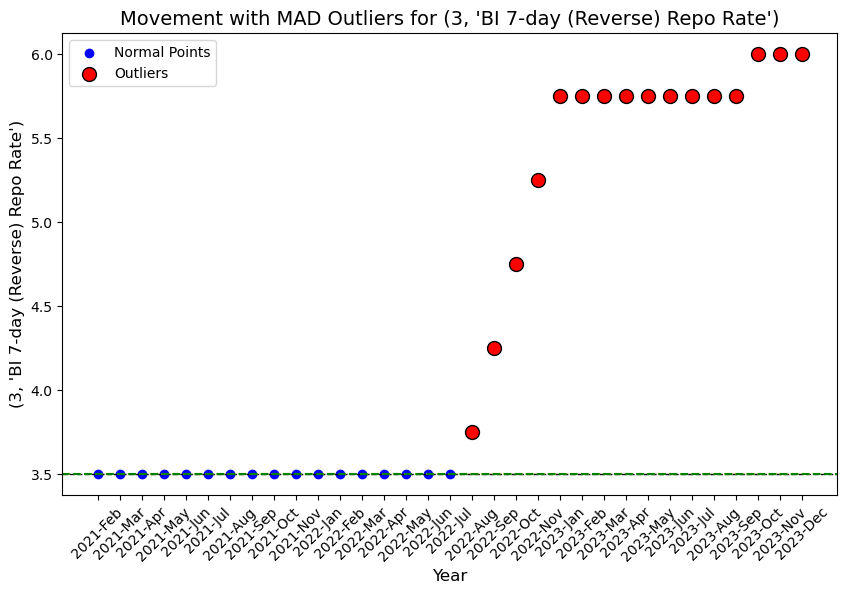

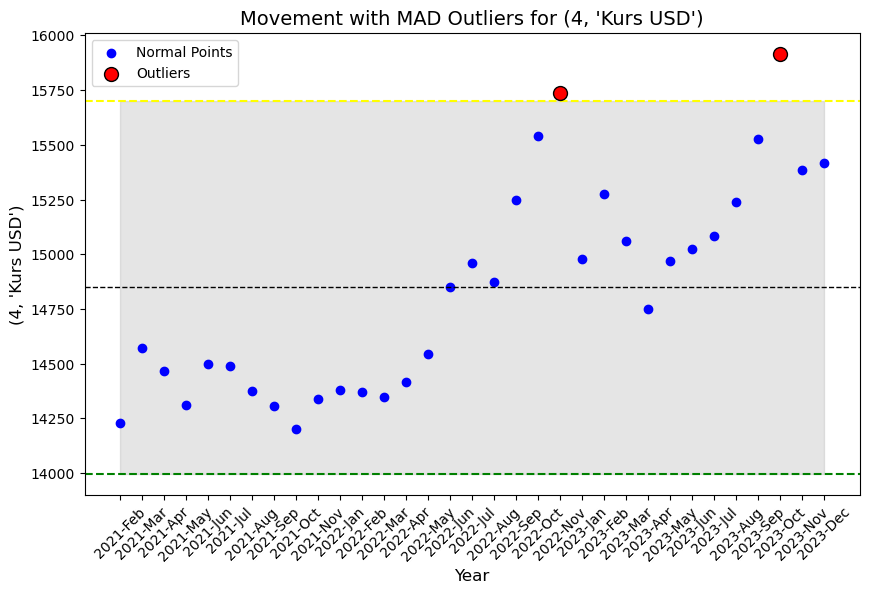

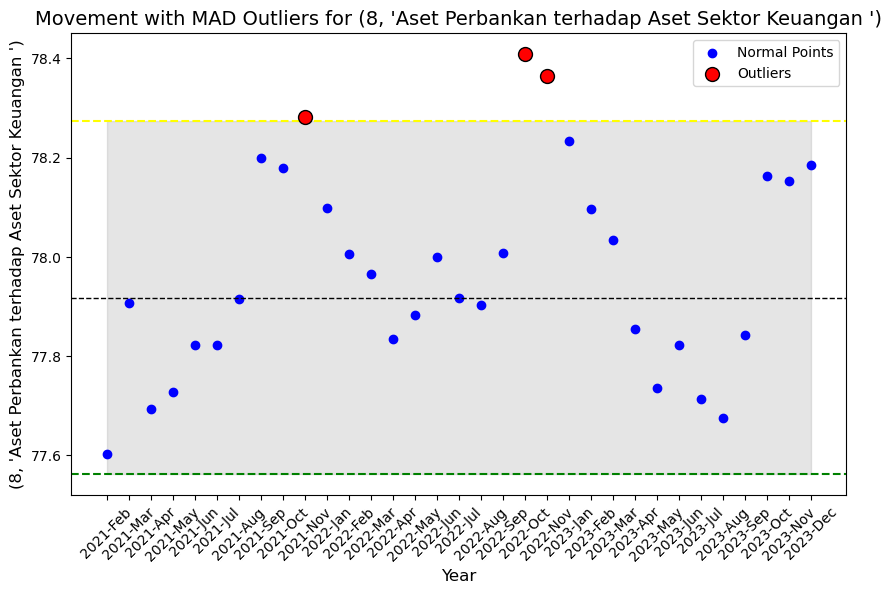

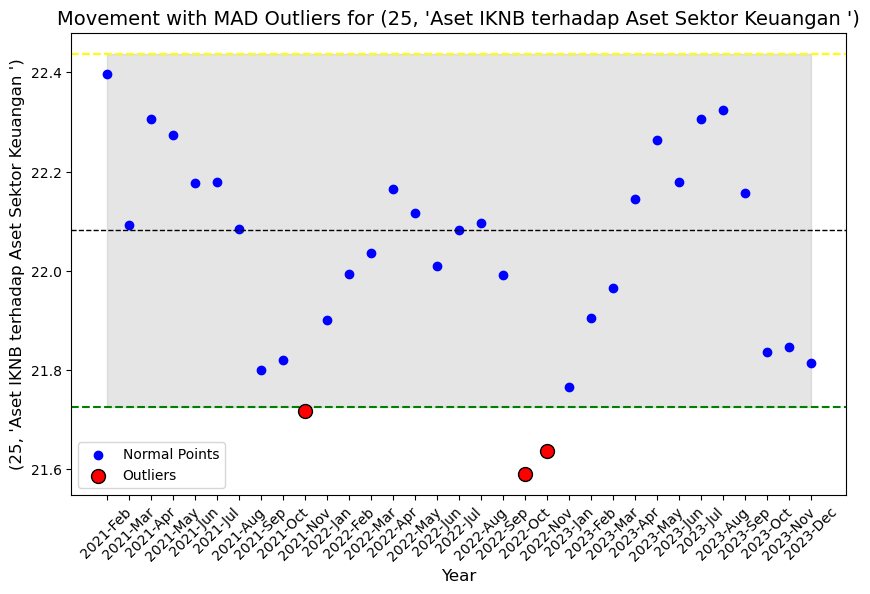

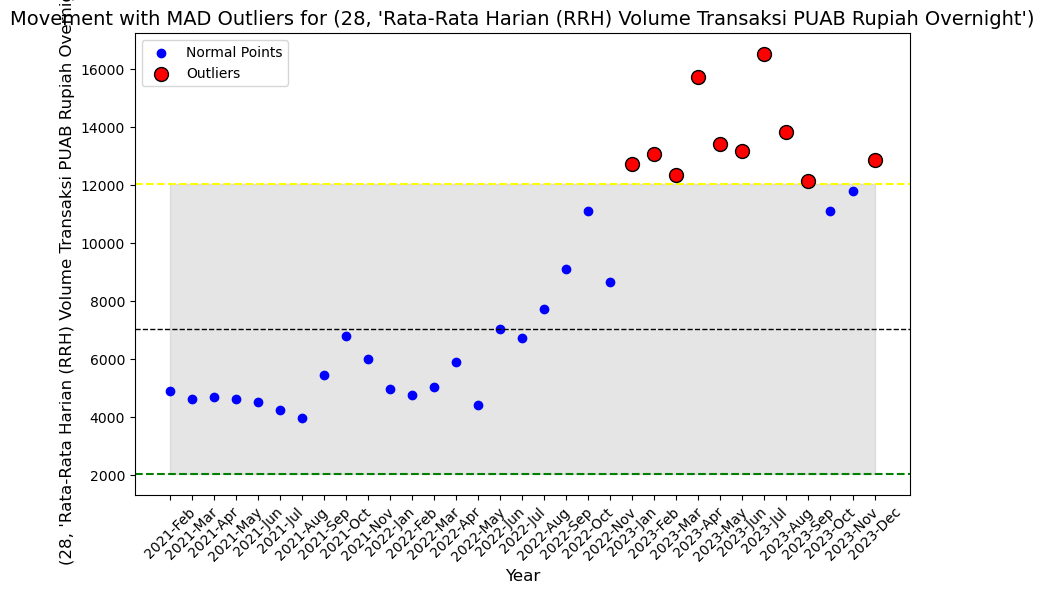

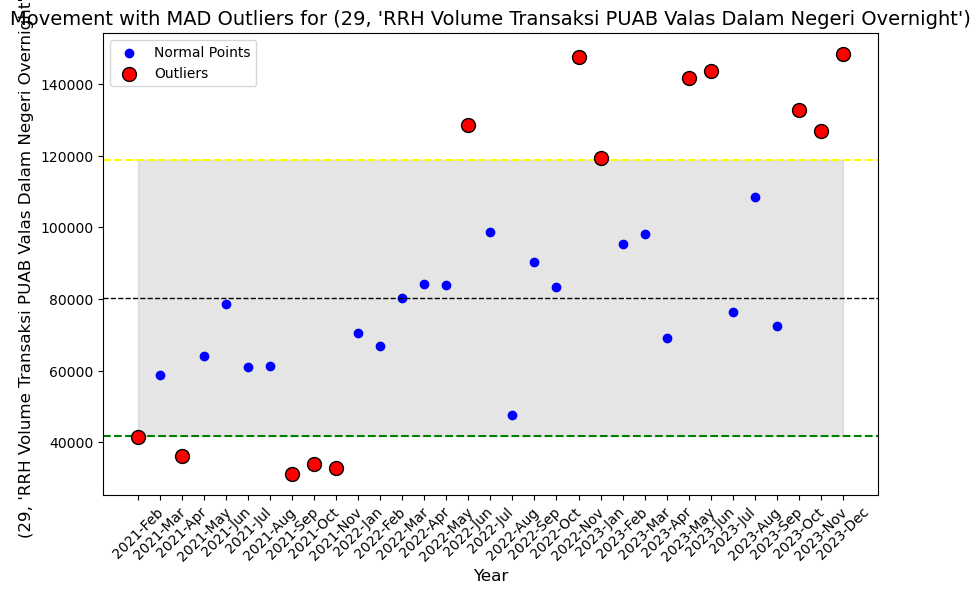

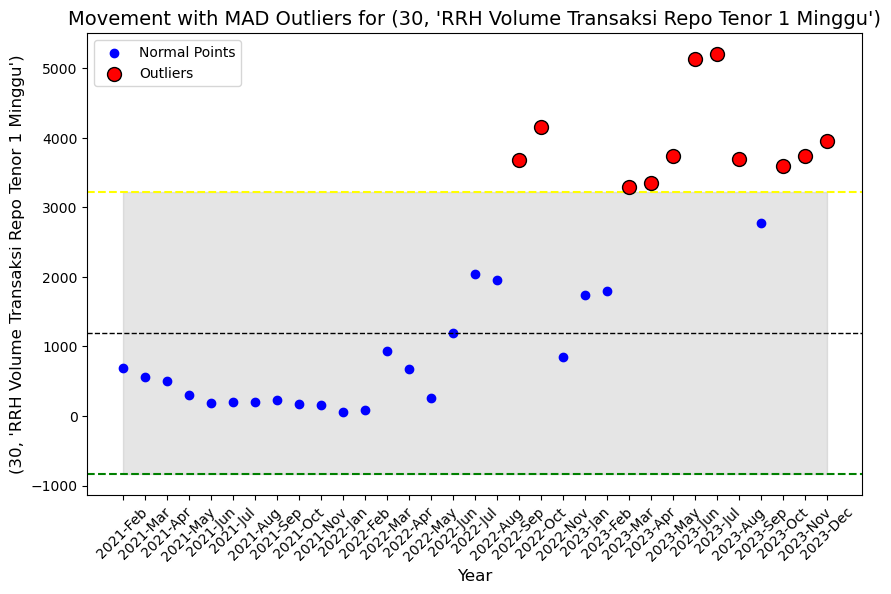

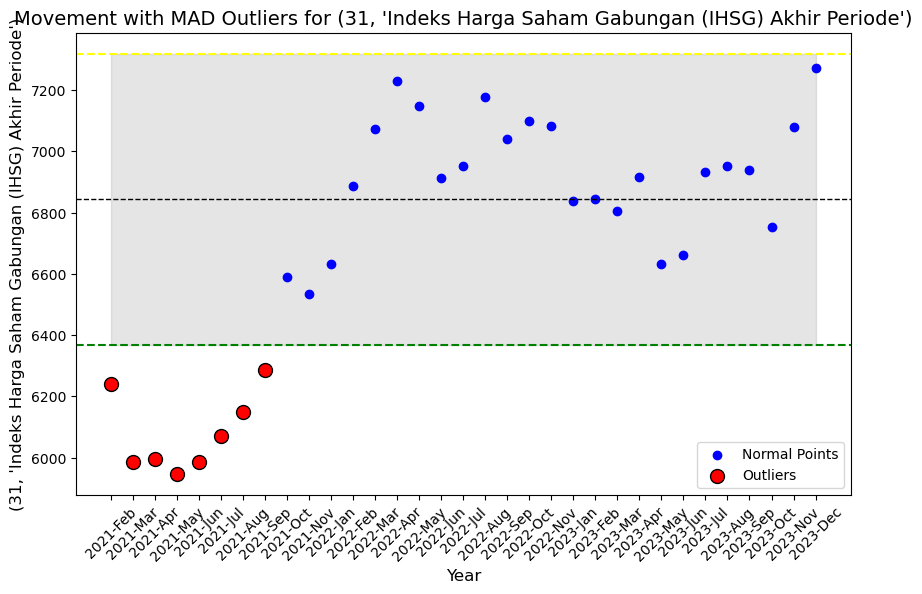

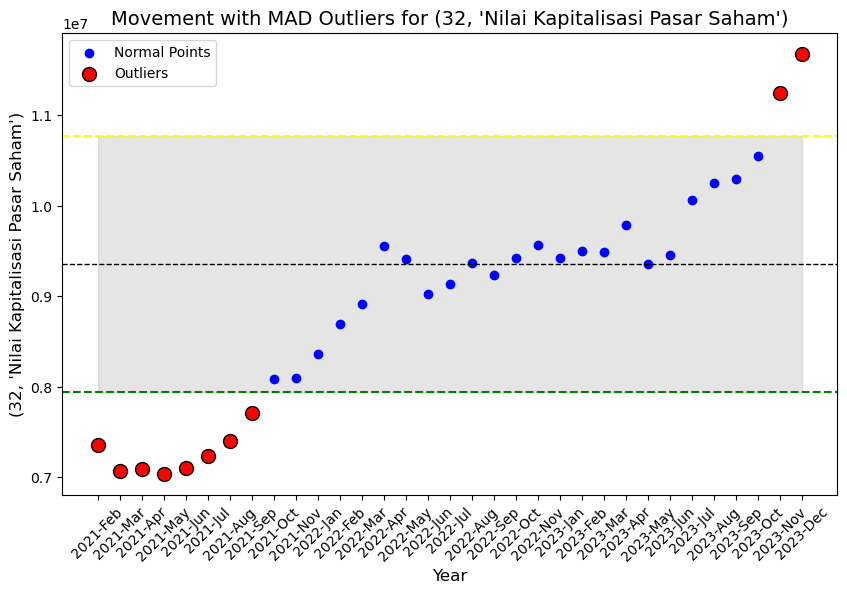

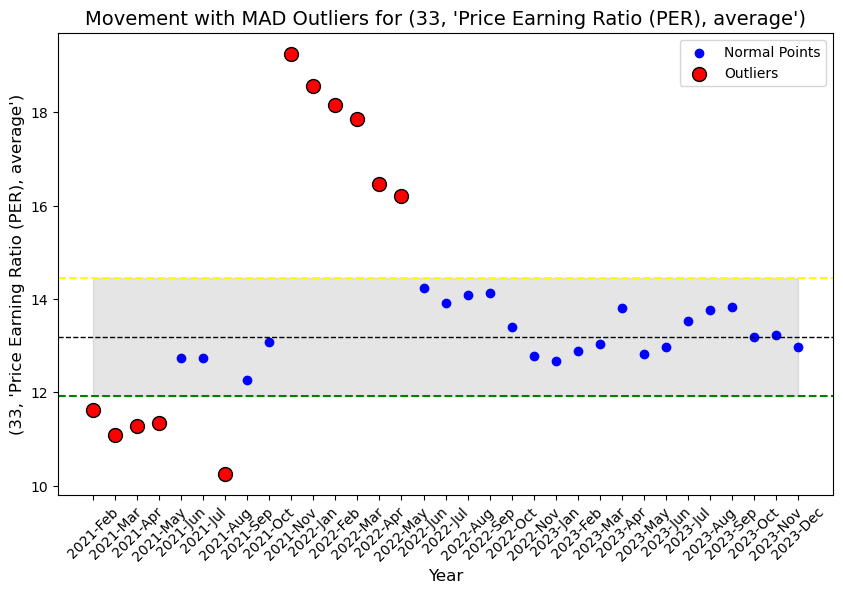

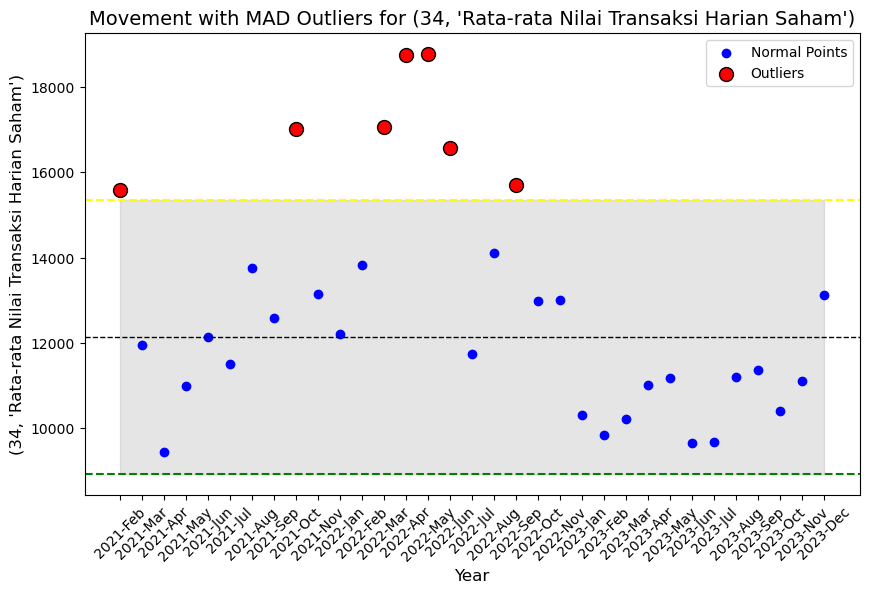

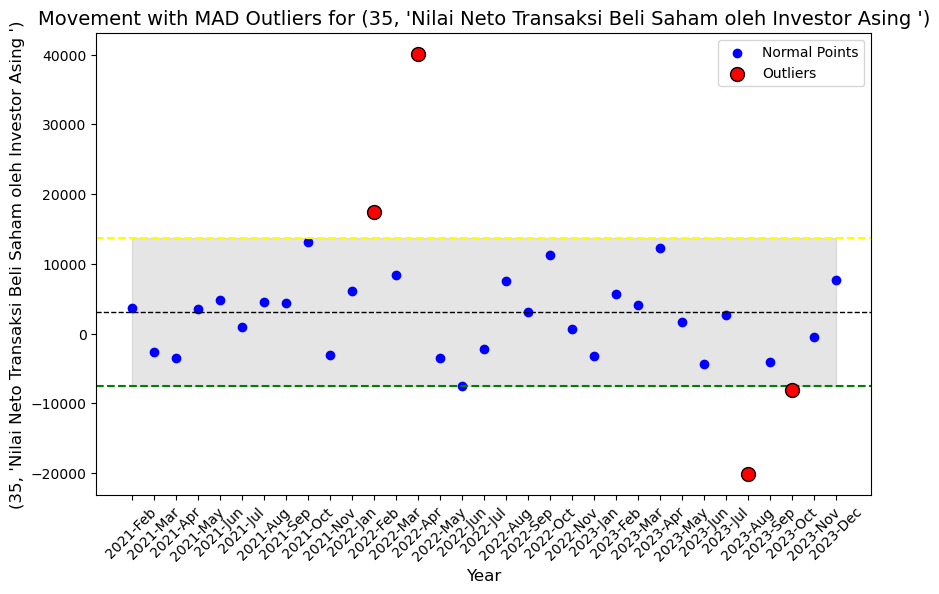

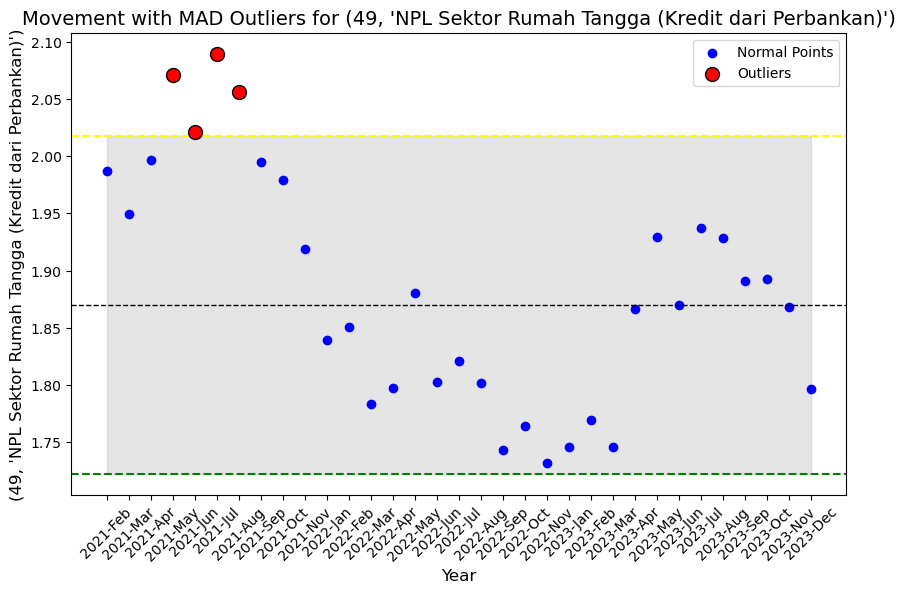

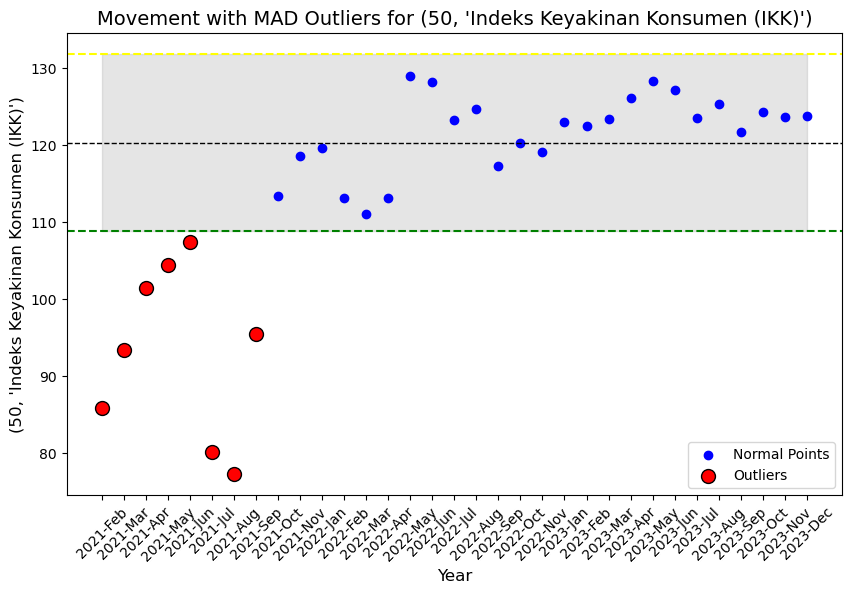

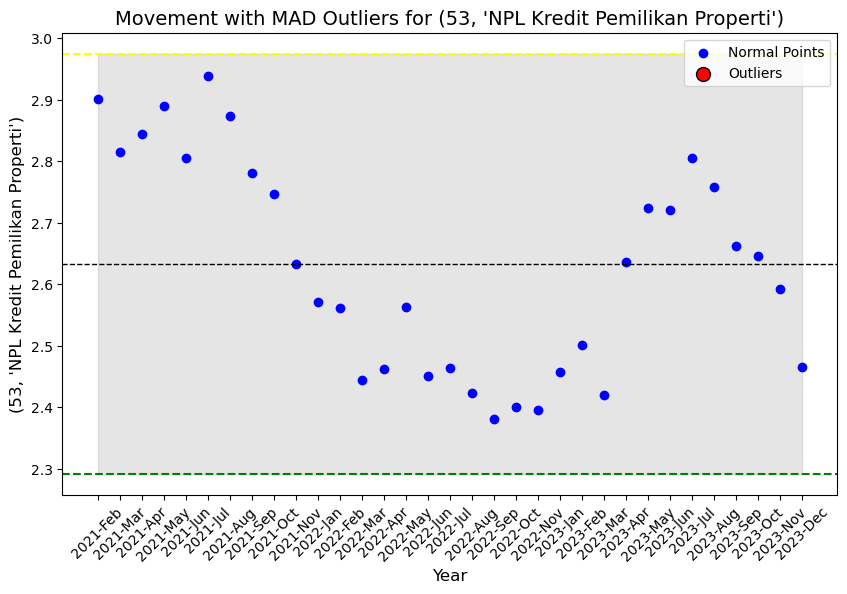

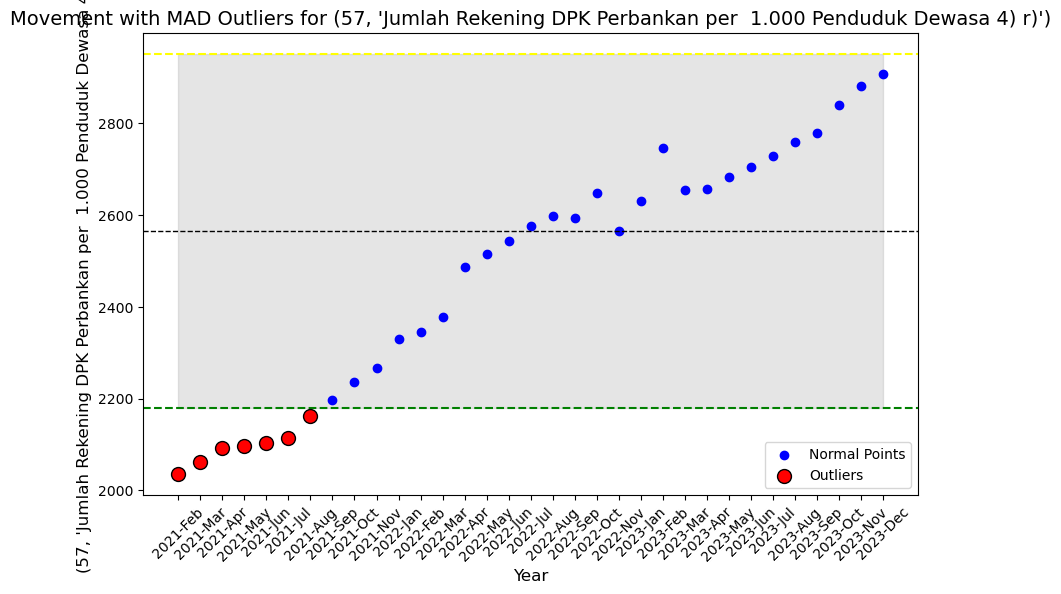

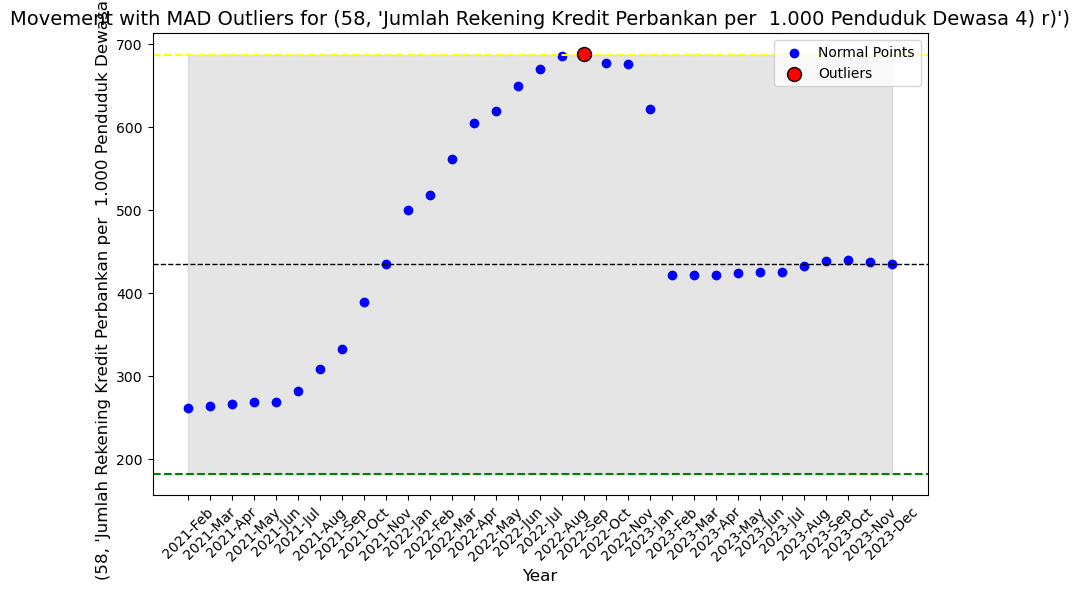

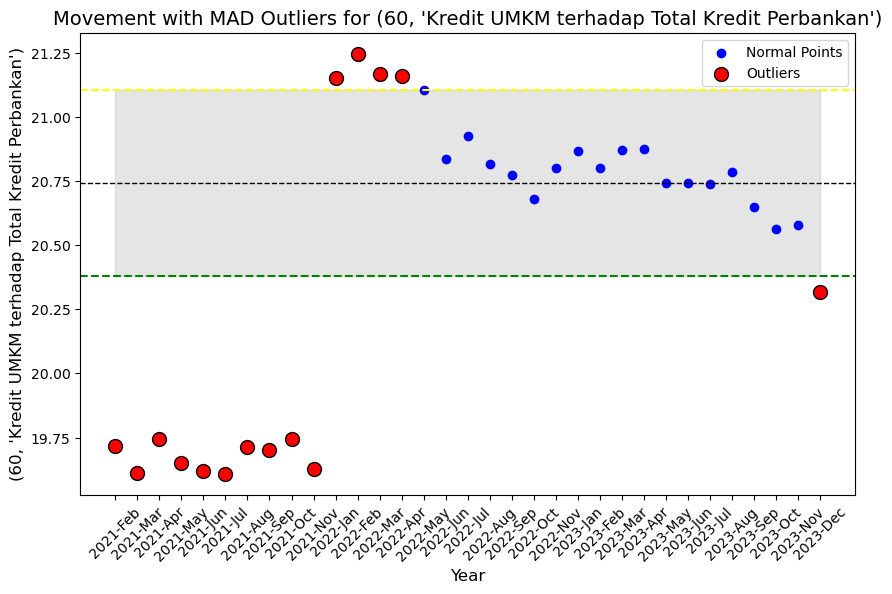

Processing SSKI 2...


C:\Users\Cindy\AppData\Local\Temp\ipykernel_3748\3768459282.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_df.replace('-', np.nan, inplace=True)
C:\Users\Cindy\AppData\Local\Temp\ipykernel_3748\3768459282.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.replace('-', np.nan, inplace=True)
C:\Users\Cindy\AppData\Local\Temp\ipykernel_3748\1620652724.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0 if isinstance(x, str) else x)


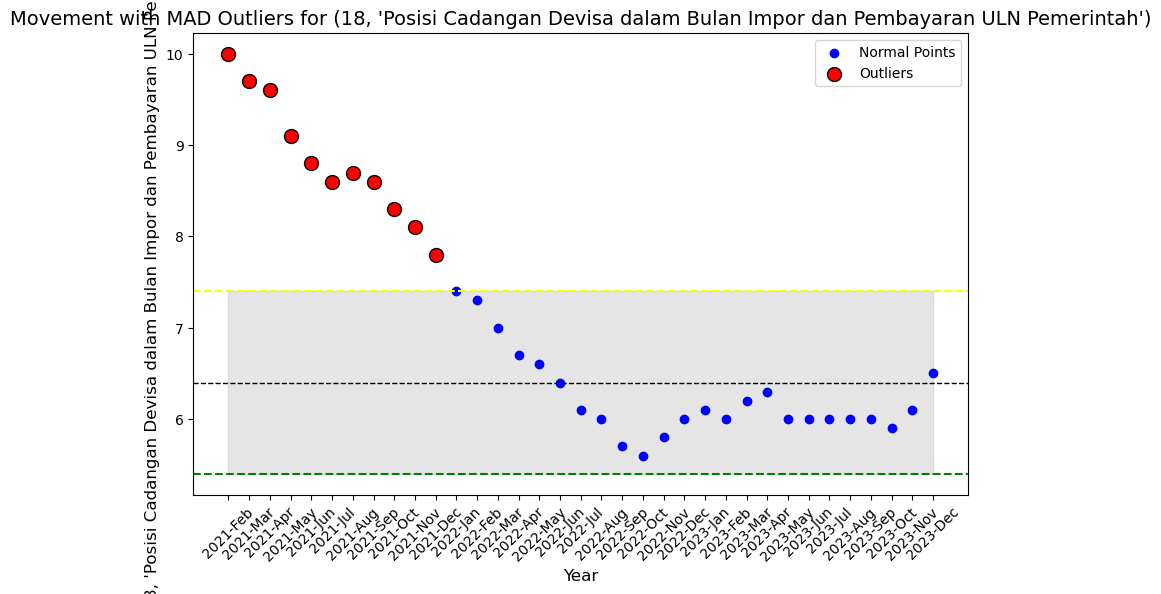

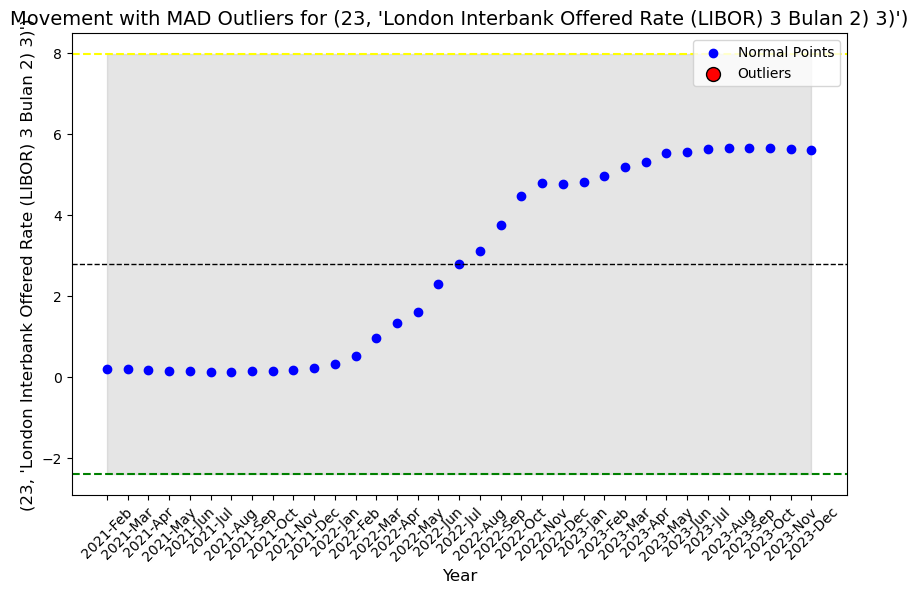

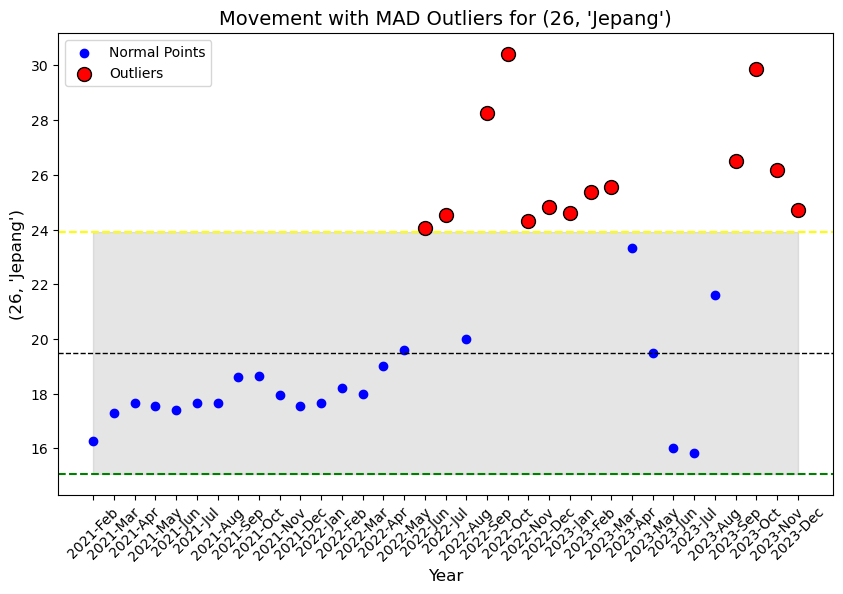

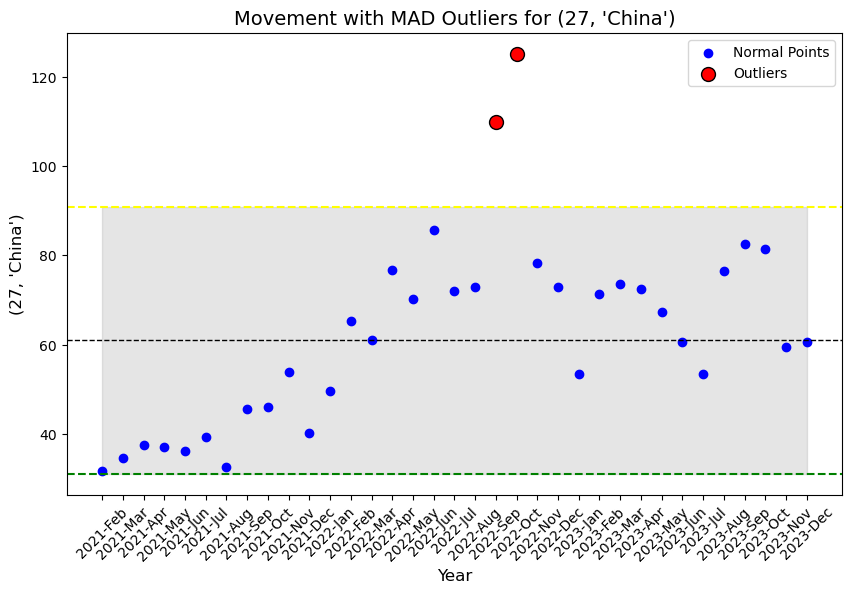

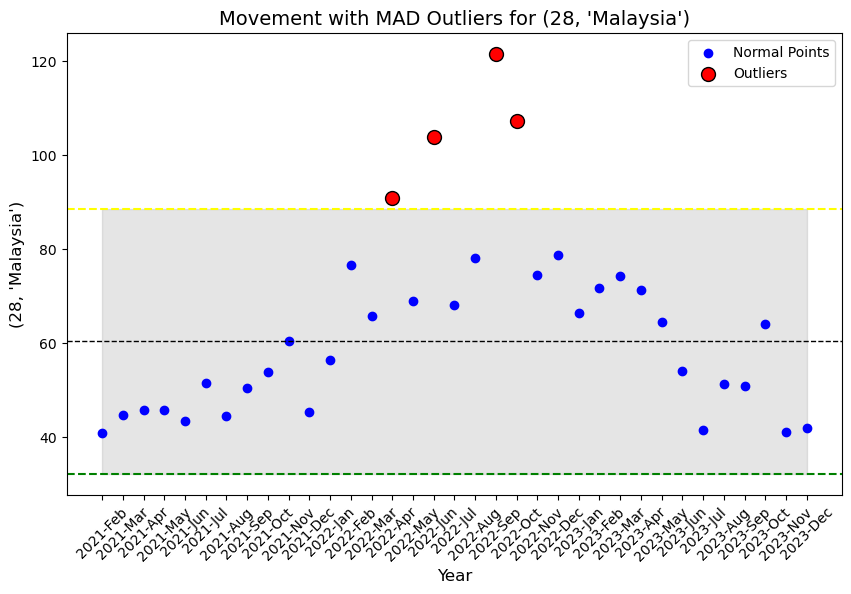

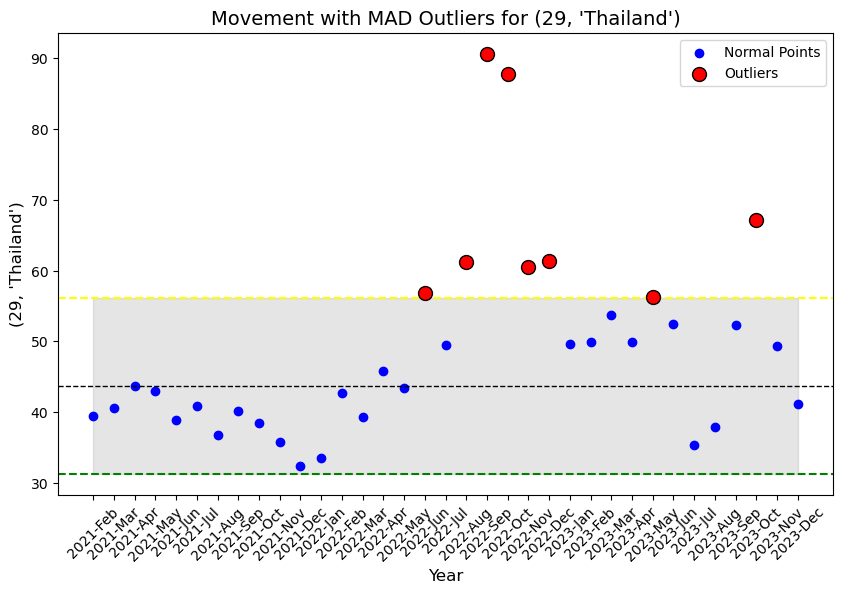

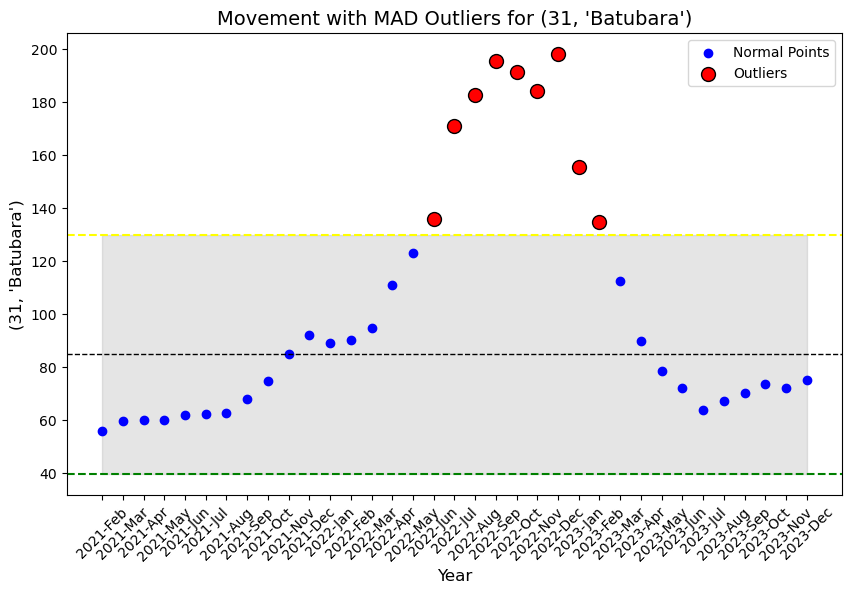

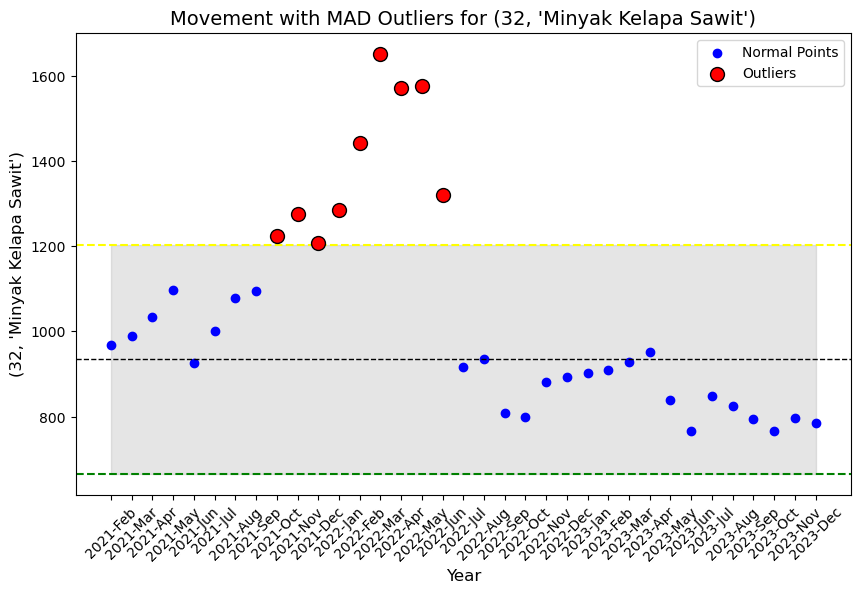

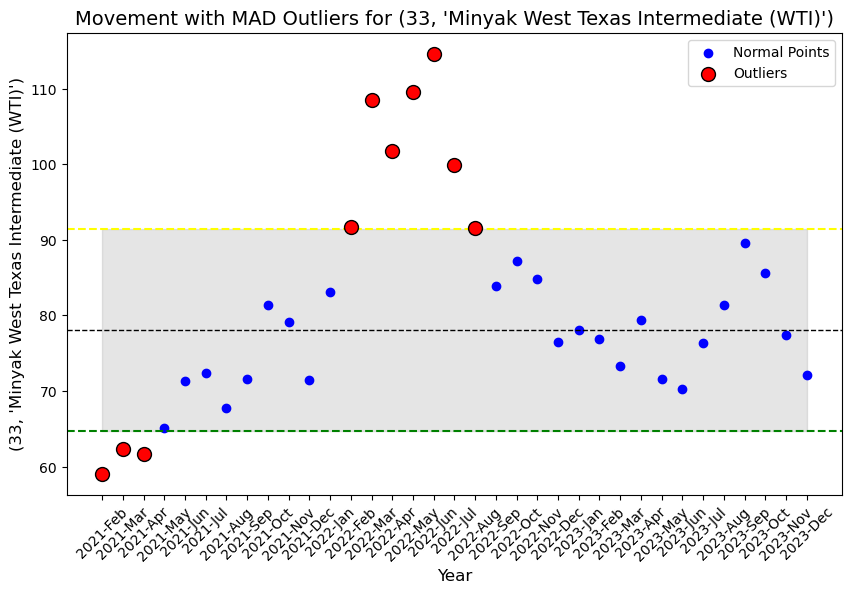

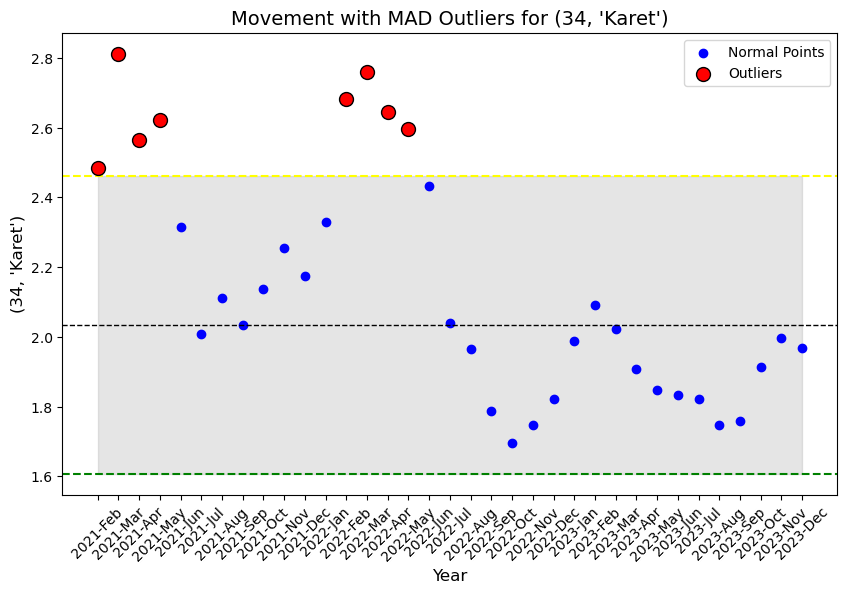

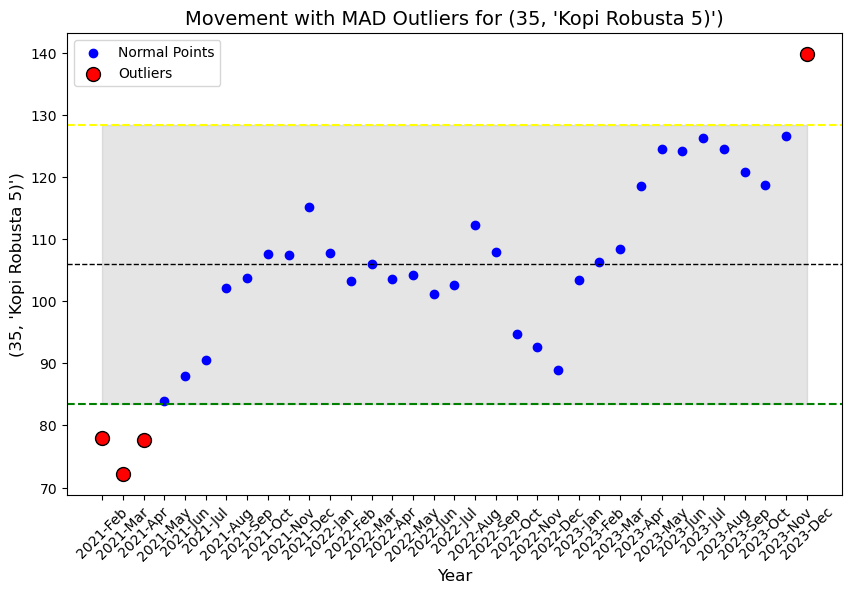

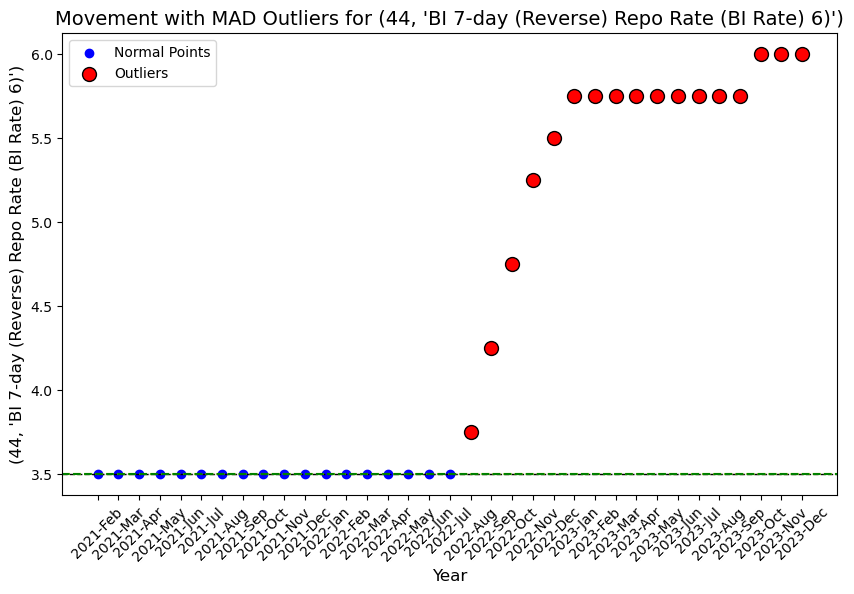

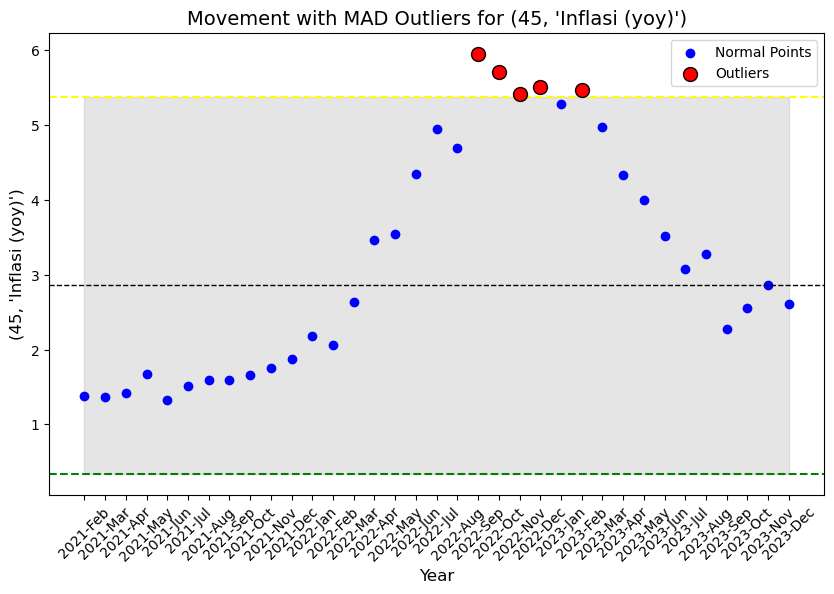

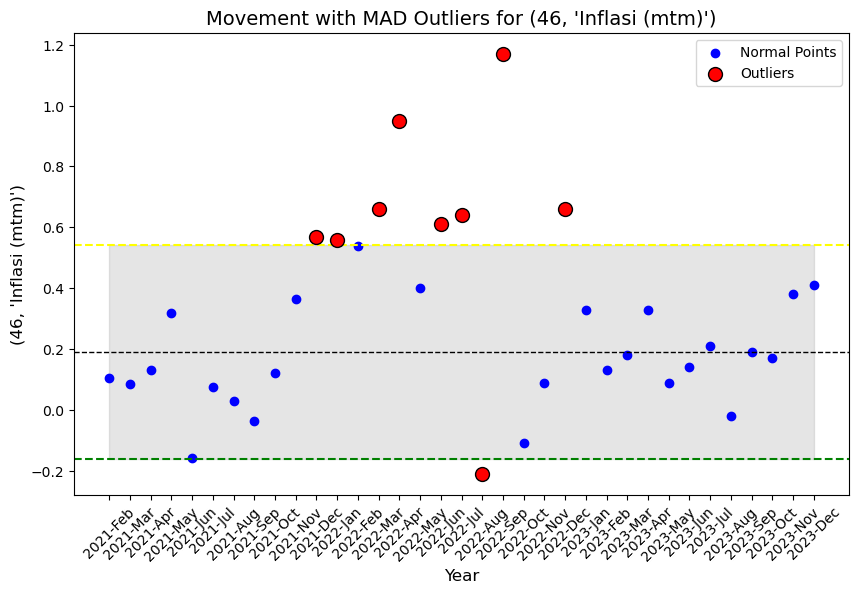

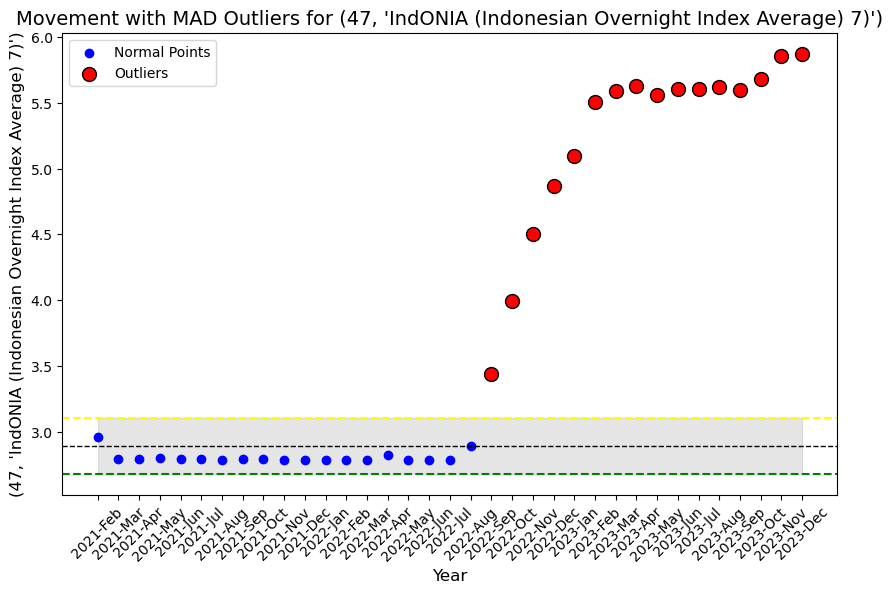

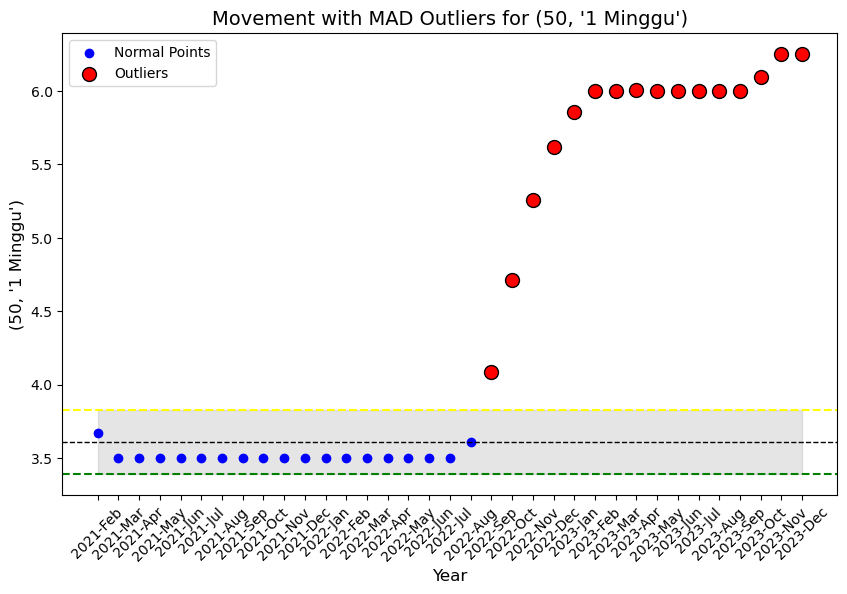

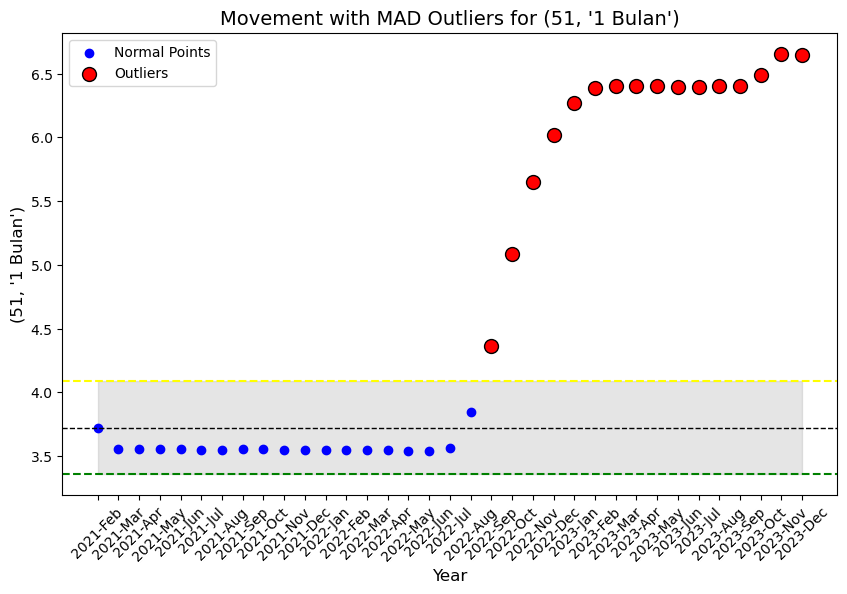

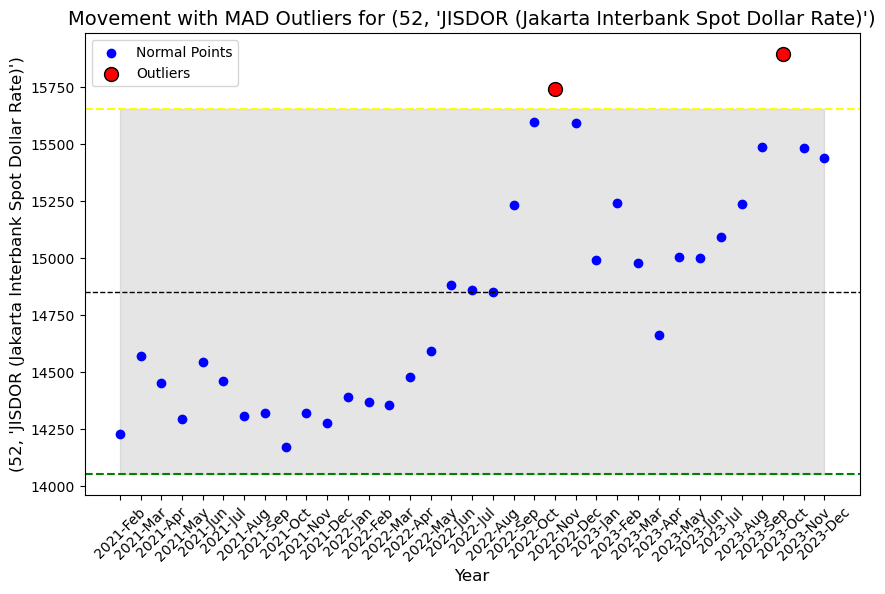

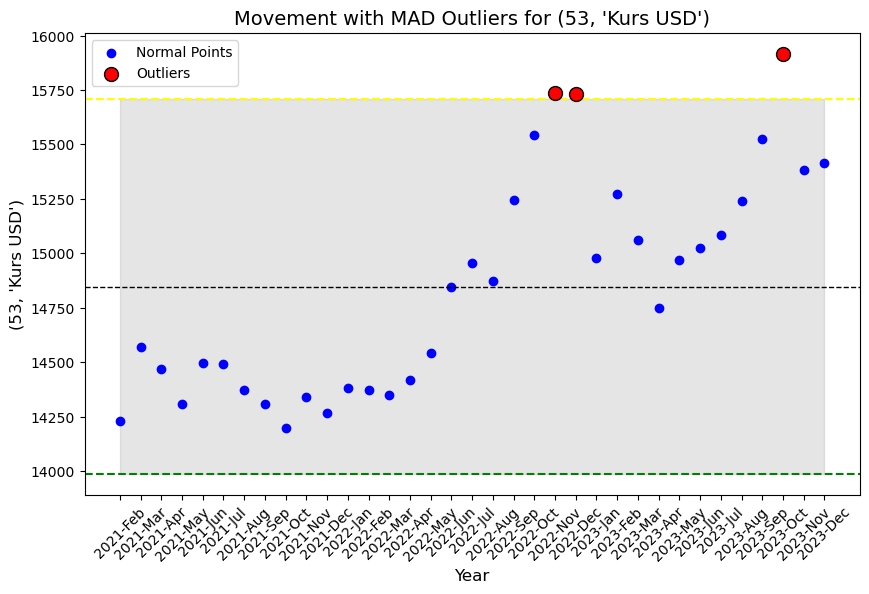

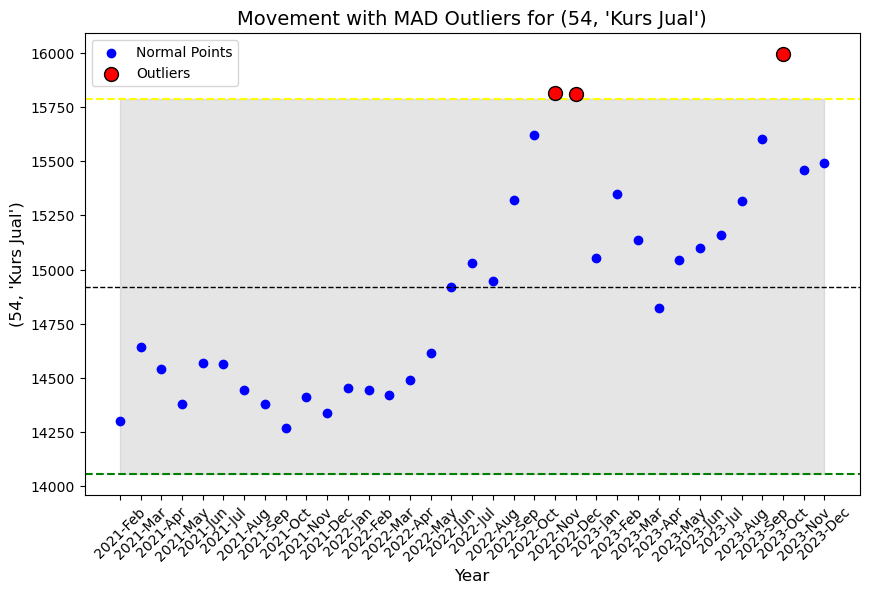

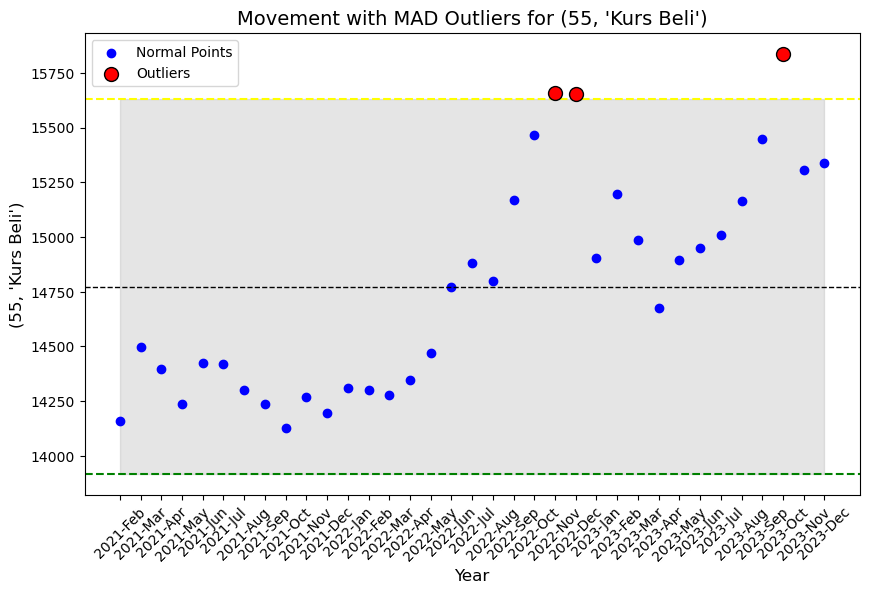

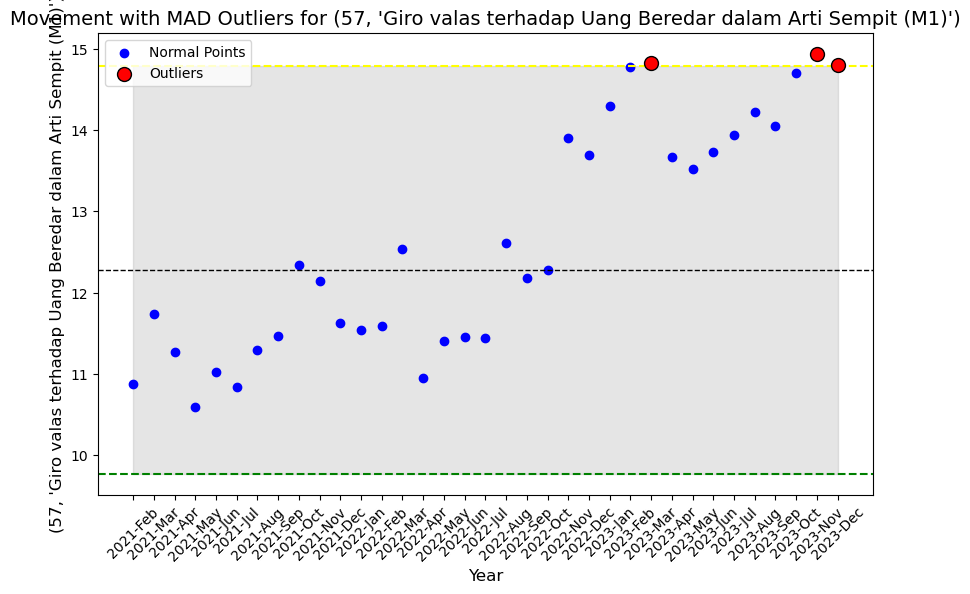

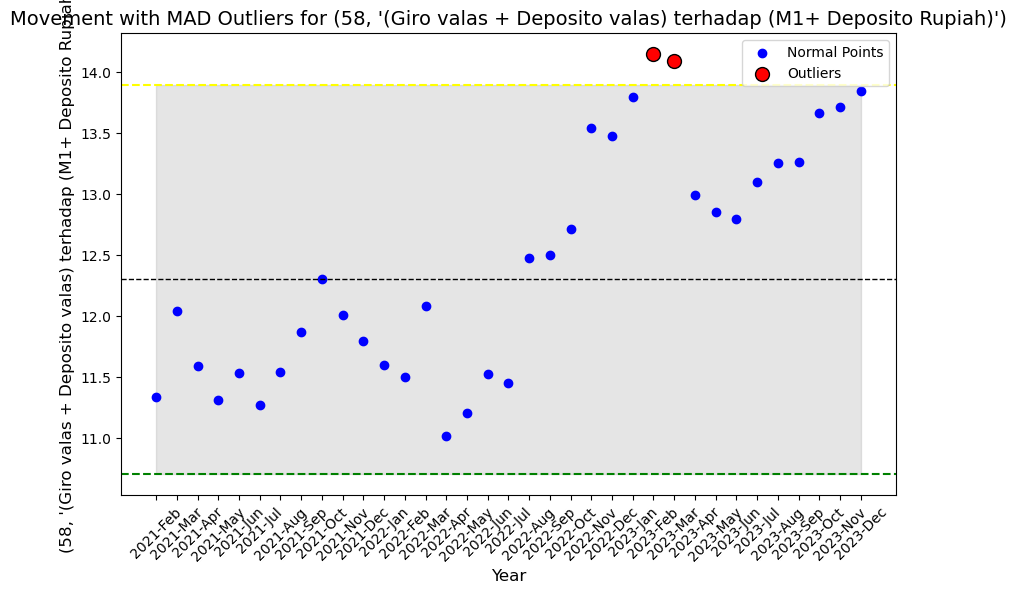

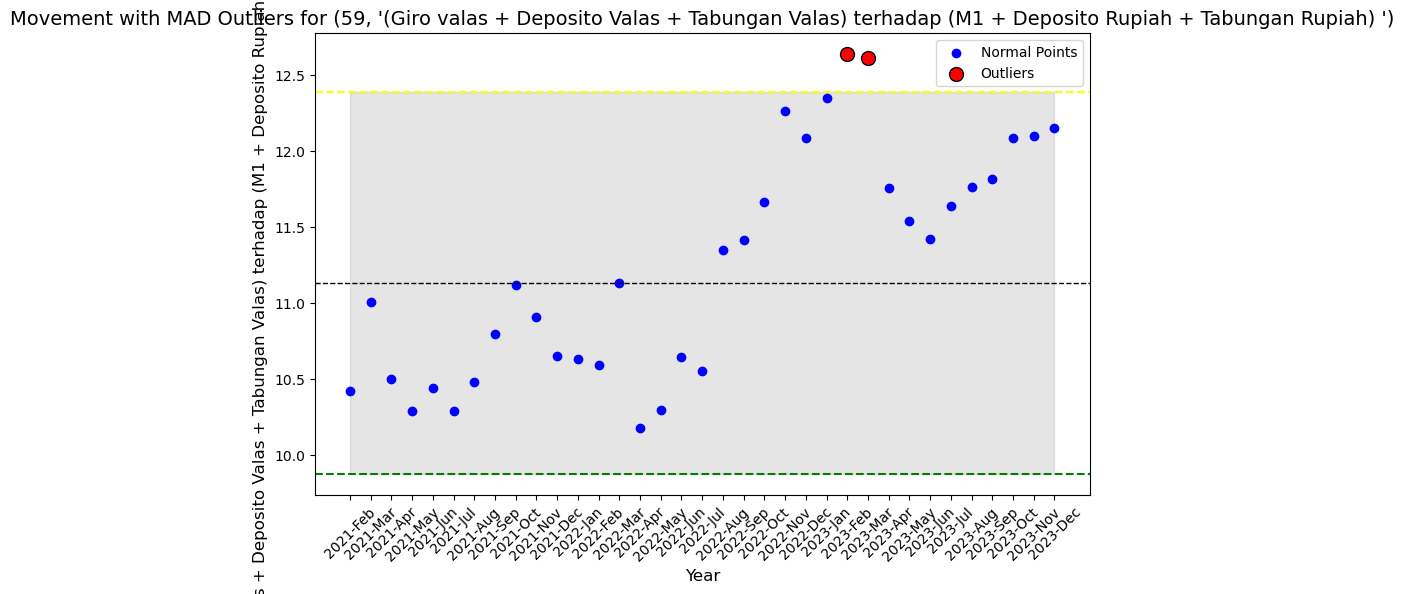

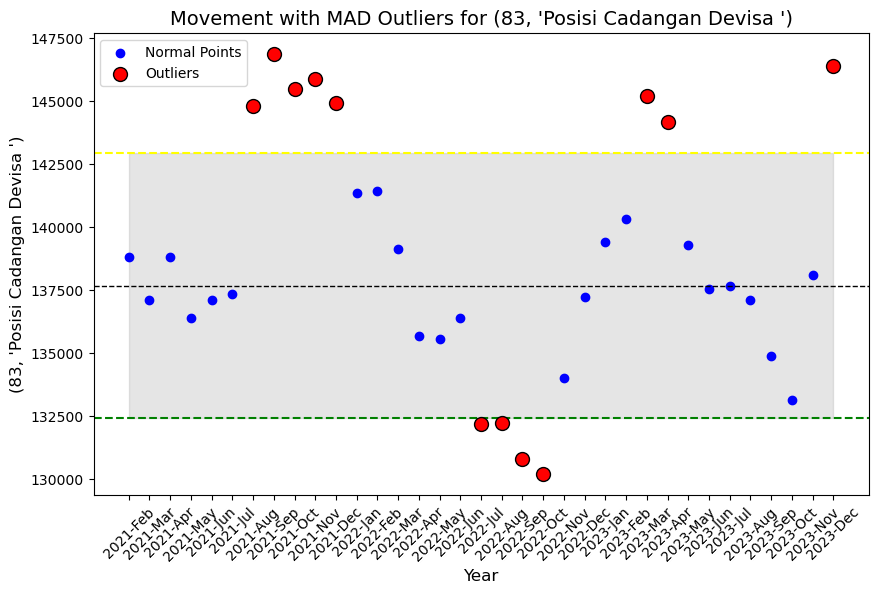

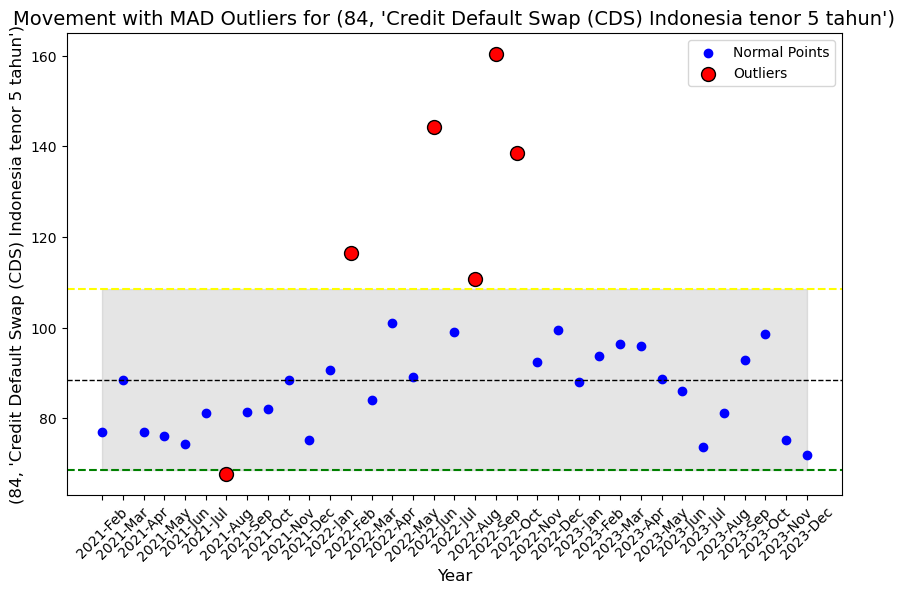

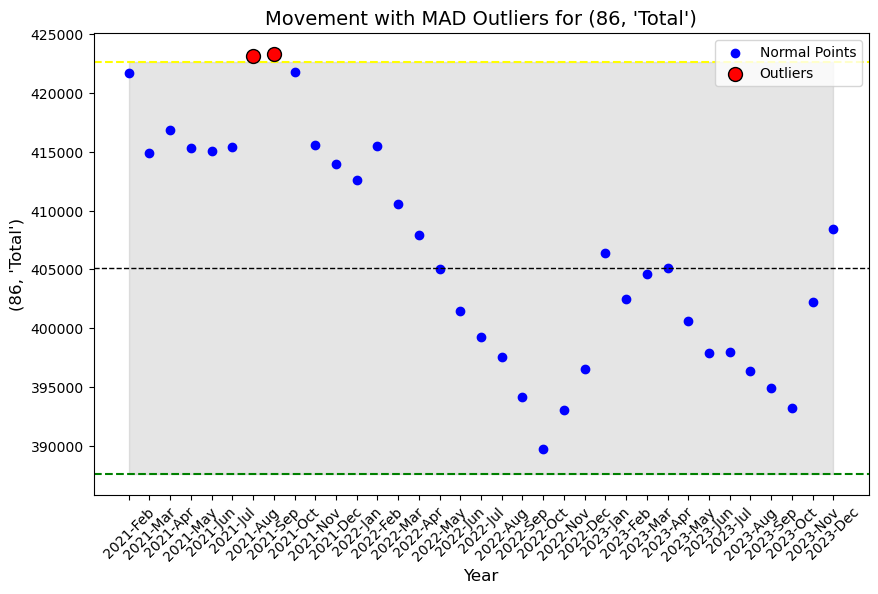

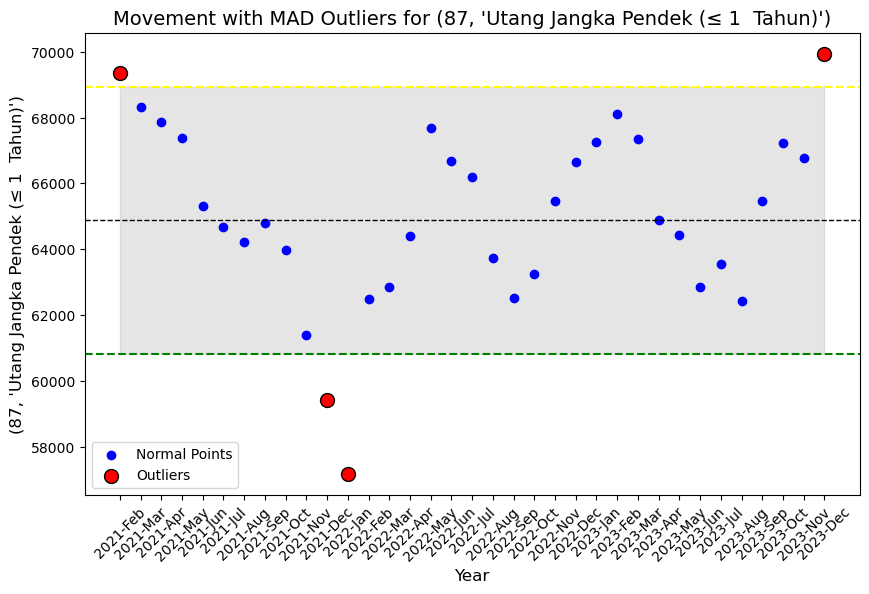

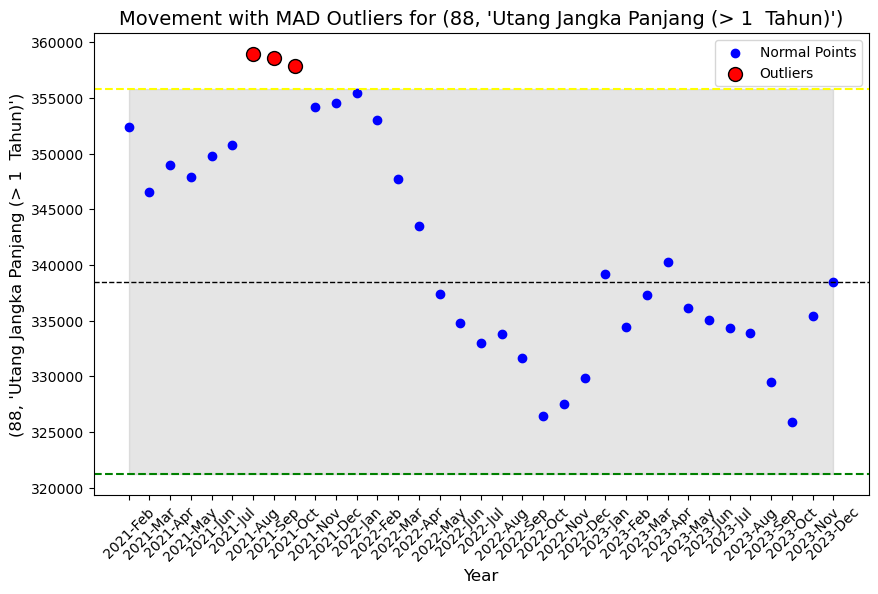

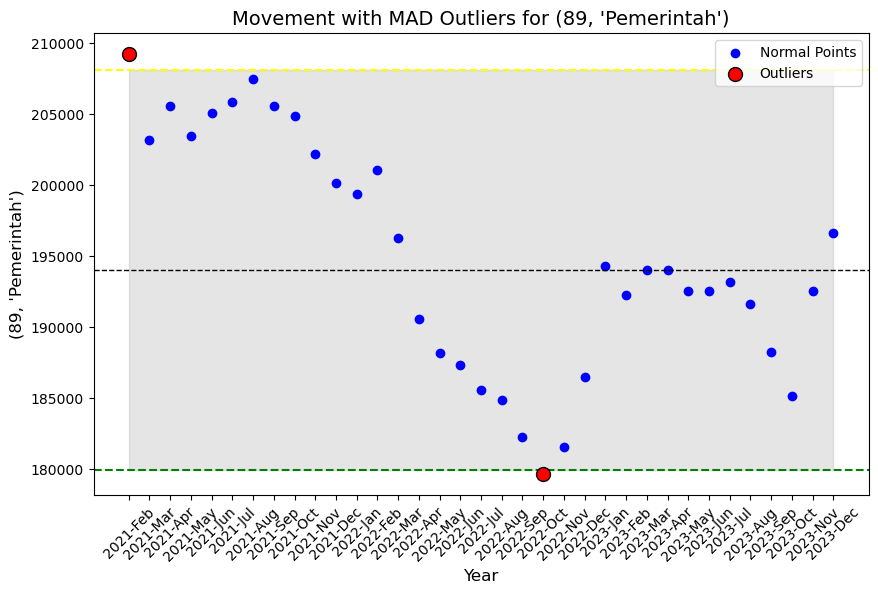

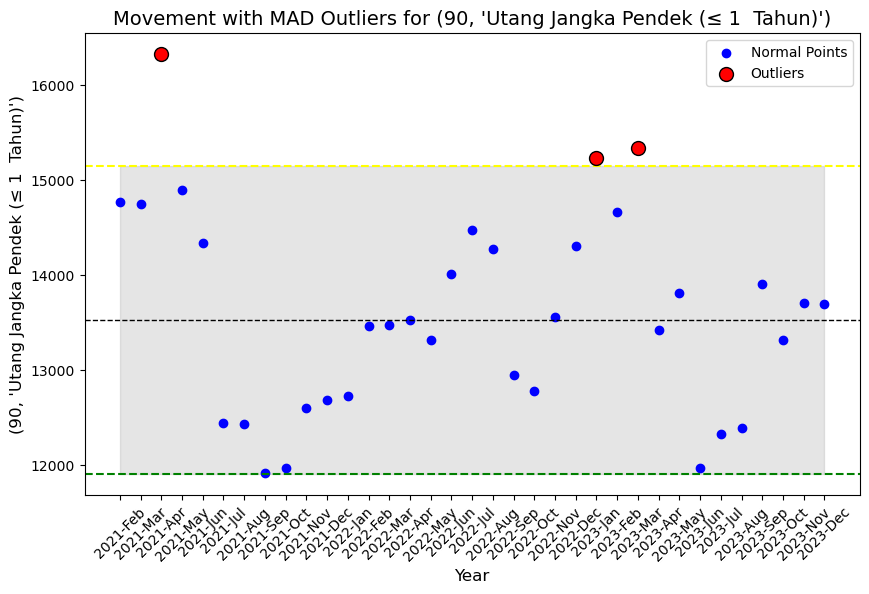

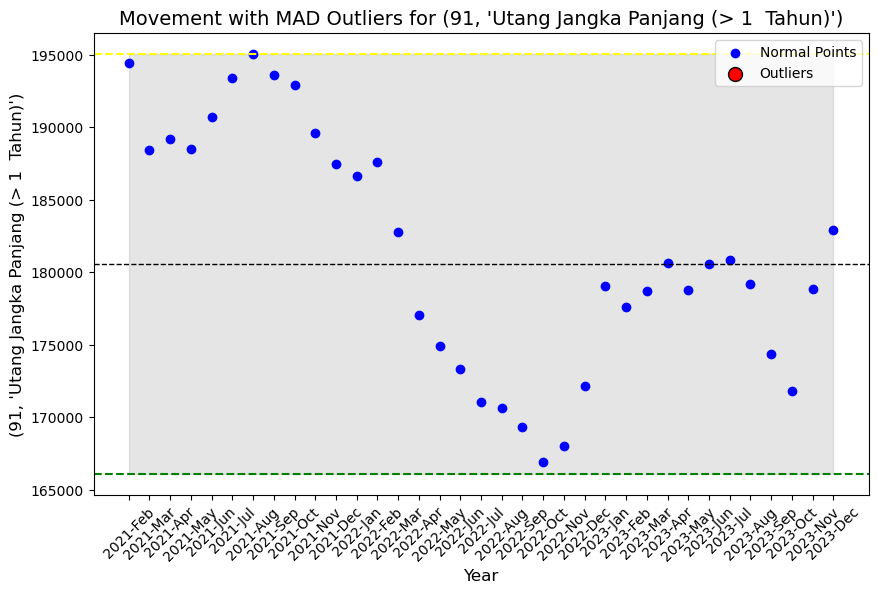

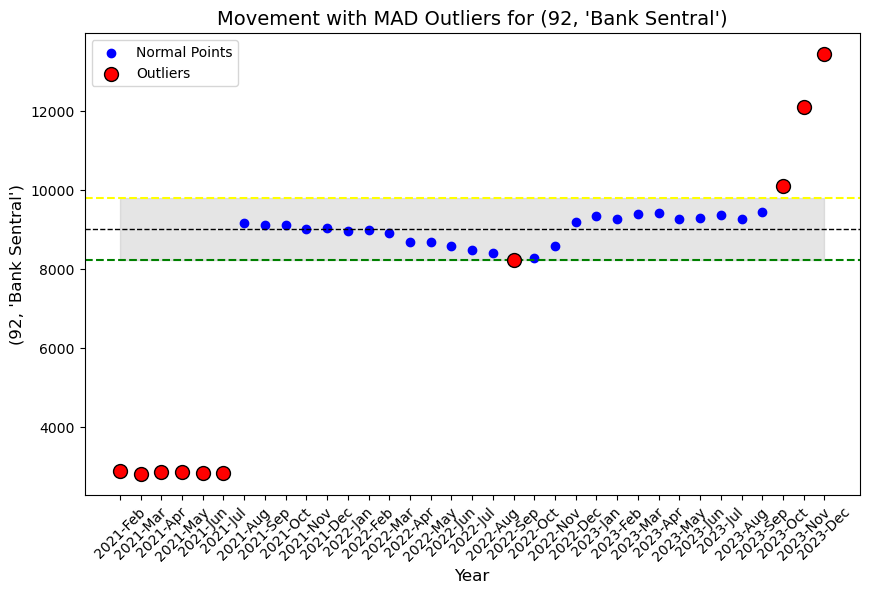

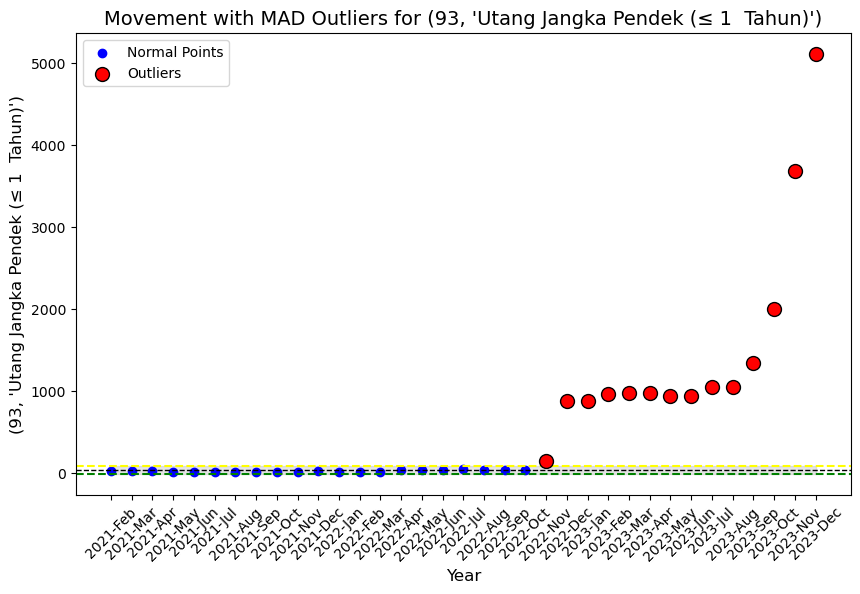

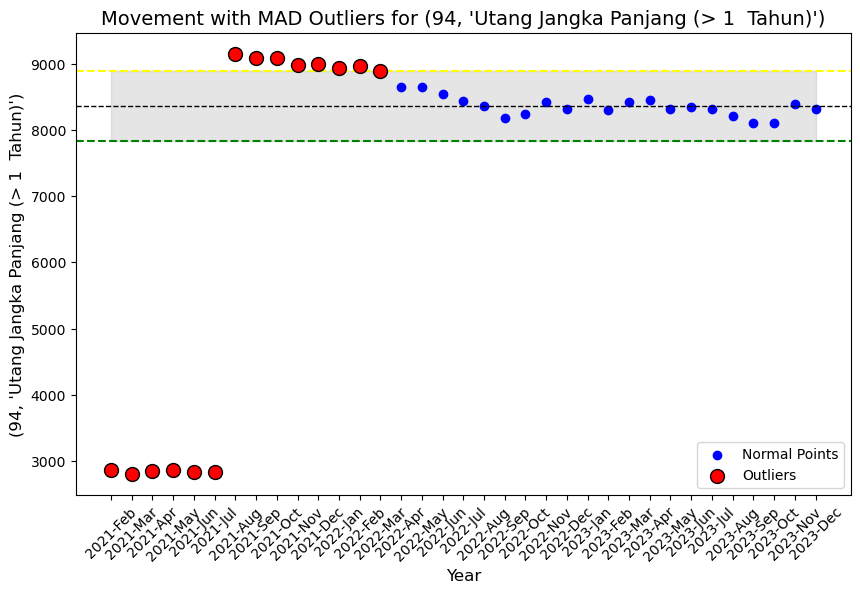

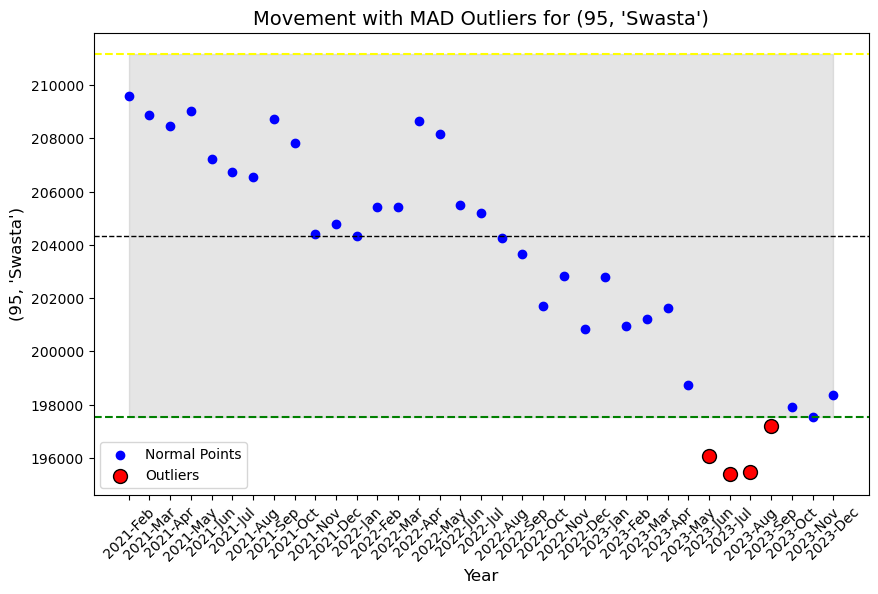

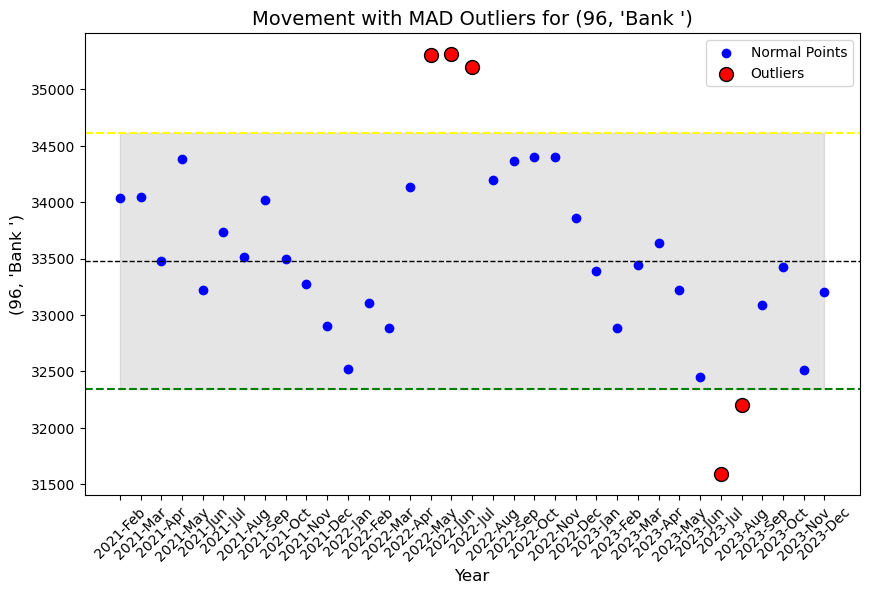

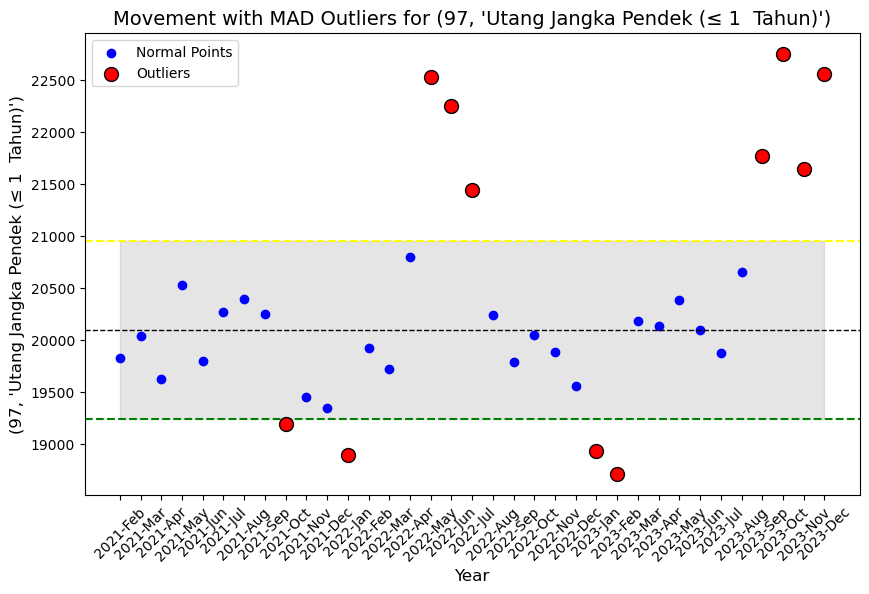

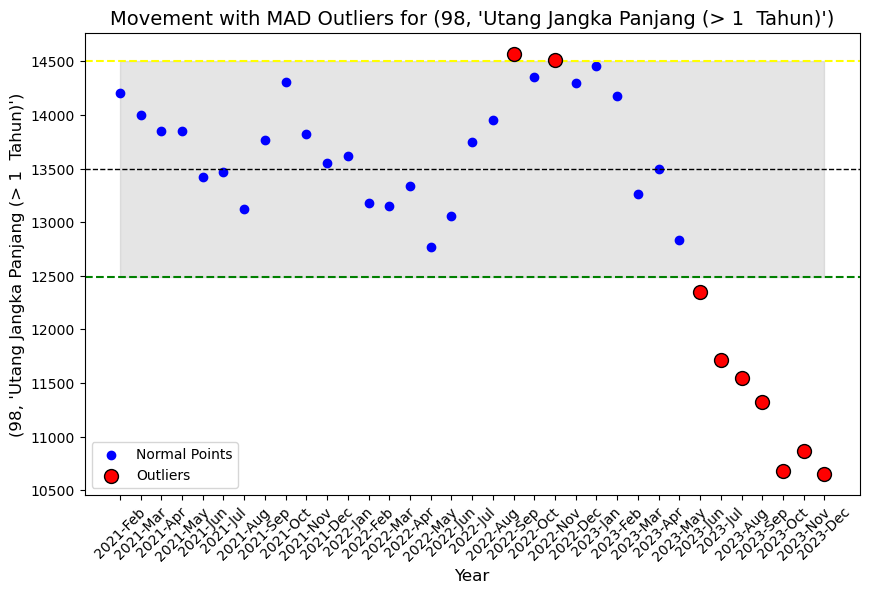

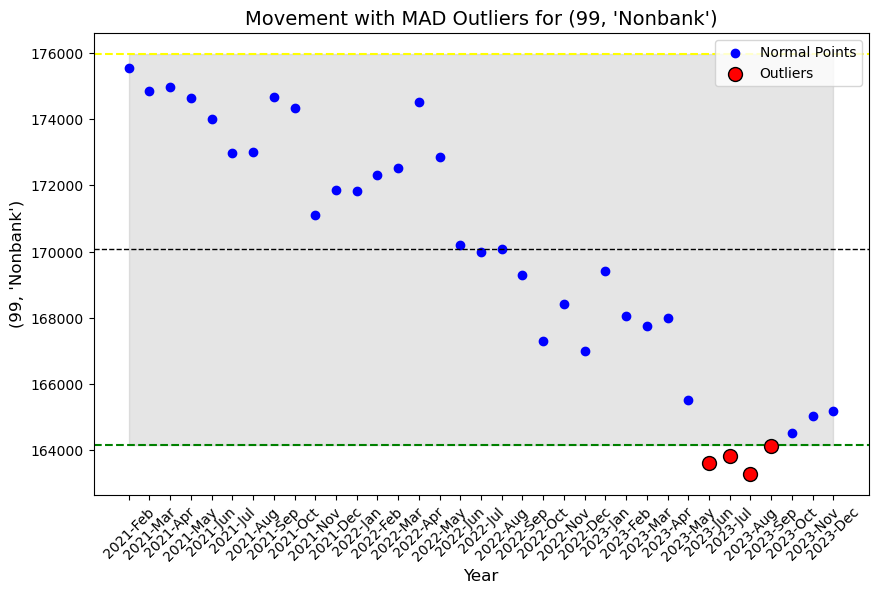

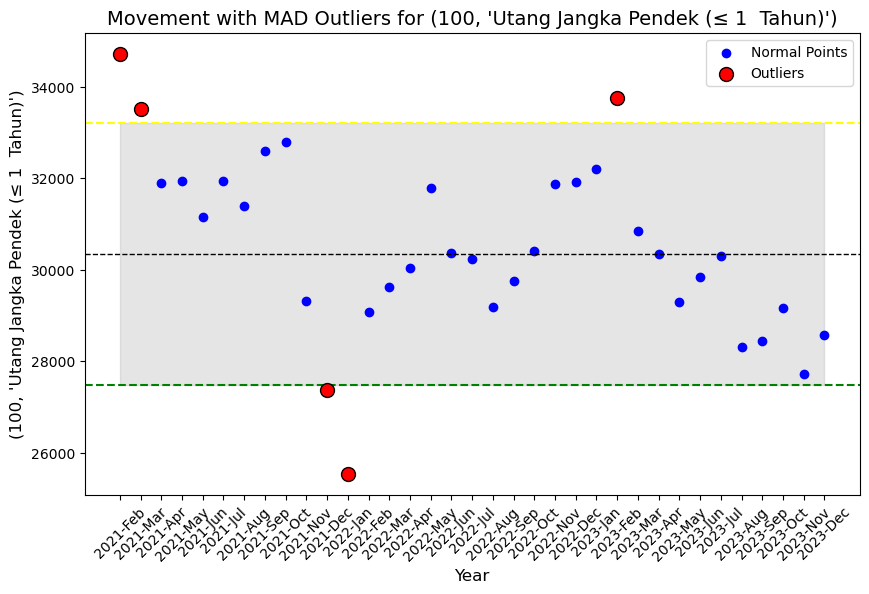

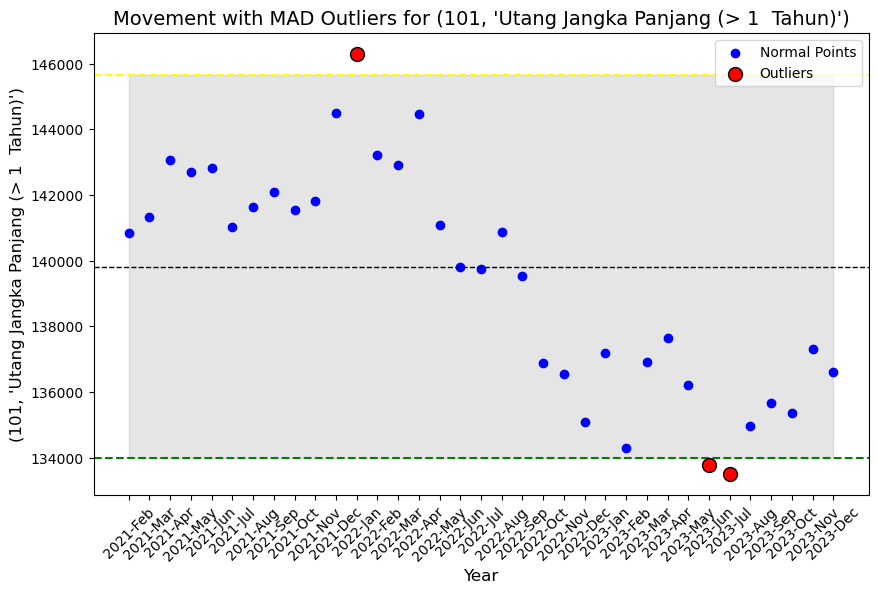

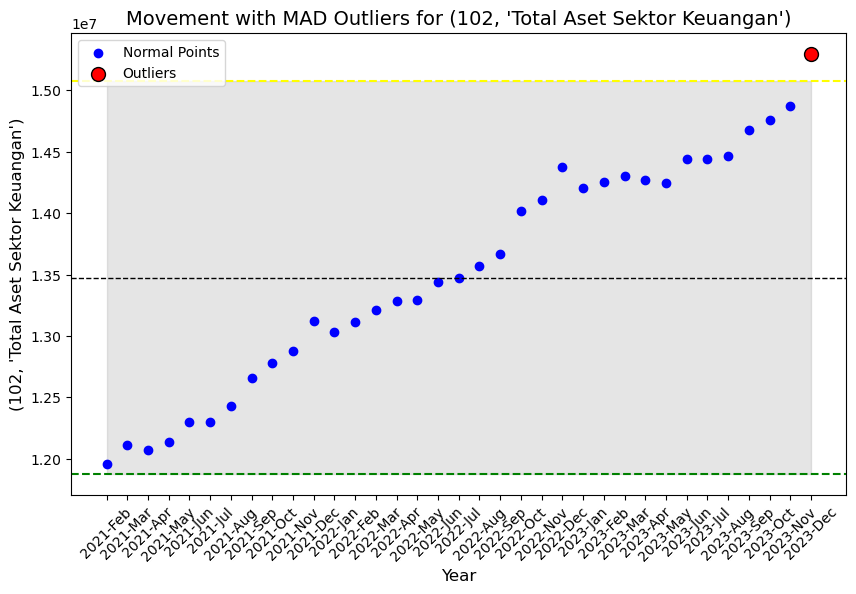

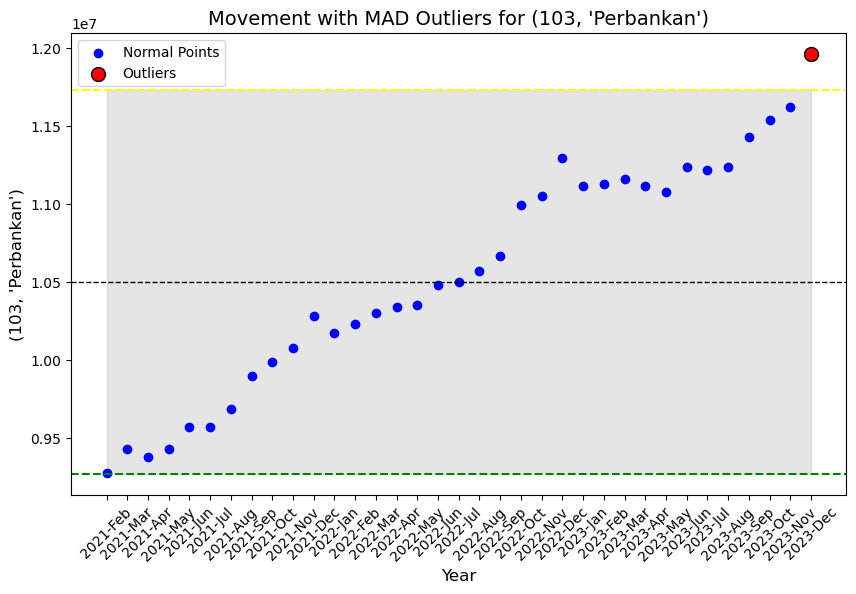

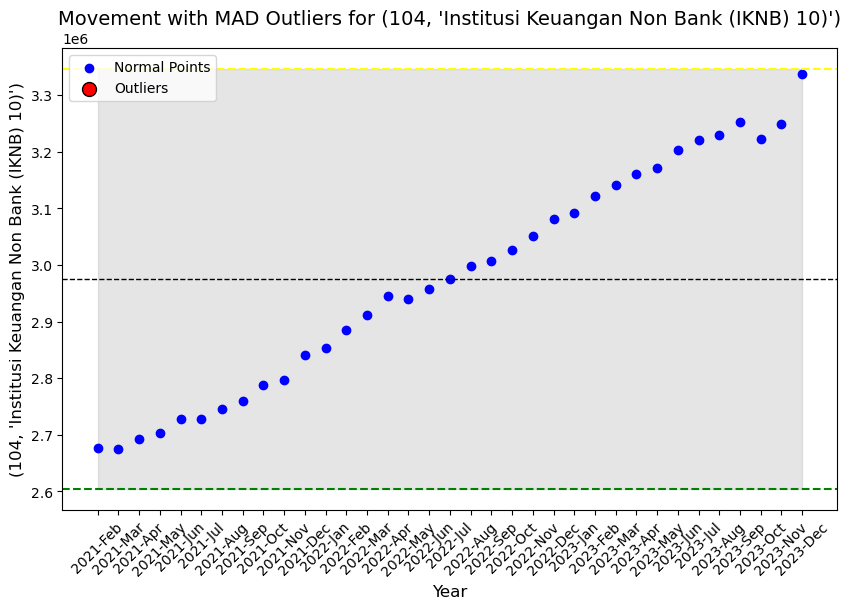

In [27]:
sheet_names = ["1","2"]
for name in sheet_names:
    print(f"Processing SSKI {name}...")
    
    if name == "5a":
        raw_df = prepare_dataframe5(name)
        checked_df = prepare_all(name, raw_df)
        checked_df = checked_df.iloc[1:]
        claims_df, liabilities_df = split5a(checked_df)
        calculate_mad_outliers_and_plot(claims_df, k=2)
        calculate_mad_outliers_and_plot(liabilities_df, k=2)
    elif name == "5b" or name == "5c":
        raw_df = prepare_dataframe5(name)
        checked_df = prepare_all(name, raw_df)
        checked_df = checked_df.iloc[1:]
        
        # Split the data
        claims_df_total, liabilities_df_total, claims_df_ld, liabilities_df_ld, claims_df_ds, liabilities_df_ds, claims_df_oi, liabilities_df_oi = split5b(checked_df)
        
        # Plot and output outliers for each group
        calculate_mad_outliers_and_plot(claims_df_total, k=2)
        calculate_mad_outliers_and_plot(liabilities_df_total, k=2)
        calculate_mad_outliers_and_plot(claims_df_ld, k=2)
        calculate_mad_outliers_and_plot(liabilities_df_ld, k=2)
        calculate_mad_outliers_and_plot(claims_df_ds, k=2)
        calculate_mad_outliers_and_plot(liabilities_df_ds, k=2)
        calculate_mad_outliers_and_plot(claims_df_oi, k=2)
        calculate_mad_outliers_and_plot(liabilities_df_oi, k=2)
    elif name == "5d":
        raw_df = prepare_dataframe5(name)
        checked_df = prepare_all(name, raw_df)
        checked_df = checked_df.iloc[1:]
        
        # Split the data
        claims_df_total, liabilities_df_total, claims_df_b, liabilities_df_b, claims_df_nb, liabilities_df_nb = split5d(checked_df)
        
        # Plot and output outliers for each group
        calculate_mad_outliers_and_plot(claims_df_total, k=2)
        calculate_mad_outliers_and_plot(liabilities_df_total, k=2)
        calculate_mad_outliers_and_plot(claims_df_b, k=2)
        calculate_mad_outliers_and_plot(liabilities_df_b, k=2)
        calculate_mad_outliers_and_plot(claims_df_nb, k=2)
        calculate_mad_outliers_and_plot(liabilities_df_nb, k=2)
    elif name == "5d.1":
        raw_df = prepare_dataframe5(name)
        checked_df = prepare_all(name, raw_df)
        checked_df = checked_df.iloc[1:]
        
        # Split the data
        claims_df_total, liabilities_df_total, claims_df_r, liabilities_df_r = split5d1(checked_df)
        
        # Plot and output outliers for each group
        calculate_mad_outliers_and_plot(claims_df_total, k=2)
        calculate_mad_outliers_and_plot(liabilities_df_total, k=2)
        calculate_mad_outliers_and_plot(claims_df_r, k=2)
        calculate_mad_outliers_and_plot(liabilities_df_r, k=2)
    elif name == "5.d.2":
        raw_df = prepare_dataframe5(name)
        checked_df = prepare_all(name, raw_df)
        checked_df = checked_df.iloc[1:]
        
        # Split the data
        claims_df_total, liabilities_df_total, claims_df_nb, liabilities_df_nb, claims_df_nf, liabilities_df_nf = split5d2(checked_df)
        
        # Plot and output outliers for each group
        calculate_mad_outliers_and_plot(claims_df_total, k=2)
        calculate_mad_outliers_and_plot(liabilities_df_total, k=2)
        calculate_mad_outliers_and_plot(claims_df_nb, k=2)
        calculate_mad_outliers_and_plot(liabilities_df_nb, k=2)
        calculate_mad_outliers_and_plot(claims_df_nf, k=2)
        calculate_mad_outliers_and_plot(liabilities_df_nf, k=2)
    else:
        raw_df = prepare_dataframe(name, 2)
        # checked_df = prepare_qtq(raw_df)
        # checked_df = prepare_mtm(raw_df)
        checked_df = prepare_all(name, raw_df)
        checked_df = checked_df.iloc[1:]
        calculate_mad_outliers_and_plot(checked_df, k=2)

### IQR Calculation

---

**Data Point**

Processing SSKI 1...


C:\Users\Cindy\AppData\Local\Temp\ipykernel_3748\3768459282.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_df.replace('-', np.nan, inplace=True)
C:\Users\Cindy\AppData\Local\Temp\ipykernel_3748\3768459282.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.replace('-', np.nan, inplace=True)
C:\Users\Cindy\AppData\Local\Temp\ipykernel_3748\3392358751.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0 if isinstance(x, str) else x)


Komponen     Tahun  Nilai Outlier  \
0  (33, Price Earning Ratio (PER), average)  2021-Aug      10.257519   
1  (33, Price Earning Ratio (PER), average)  2021-Nov      19.250429   
2  (33, Price Earning Ratio (PER), average)  2022-Jan      18.560000   
3  (33, Price Earning Ratio (PER), average)  2022-Feb      18.147534   
4  (33, Price Earning Ratio (PER), average)  2022-Mar      17.860000   
5  (33, Price Earning Ratio (PER), average)  2022-Apr      16.470000   
6  (33, Price Earning Ratio (PER), average)  2022-May      16.196501   

   Batas Bawah  Batas Atas  
0    10.696795   16.135383  
1    10.696795   16.135383  
2    10.696795   16.135383  
3    10.696795   16.135383  
4    10.696795   16.135383  
5    10.696795   16.135383  
6    10.696795   16.135383

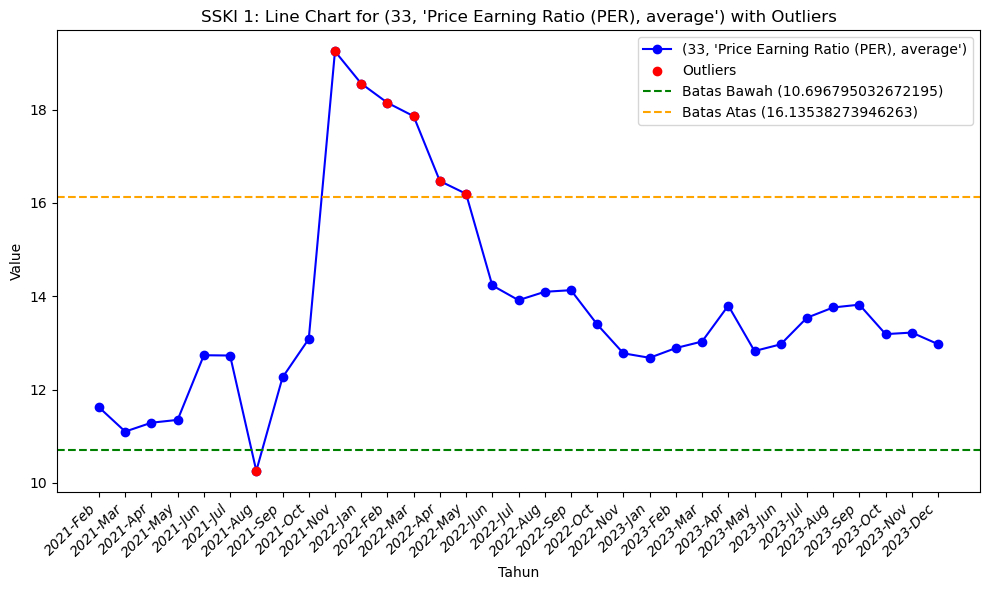

Komponen     Tahun  Nilai Outlier  \
0  (33, Price Earning Ratio (PER), average)  2021-Aug      10.257519   
1  (33, Price Earning Ratio (PER), average)  2021-Nov      19.250429   
2  (33, Price Earning Ratio (PER), average)  2022-Jan      18.560000   
3  (33, Price Earning Ratio (PER), average)  2022-Feb      18.147534   
4  (33, Price Earning Ratio (PER), average)  2022-Mar      17.860000   
5  (33, Price Earning Ratio (PER), average)  2022-Apr      16.470000   
6  (33, Price Earning Ratio (PER), average)  2022-May      16.196501   

   Batas Bawah  Batas Atas  
0    10.696795   16.135383  
1    10.696795   16.135383  
2    10.696795   16.135383  
3    10.696795   16.135383  
4    10.696795   16.135383  
5    10.696795   16.135383  
6    10.696795   16.135383

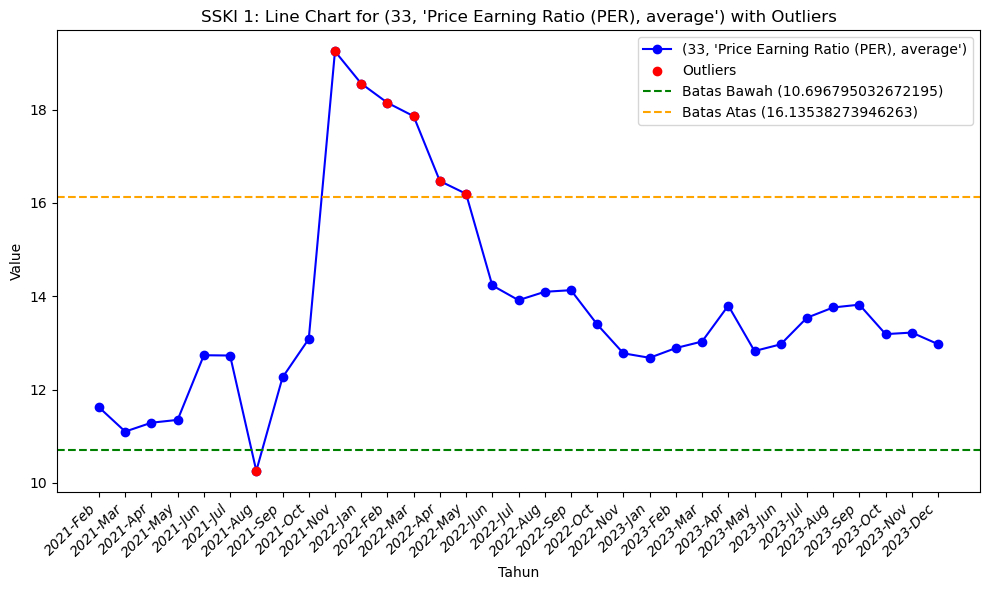

Komponen     Tahun  Nilai Outlier  \
0  (33, Price Earning Ratio (PER), average)  2021-Aug      10.257519   
1  (33, Price Earning Ratio (PER), average)  2021-Nov      19.250429   
2  (33, Price Earning Ratio (PER), average)  2022-Jan      18.560000   
3  (33, Price Earning Ratio (PER), average)  2022-Feb      18.147534   
4  (33, Price Earning Ratio (PER), average)  2022-Mar      17.860000   
5  (33, Price Earning Ratio (PER), average)  2022-Apr      16.470000   
6  (33, Price Earning Ratio (PER), average)  2022-May      16.196501   

   Batas Bawah  Batas Atas  
0    10.696795   16.135383  
1    10.696795   16.135383  
2    10.696795   16.135383  
3    10.696795   16.135383  
4    10.696795   16.135383  
5    10.696795   16.135383  
6    10.696795   16.135383

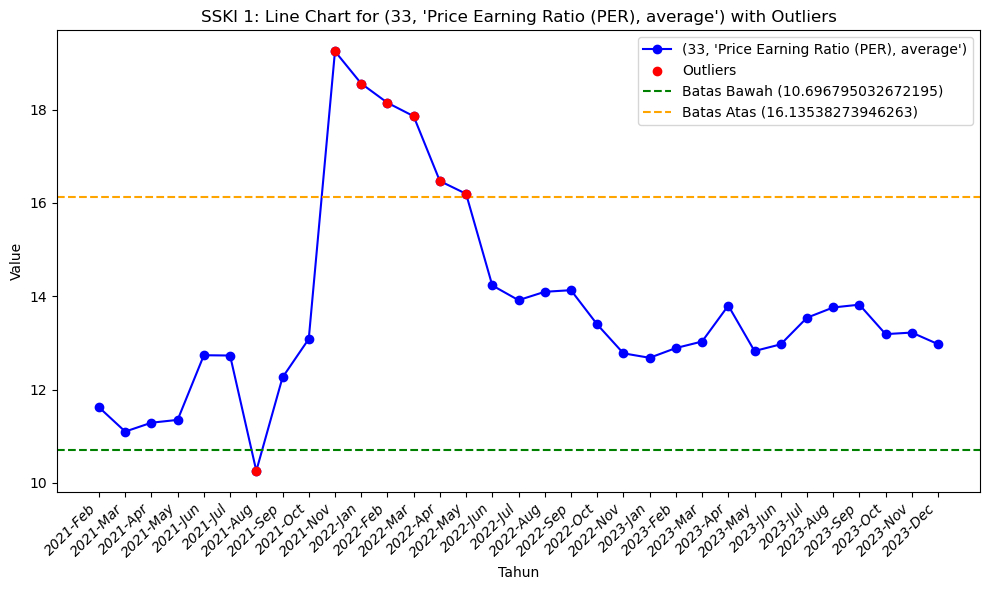

Komponen     Tahun  Nilai Outlier  \
0  (33, Price Earning Ratio (PER), average)  2021-Aug      10.257519   
1  (33, Price Earning Ratio (PER), average)  2021-Nov      19.250429   
2  (33, Price Earning Ratio (PER), average)  2022-Jan      18.560000   
3  (33, Price Earning Ratio (PER), average)  2022-Feb      18.147534   
4  (33, Price Earning Ratio (PER), average)  2022-Mar      17.860000   
5  (33, Price Earning Ratio (PER), average)  2022-Apr      16.470000   
6  (33, Price Earning Ratio (PER), average)  2022-May      16.196501   

   Batas Bawah  Batas Atas  
0    10.696795   16.135383  
1    10.696795   16.135383  
2    10.696795   16.135383  
3    10.696795   16.135383  
4    10.696795   16.135383  
5    10.696795   16.135383  
6    10.696795   16.135383

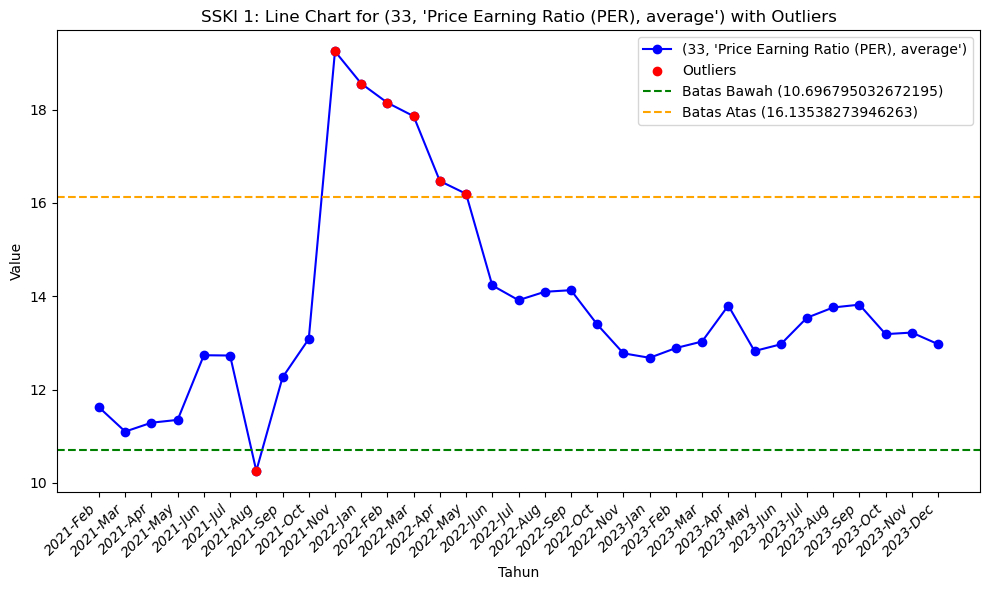

Komponen     Tahun  Nilai Outlier  \
0  (33, Price Earning Ratio (PER), average)  2021-Aug      10.257519   
1  (33, Price Earning Ratio (PER), average)  2021-Nov      19.250429   
2  (33, Price Earning Ratio (PER), average)  2022-Jan      18.560000   
3  (33, Price Earning Ratio (PER), average)  2022-Feb      18.147534   
4  (33, Price Earning Ratio (PER), average)  2022-Mar      17.860000   
5  (33, Price Earning Ratio (PER), average)  2022-Apr      16.470000   
6  (33, Price Earning Ratio (PER), average)  2022-May      16.196501   

   Batas Bawah  Batas Atas  
0    10.696795   16.135383  
1    10.696795   16.135383  
2    10.696795   16.135383  
3    10.696795   16.135383  
4    10.696795   16.135383  
5    10.696795   16.135383  
6    10.696795   16.135383

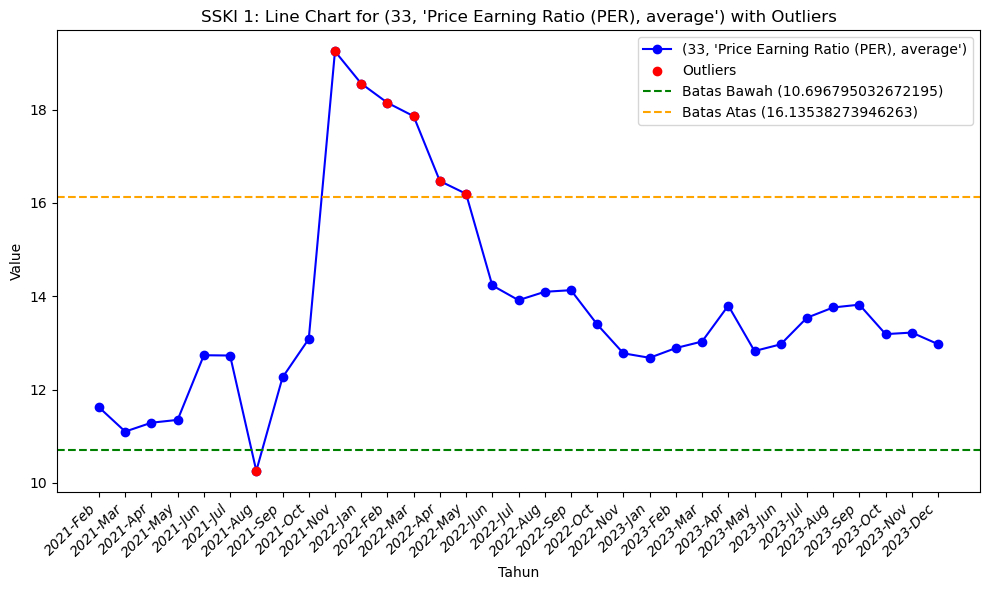

Komponen     Tahun  Nilai Outlier  \
0  (33, Price Earning Ratio (PER), average)  2021-Aug      10.257519   
1  (33, Price Earning Ratio (PER), average)  2021-Nov      19.250429   
2  (33, Price Earning Ratio (PER), average)  2022-Jan      18.560000   
3  (33, Price Earning Ratio (PER), average)  2022-Feb      18.147534   
4  (33, Price Earning Ratio (PER), average)  2022-Mar      17.860000   
5  (33, Price Earning Ratio (PER), average)  2022-Apr      16.470000   
6  (33, Price Earning Ratio (PER), average)  2022-May      16.196501   

   Batas Bawah  Batas Atas  
0    10.696795   16.135383  
1    10.696795   16.135383  
2    10.696795   16.135383  
3    10.696795   16.135383  
4    10.696795   16.135383  
5    10.696795   16.135383  
6    10.696795   16.135383

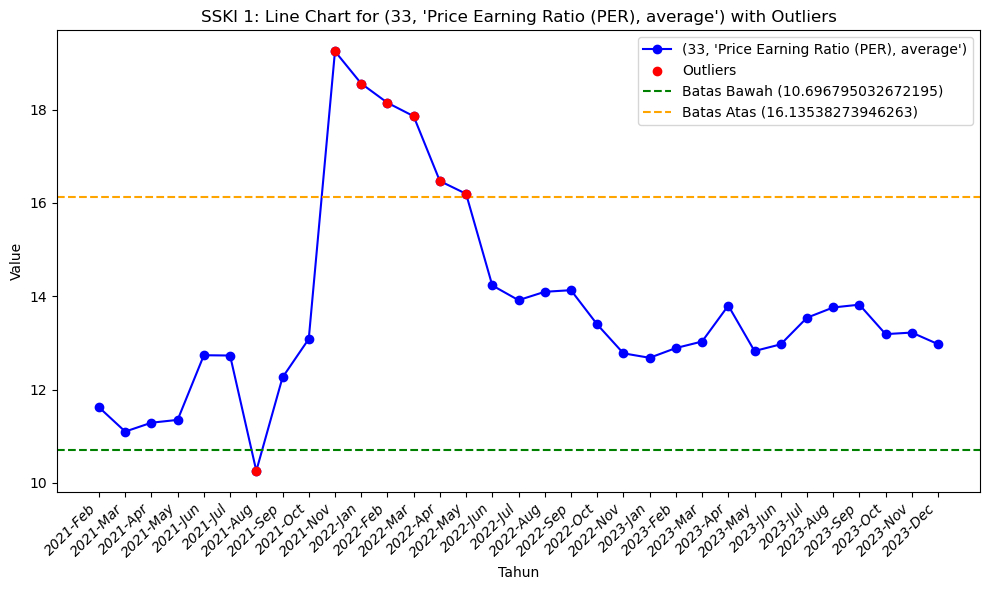

Komponen     Tahun  Nilai Outlier  \
0  (33, Price Earning Ratio (PER), average)  2021-Aug      10.257519   
1  (33, Price Earning Ratio (PER), average)  2021-Nov      19.250429   
2  (33, Price Earning Ratio (PER), average)  2022-Jan      18.560000   
3  (33, Price Earning Ratio (PER), average)  2022-Feb      18.147534   
4  (33, Price Earning Ratio (PER), average)  2022-Mar      17.860000   
5  (33, Price Earning Ratio (PER), average)  2022-Apr      16.470000   
6  (33, Price Earning Ratio (PER), average)  2022-May      16.196501   

   Batas Bawah  Batas Atas  
0    10.696795   16.135383  
1    10.696795   16.135383  
2    10.696795   16.135383  
3    10.696795   16.135383  
4    10.696795   16.135383  
5    10.696795   16.135383  
6    10.696795   16.135383

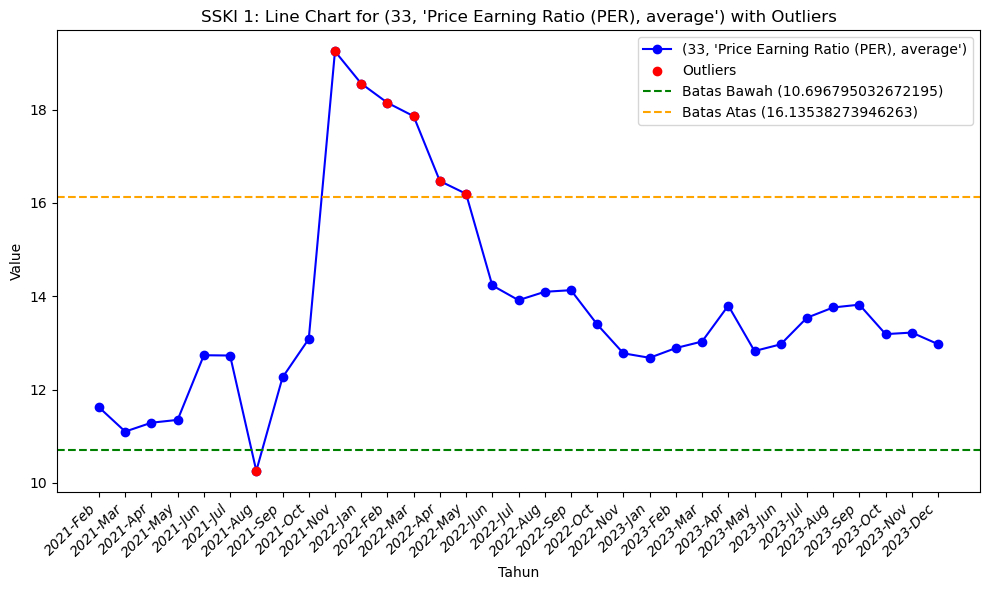

Komponen     Tahun  Nilai Outlier  \
7  (34, Rata-rata Nilai Transaksi Harian Saham)  2022-Apr   18763.650000   
8  (34, Rata-rata Nilai Transaksi Harian Saham)  2022-May   18785.714683   

   Batas Bawah   Batas Atas  
7  6802.552523  18029.63661  
8  6802.552523  18029.63661

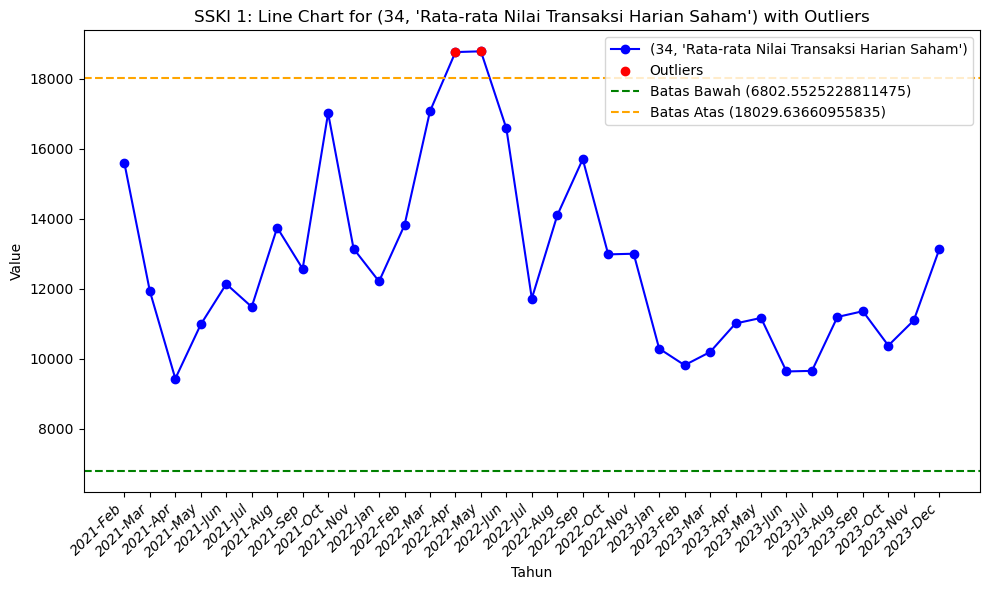

Komponen     Tahun  Nilai Outlier  \
7  (34, Rata-rata Nilai Transaksi Harian Saham)  2022-Apr   18763.650000   
8  (34, Rata-rata Nilai Transaksi Harian Saham)  2022-May   18785.714683   

   Batas Bawah   Batas Atas  
7  6802.552523  18029.63661  
8  6802.552523  18029.63661

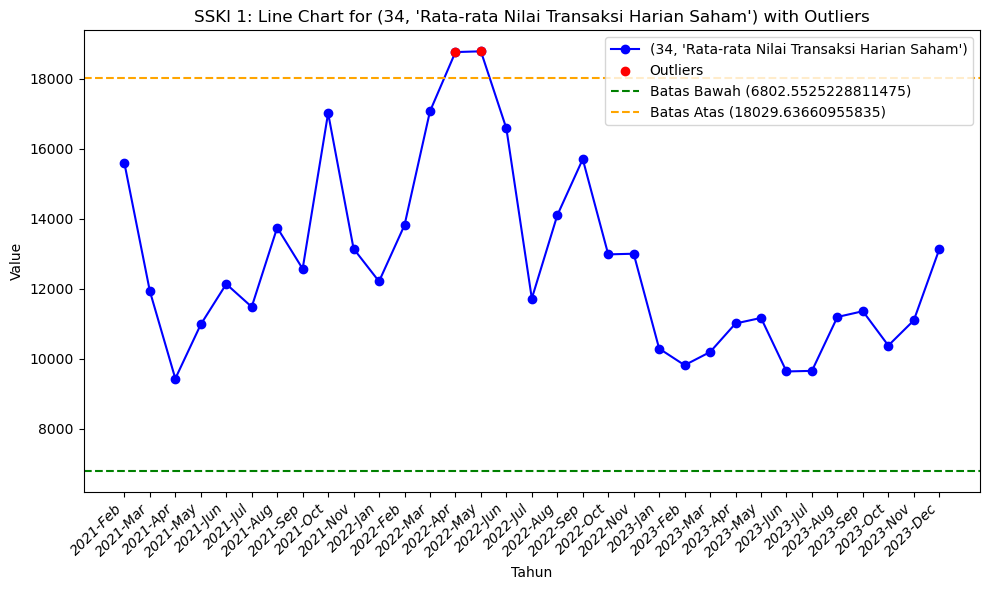

Komponen     Tahun  \
9   (35, Nilai Neto Transaksi Beli Saham oleh Inve...  2022-Apr   
10  (35, Nilai Neto Transaksi Beli Saham oleh Inve...  2023-Aug   

    Nilai Outlier   Batas Bawah    Batas Atas  
9    40117.607012 -16771.261621  19813.399594  
10  -20102.491600 -16771.261621  19813.399594

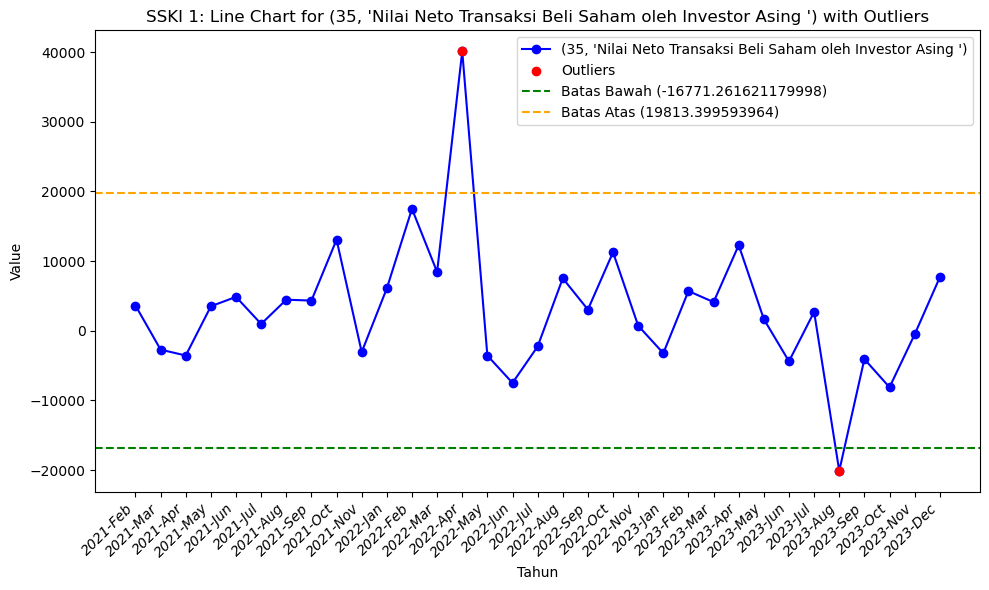

Komponen     Tahun  \
9   (35, Nilai Neto Transaksi Beli Saham oleh Inve...  2022-Apr   
10  (35, Nilai Neto Transaksi Beli Saham oleh Inve...  2023-Aug   

    Nilai Outlier   Batas Bawah    Batas Atas  
9    40117.607012 -16771.261621  19813.399594  
10  -20102.491600 -16771.261621  19813.399594

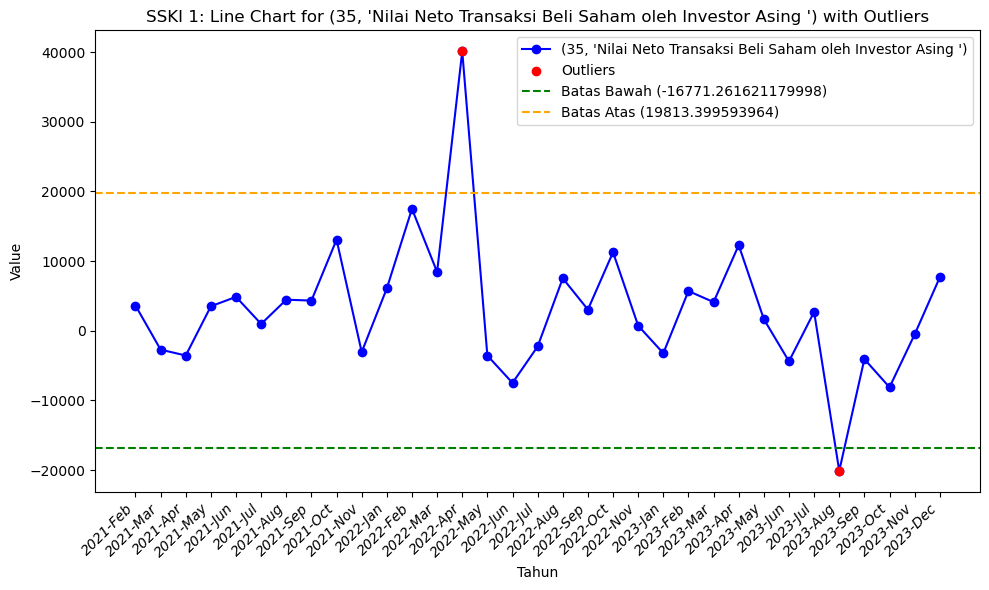

Komponen     Tahun  Nilai Outlier  \
11  (50, Indeks Keyakinan Konsumen (IKK))  2021-Feb      85.824723   
12  (50, Indeks Keyakinan Konsumen (IKK))  2021-Jul      80.197409   
13  (50, Indeks Keyakinan Konsumen (IKK))  2021-Aug      77.313178   

    Batas Bawah  Batas Atas  
11    91.819906  142.944359  
12    91.819906  142.944359  
13    91.819906  142.944359

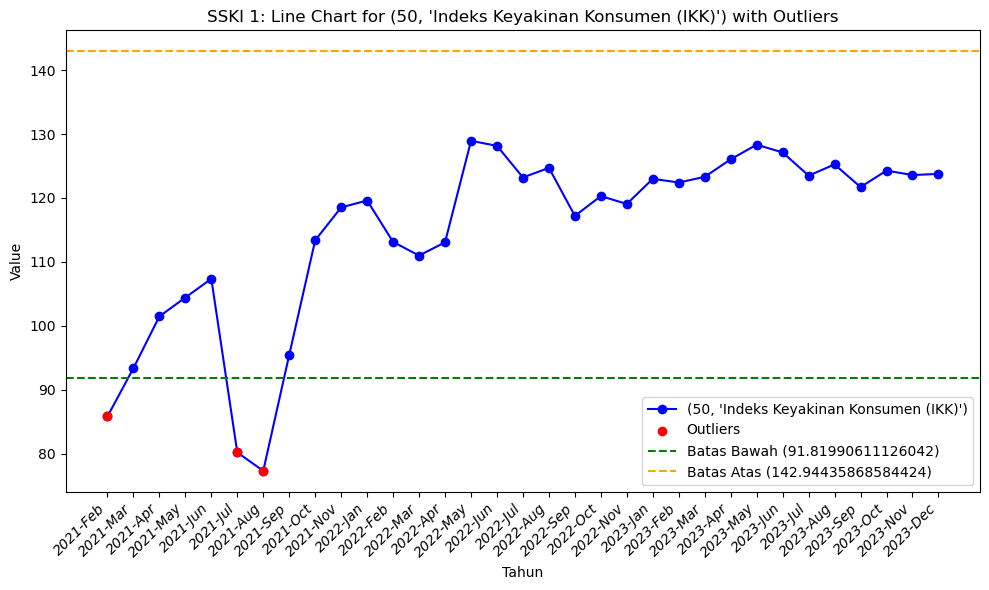

Komponen     Tahun  Nilai Outlier  \
11  (50, Indeks Keyakinan Konsumen (IKK))  2021-Feb      85.824723   
12  (50, Indeks Keyakinan Konsumen (IKK))  2021-Jul      80.197409   
13  (50, Indeks Keyakinan Konsumen (IKK))  2021-Aug      77.313178   

    Batas Bawah  Batas Atas  
11    91.819906  142.944359  
12    91.819906  142.944359  
13    91.819906  142.944359

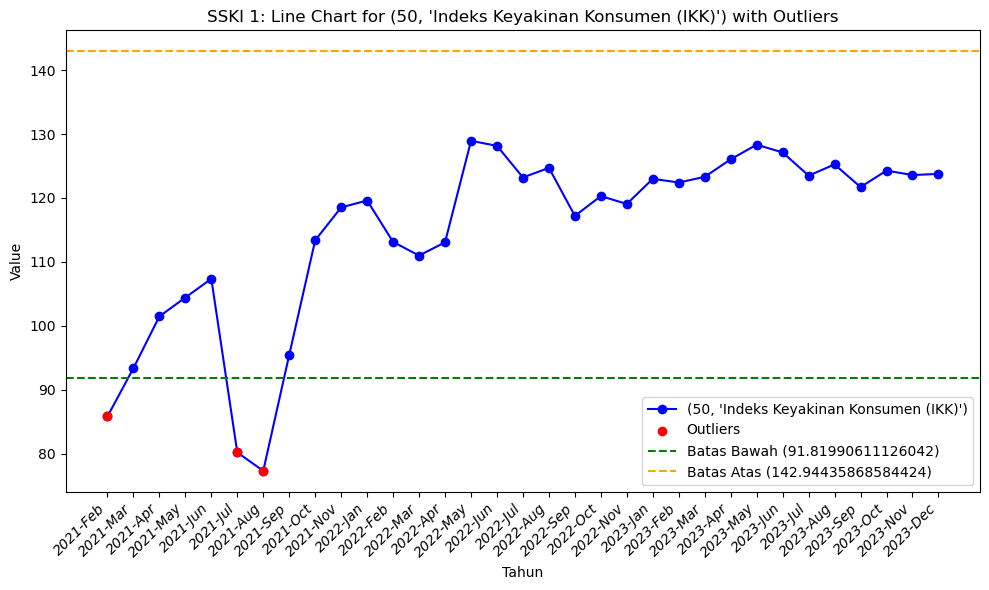

Komponen     Tahun  Nilai Outlier  \
11  (50, Indeks Keyakinan Konsumen (IKK))  2021-Feb      85.824723   
12  (50, Indeks Keyakinan Konsumen (IKK))  2021-Jul      80.197409   
13  (50, Indeks Keyakinan Konsumen (IKK))  2021-Aug      77.313178   

    Batas Bawah  Batas Atas  
11    91.819906  142.944359  
12    91.819906  142.944359  
13    91.819906  142.944359

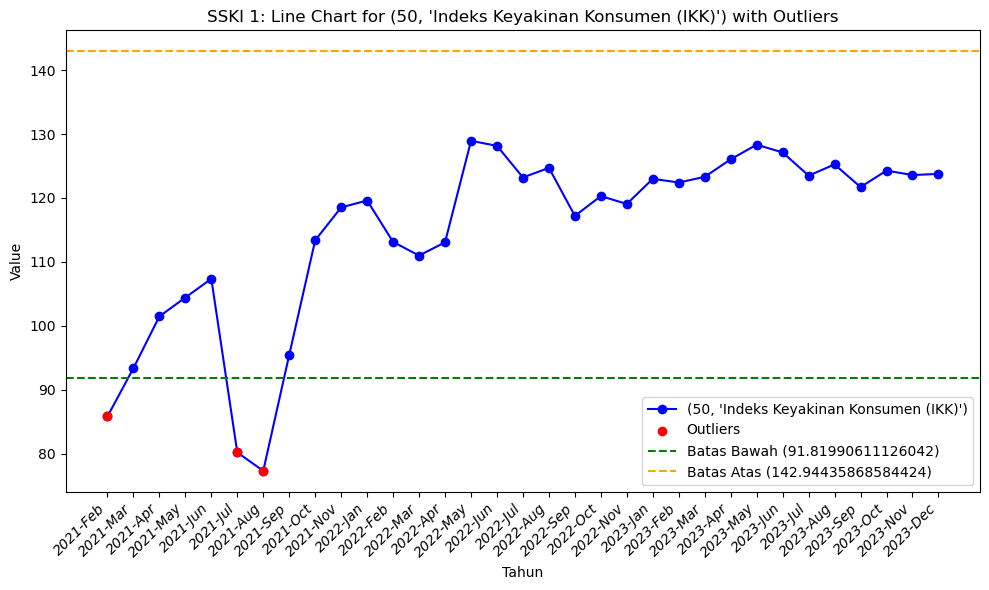

Processing SSKI 2...


C:\Users\Cindy\AppData\Local\Temp\ipykernel_3748\3768459282.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_df.replace('-', np.nan, inplace=True)
C:\Users\Cindy\AppData\Local\Temp\ipykernel_3748\3768459282.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.replace('-', np.nan, inplace=True)
C:\Users\Cindy\AppData\Local\Temp\ipykernel_3748\3392358751.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 0 if isinstance(x, str) else x)


Komponen     Tahun  Nilai Outlier  Batas Bawah  Batas Atas
0  (27, China)  2022-Oct         125.19      4.56975   114.54775

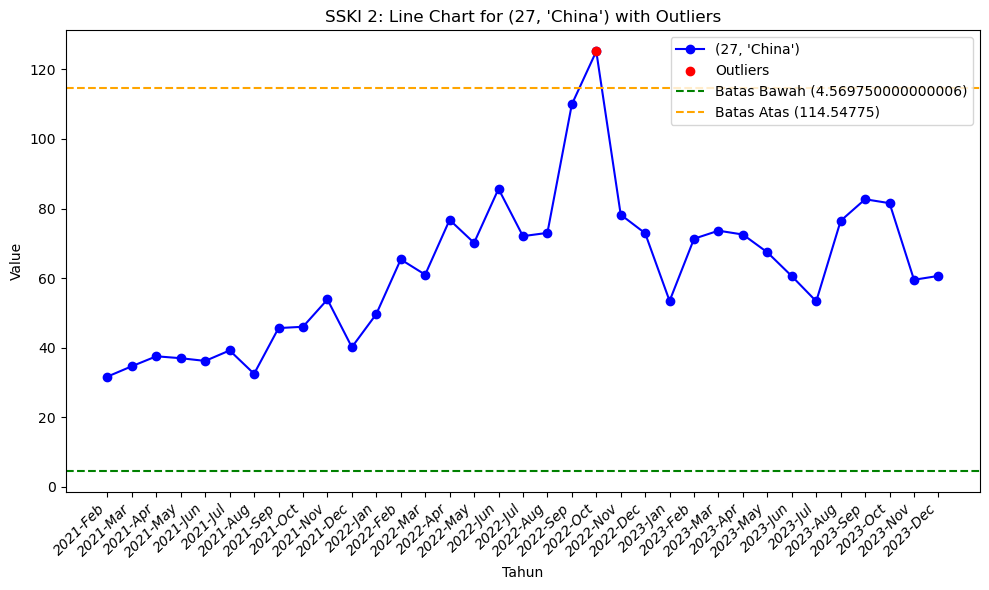

Komponen     Tahun  Nilai Outlier  Batas Bawah  Batas Atas
1  (28, Malaysia)  2022-Sep        121.449      5.01225   113.73025

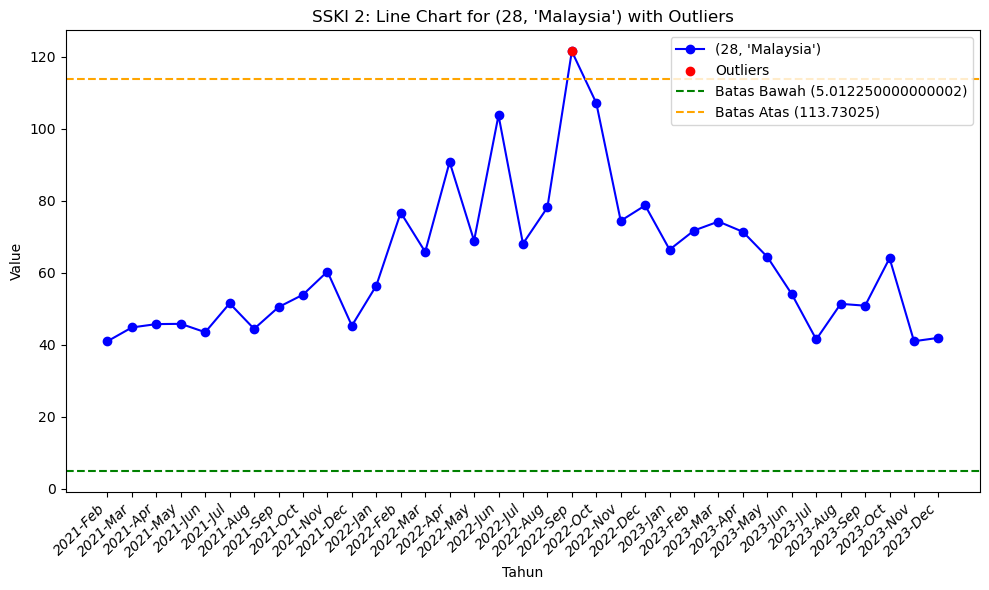

Komponen     Tahun  Nilai Outlier  Batas Bawah  Batas Atas
2  (29, Thailand)  2022-Sep         90.592     18.79025    73.73625
3  (29, Thailand)  2022-Oct         87.720     18.79025    73.73625

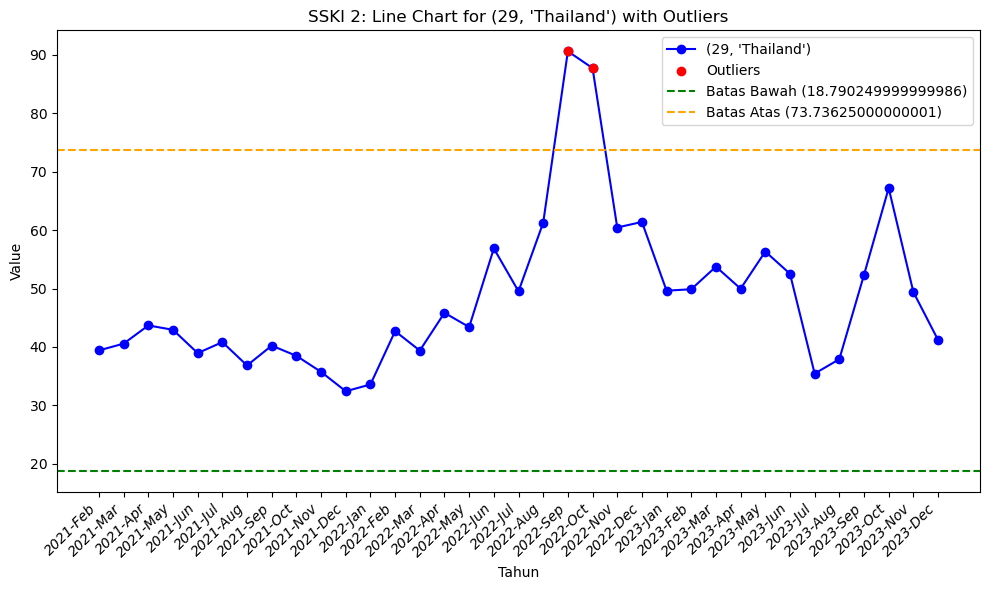

Komponen     Tahun  Nilai Outlier  Batas Bawah  Batas Atas
2  (29, Thailand)  2022-Sep         90.592     18.79025    73.73625
3  (29, Thailand)  2022-Oct         87.720     18.79025    73.73625

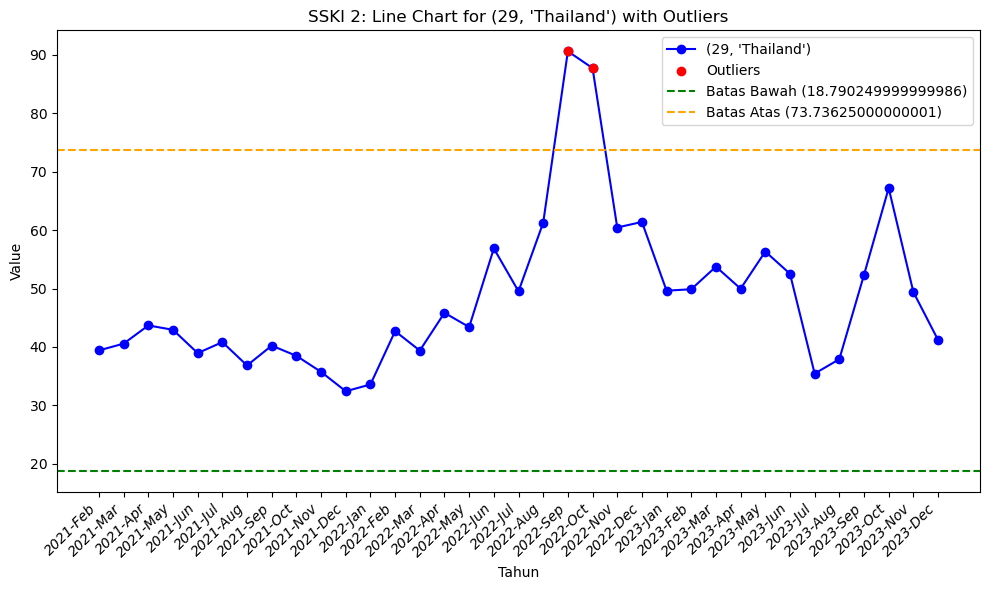

Komponen     Tahun  Nilai Outlier  Batas Bawah  \
4  (32, Minyak Kelapa Sawit)  2022-Mar     1652.52913   378.663295   

    Batas Atas  
4  1617.299841

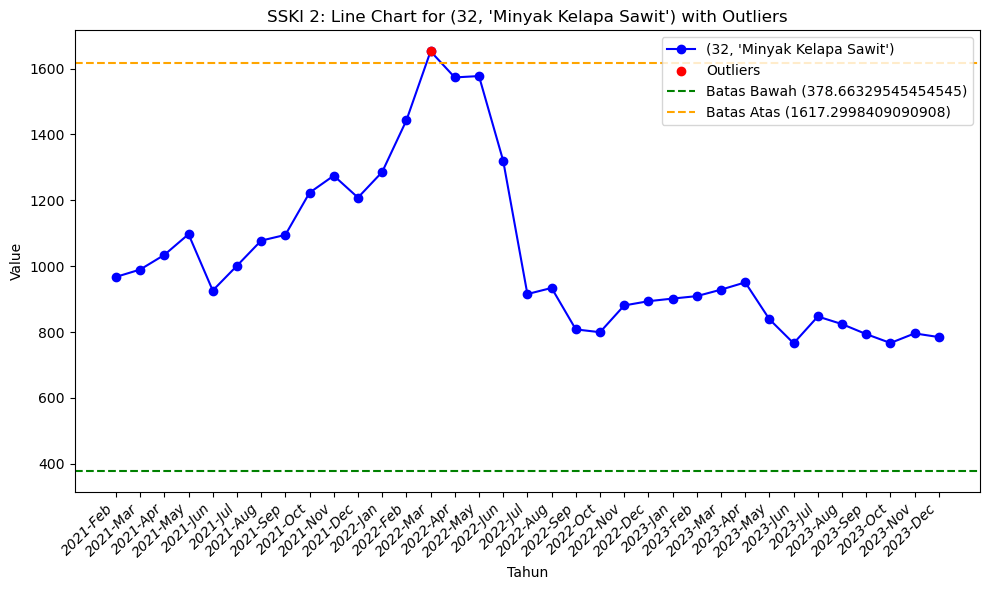

Komponen     Tahun  Nilai Outlier  \
5  (33, Minyak West Texas Intermediate (WTI))  2022-May     109.604762   
6  (33, Minyak West Texas Intermediate (WTI))  2022-Jun     114.586190   

   Batas Bawah  Batas Atas  
5    49.329973  108.661185  
6    49.329973  108.661185

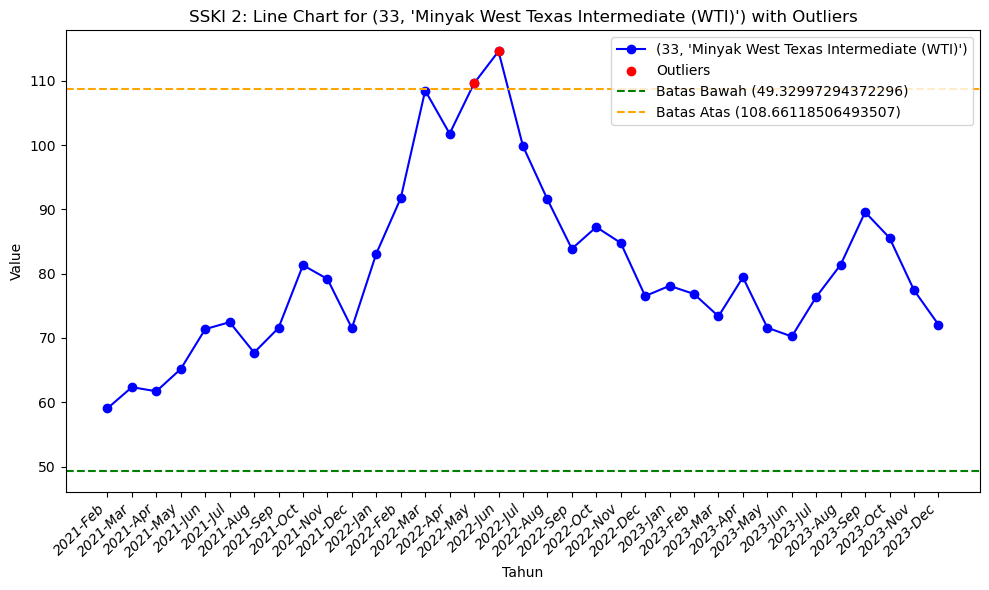

Komponen     Tahun  Nilai Outlier  \
5  (33, Minyak West Texas Intermediate (WTI))  2022-May     109.604762   
6  (33, Minyak West Texas Intermediate (WTI))  2022-Jun     114.586190   

   Batas Bawah  Batas Atas  
5    49.329973  108.661185  
6    49.329973  108.661185

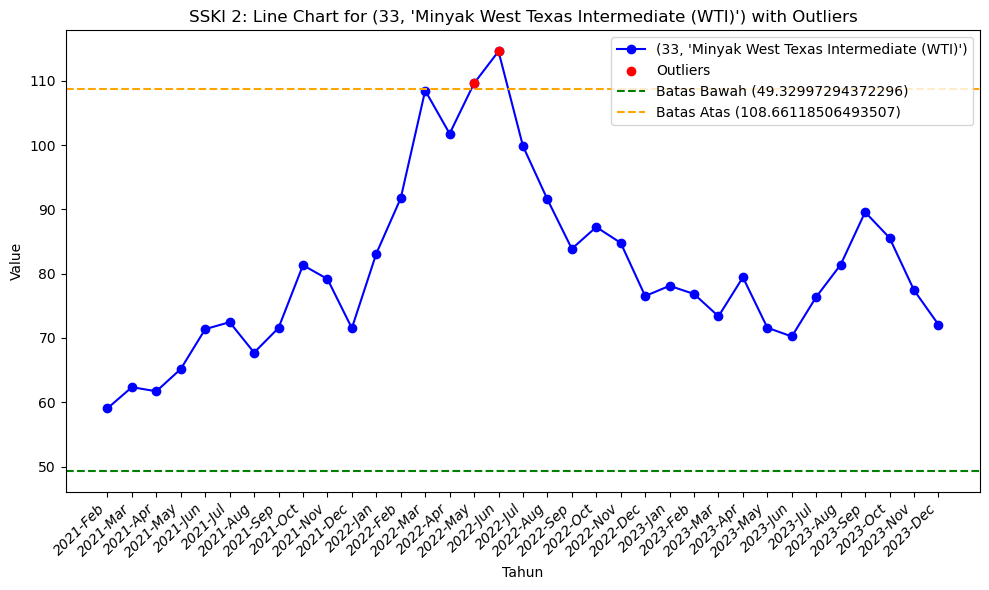

Komponen     Tahun  Nilai Outlier  Batas Bawah  Batas Atas
7  (46, Inflasi (mtm))  2022-Sep           1.17     -0.48655    1.050916

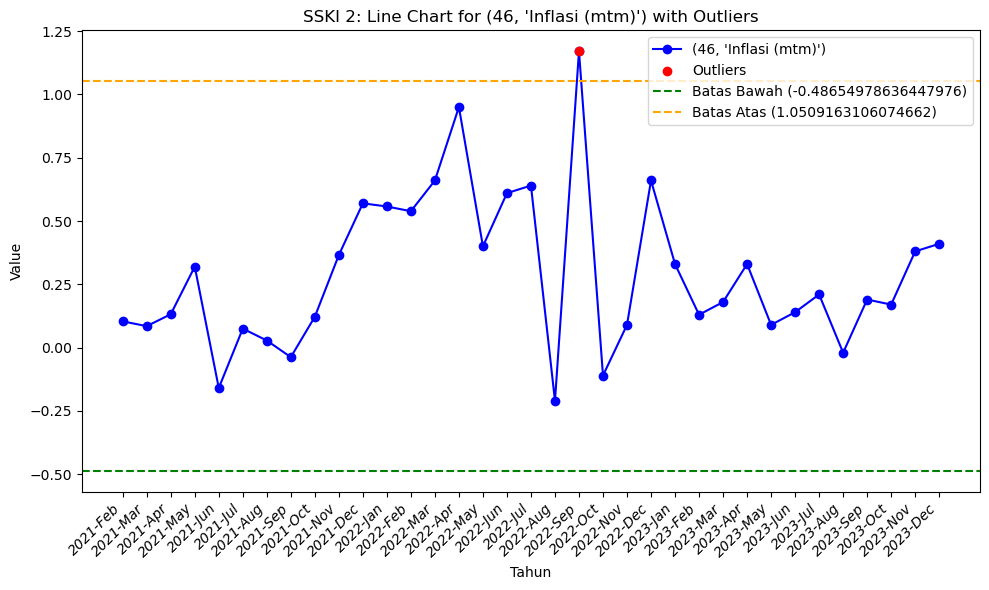

Komponen     Tahun  \
8   (84, Credit Default Swap (CDS) Indonesia tenor...  2022-Jun   
9   (84, Credit Default Swap (CDS) Indonesia tenor...  2022-Sep   
10  (84, Credit Default Swap (CDS) Indonesia tenor...  2022-Oct   

    Nilai Outlier  Batas Bawah  Batas Atas  
8         144.178      51.4405    125.1765  
9         160.381      51.4405    125.1765  
10        138.420      51.4405    125.1765

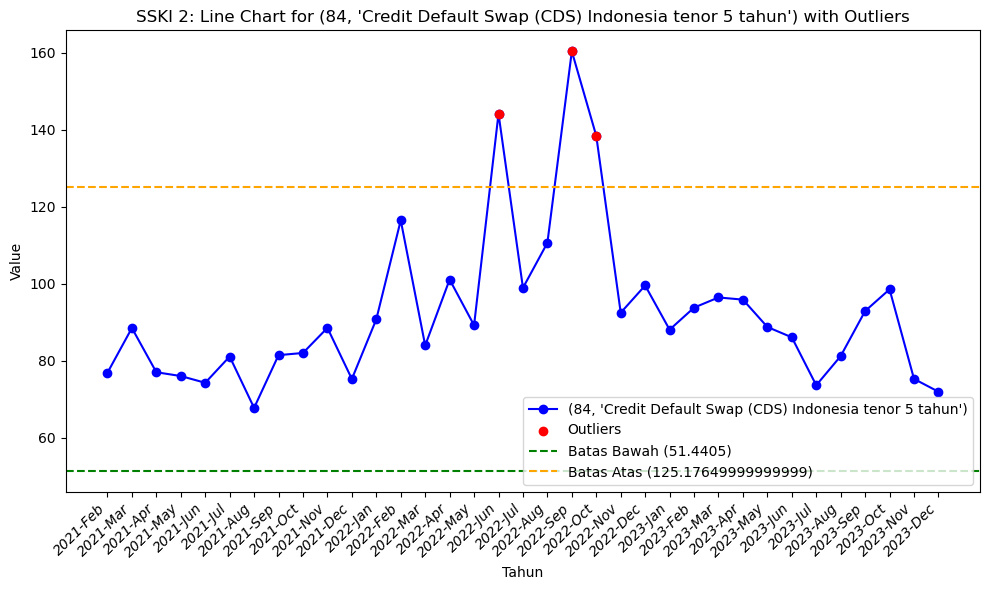

Komponen     Tahun  \
8   (84, Credit Default Swap (CDS) Indonesia tenor...  2022-Jun   
9   (84, Credit Default Swap (CDS) Indonesia tenor...  2022-Sep   
10  (84, Credit Default Swap (CDS) Indonesia tenor...  2022-Oct   

    Nilai Outlier  Batas Bawah  Batas Atas  
8         144.178      51.4405    125.1765  
9         160.381      51.4405    125.1765  
10        138.420      51.4405    125.1765

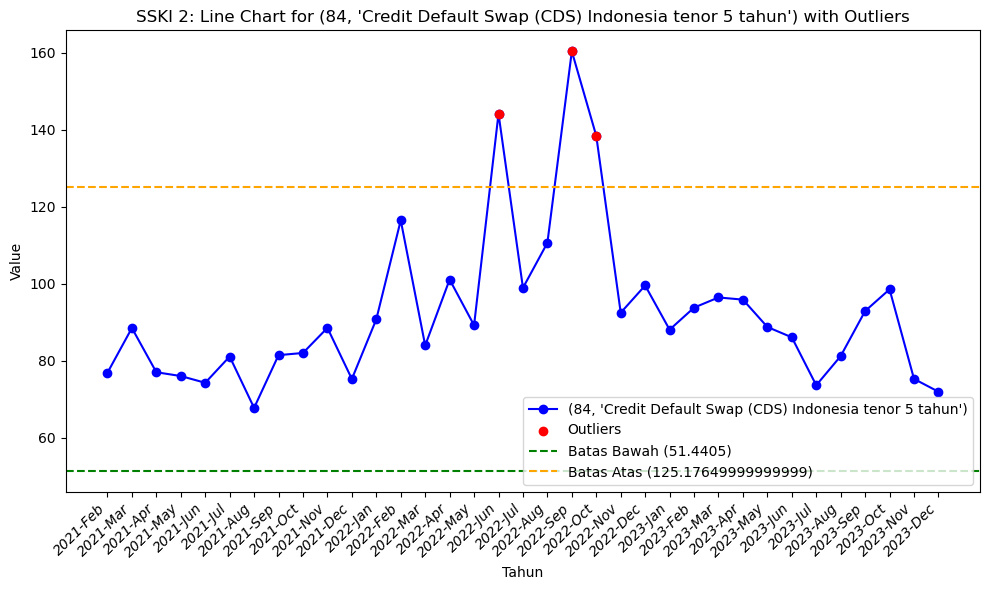

Komponen     Tahun  \
8   (84, Credit Default Swap (CDS) Indonesia tenor...  2022-Jun   
9   (84, Credit Default Swap (CDS) Indonesia tenor...  2022-Sep   
10  (84, Credit Default Swap (CDS) Indonesia tenor...  2022-Oct   

    Nilai Outlier  Batas Bawah  Batas Atas  
8         144.178      51.4405    125.1765  
9         160.381      51.4405    125.1765  
10        138.420      51.4405    125.1765

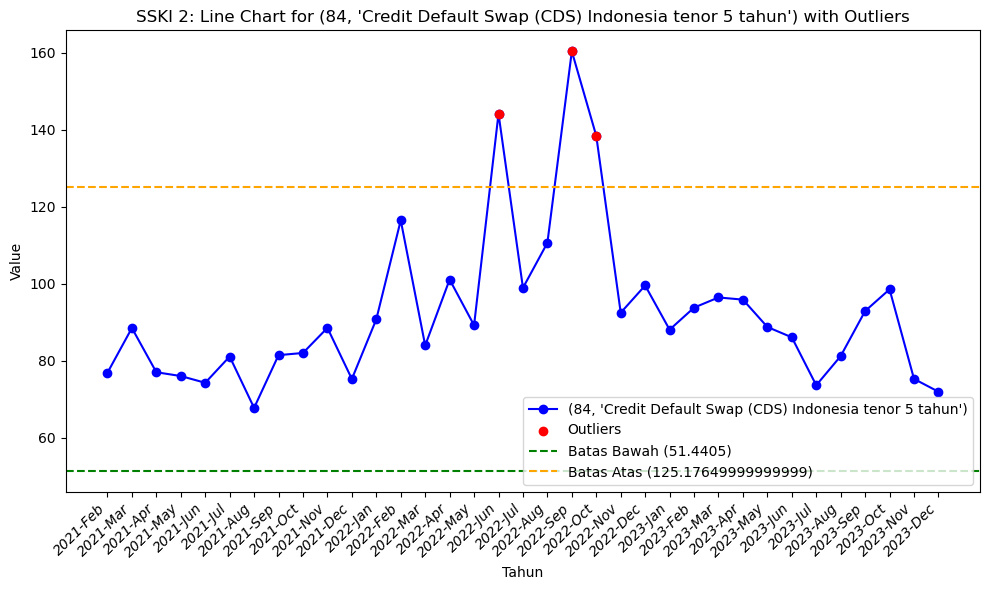

Komponen     Tahun  Nilai Outlier  \
11  (87, Utang Jangka Pendek (≤ 1  Tahun))  2022-Jan   57174.999393   

     Batas Bawah    Batas Atas  
11  57675.060737  72971.861323

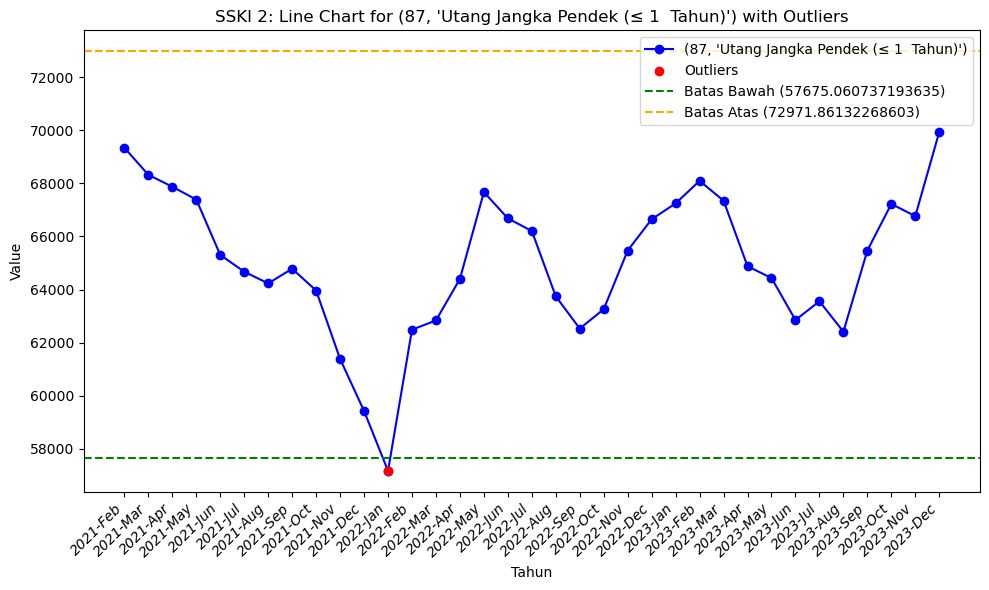

Komponen     Tahun  Nilai Outlier  Batas Bawah    Batas Atas
12  (92, Bank Sentral)  2021-Feb    2882.700038  7189.941645  10534.444372
13  (92, Bank Sentral)  2021-Mar    2823.110121  7189.941645  10534.444372
14  (92, Bank Sentral)  2021-Apr    2864.510176  7189.941645  10534.444372
15  (92, Bank Sentral)  2021-May    2869.641274  7189.941645  10534.444372
16  (92, Bank Sentral)  2021-Jun    2836.328886  7189.941645  10534.444372
17  (92, Bank Sentral)  2021-Jul    2837.658282  7189.941645  10534.444372
18  (92, Bank Sentral)  2023-Nov   12079.872382  7189.941645  10534.444372
19  (92, Bank Sentral)  2023-Dec   13434.425373  7189.941645  10534.444372

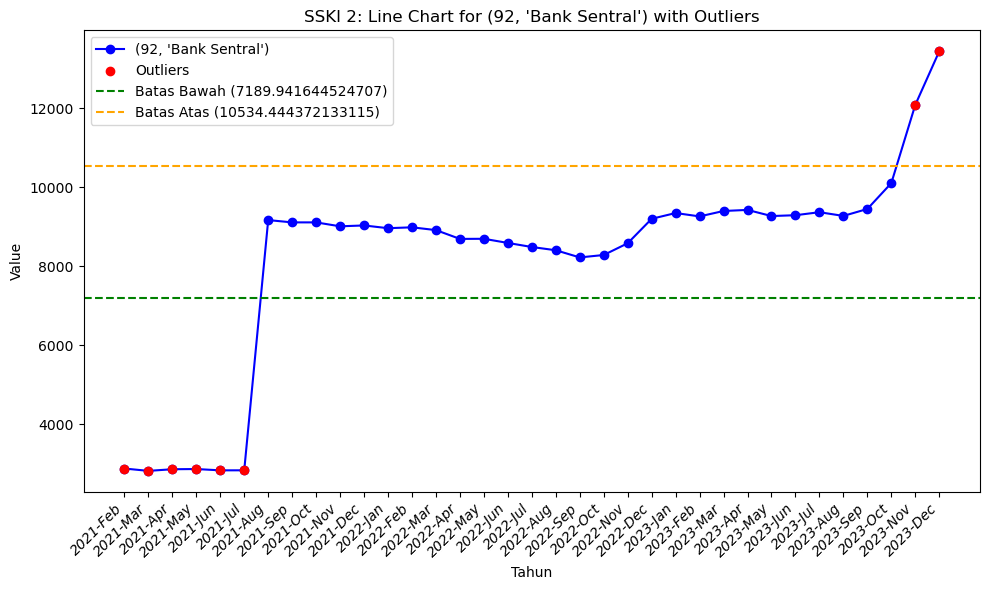

Komponen     Tahun  Nilai Outlier  Batas Bawah    Batas Atas
12  (92, Bank Sentral)  2021-Feb    2882.700038  7189.941645  10534.444372
13  (92, Bank Sentral)  2021-Mar    2823.110121  7189.941645  10534.444372
14  (92, Bank Sentral)  2021-Apr    2864.510176  7189.941645  10534.444372
15  (92, Bank Sentral)  2021-May    2869.641274  7189.941645  10534.444372
16  (92, Bank Sentral)  2021-Jun    2836.328886  7189.941645  10534.444372
17  (92, Bank Sentral)  2021-Jul    2837.658282  7189.941645  10534.444372
18  (92, Bank Sentral)  2023-Nov   12079.872382  7189.941645  10534.444372
19  (92, Bank Sentral)  2023-Dec   13434.425373  7189.941645  10534.444372

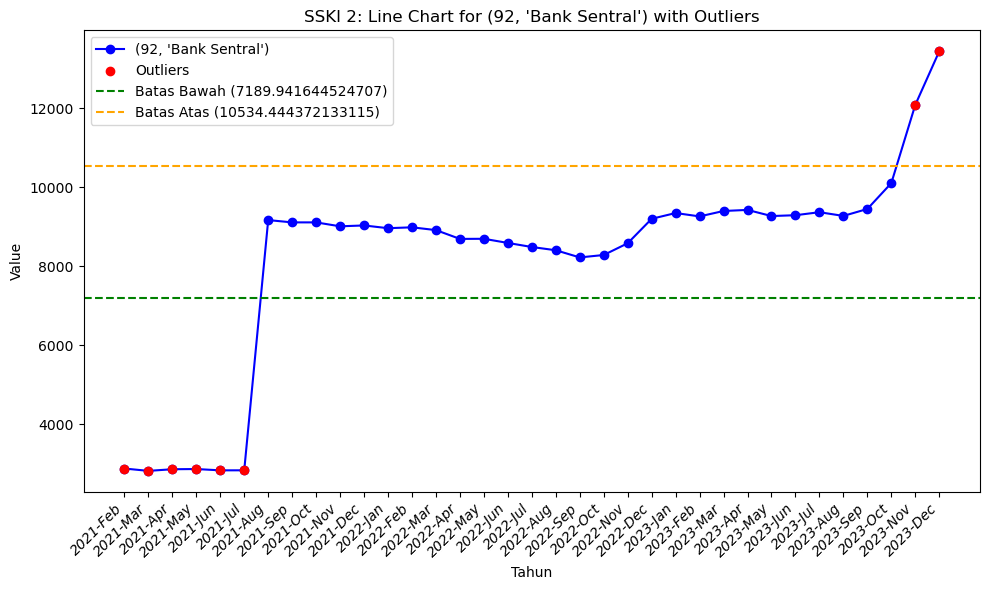

Komponen     Tahun  Nilai Outlier  Batas Bawah    Batas Atas
12  (92, Bank Sentral)  2021-Feb    2882.700038  7189.941645  10534.444372
13  (92, Bank Sentral)  2021-Mar    2823.110121  7189.941645  10534.444372
14  (92, Bank Sentral)  2021-Apr    2864.510176  7189.941645  10534.444372
15  (92, Bank Sentral)  2021-May    2869.641274  7189.941645  10534.444372
16  (92, Bank Sentral)  2021-Jun    2836.328886  7189.941645  10534.444372
17  (92, Bank Sentral)  2021-Jul    2837.658282  7189.941645  10534.444372
18  (92, Bank Sentral)  2023-Nov   12079.872382  7189.941645  10534.444372
19  (92, Bank Sentral)  2023-Dec   13434.425373  7189.941645  10534.444372

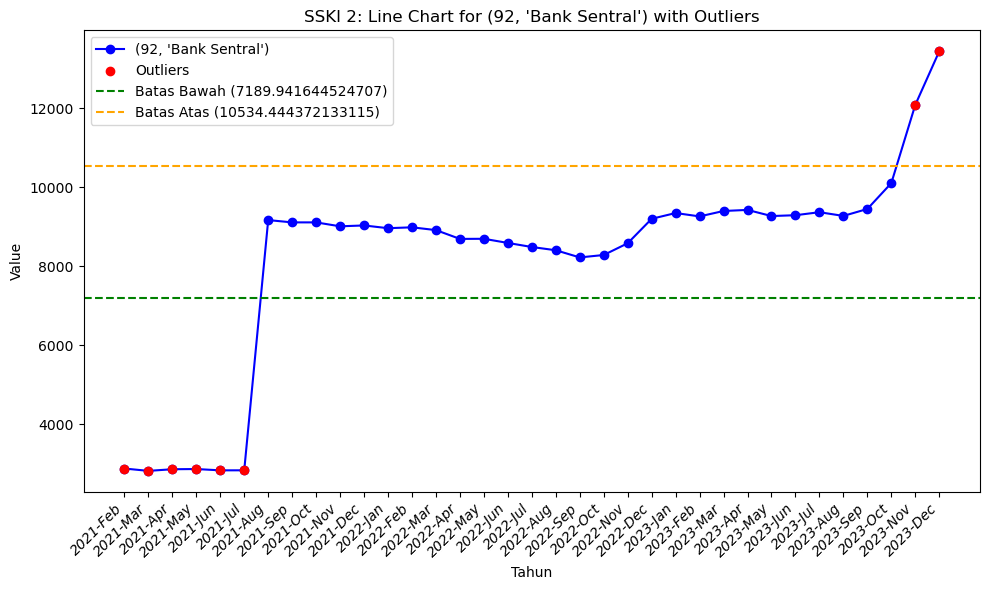

Komponen     Tahun  Nilai Outlier  Batas Bawah    Batas Atas
12  (92, Bank Sentral)  2021-Feb    2882.700038  7189.941645  10534.444372
13  (92, Bank Sentral)  2021-Mar    2823.110121  7189.941645  10534.444372
14  (92, Bank Sentral)  2021-Apr    2864.510176  7189.941645  10534.444372
15  (92, Bank Sentral)  2021-May    2869.641274  7189.941645  10534.444372
16  (92, Bank Sentral)  2021-Jun    2836.328886  7189.941645  10534.444372
17  (92, Bank Sentral)  2021-Jul    2837.658282  7189.941645  10534.444372
18  (92, Bank Sentral)  2023-Nov   12079.872382  7189.941645  10534.444372
19  (92, Bank Sentral)  2023-Dec   13434.425373  7189.941645  10534.444372

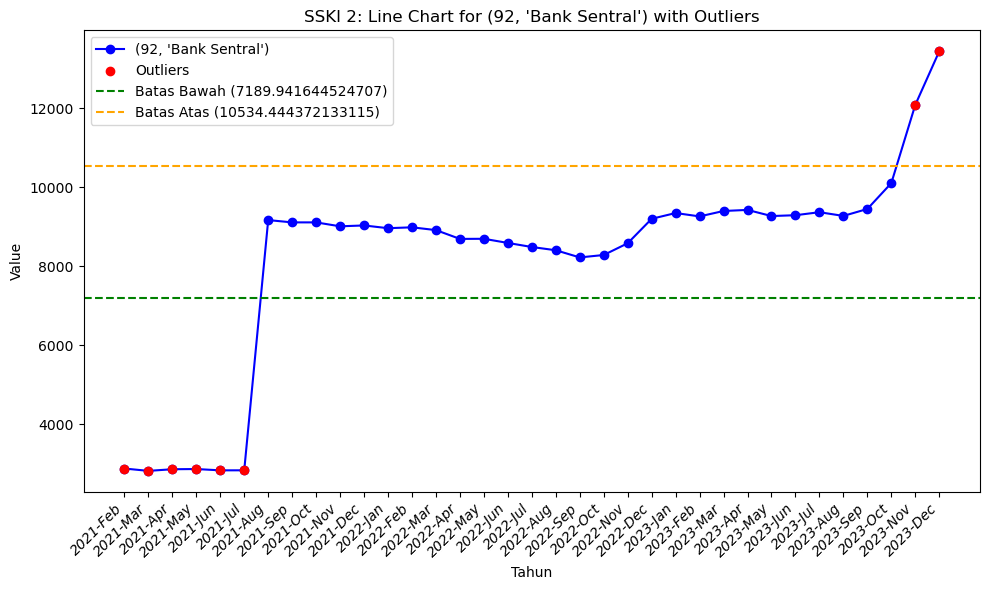

Komponen     Tahun  Nilai Outlier  Batas Bawah    Batas Atas
12  (92, Bank Sentral)  2021-Feb    2882.700038  7189.941645  10534.444372
13  (92, Bank Sentral)  2021-Mar    2823.110121  7189.941645  10534.444372
14  (92, Bank Sentral)  2021-Apr    2864.510176  7189.941645  10534.444372
15  (92, Bank Sentral)  2021-May    2869.641274  7189.941645  10534.444372
16  (92, Bank Sentral)  2021-Jun    2836.328886  7189.941645  10534.444372
17  (92, Bank Sentral)  2021-Jul    2837.658282  7189.941645  10534.444372
18  (92, Bank Sentral)  2023-Nov   12079.872382  7189.941645  10534.444372
19  (92, Bank Sentral)  2023-Dec   13434.425373  7189.941645  10534.444372

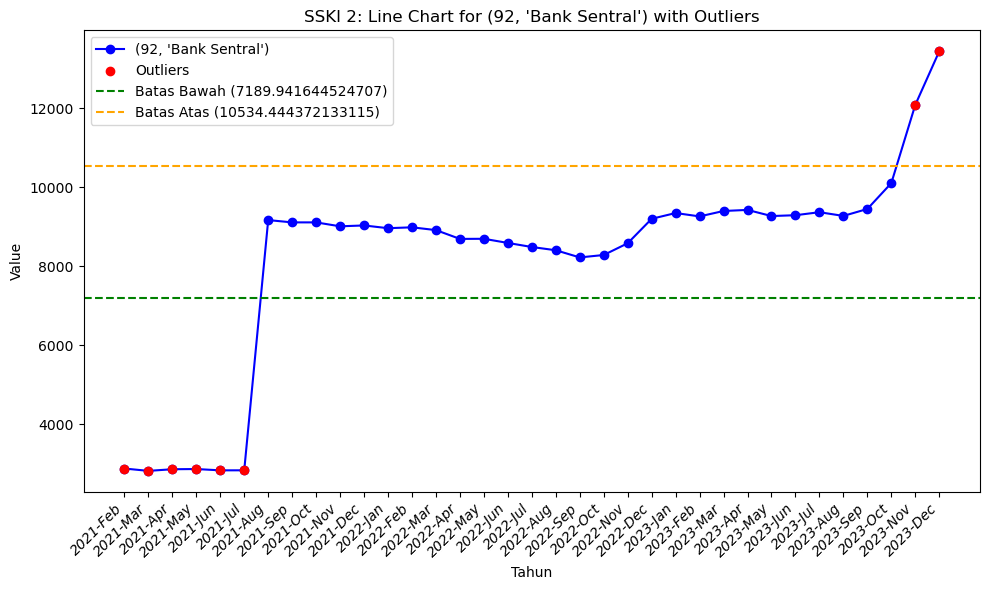

Komponen     Tahun  Nilai Outlier  Batas Bawah    Batas Atas
12  (92, Bank Sentral)  2021-Feb    2882.700038  7189.941645  10534.444372
13  (92, Bank Sentral)  2021-Mar    2823.110121  7189.941645  10534.444372
14  (92, Bank Sentral)  2021-Apr    2864.510176  7189.941645  10534.444372
15  (92, Bank Sentral)  2021-May    2869.641274  7189.941645  10534.444372
16  (92, Bank Sentral)  2021-Jun    2836.328886  7189.941645  10534.444372
17  (92, Bank Sentral)  2021-Jul    2837.658282  7189.941645  10534.444372
18  (92, Bank Sentral)  2023-Nov   12079.872382  7189.941645  10534.444372
19  (92, Bank Sentral)  2023-Dec   13434.425373  7189.941645  10534.444372

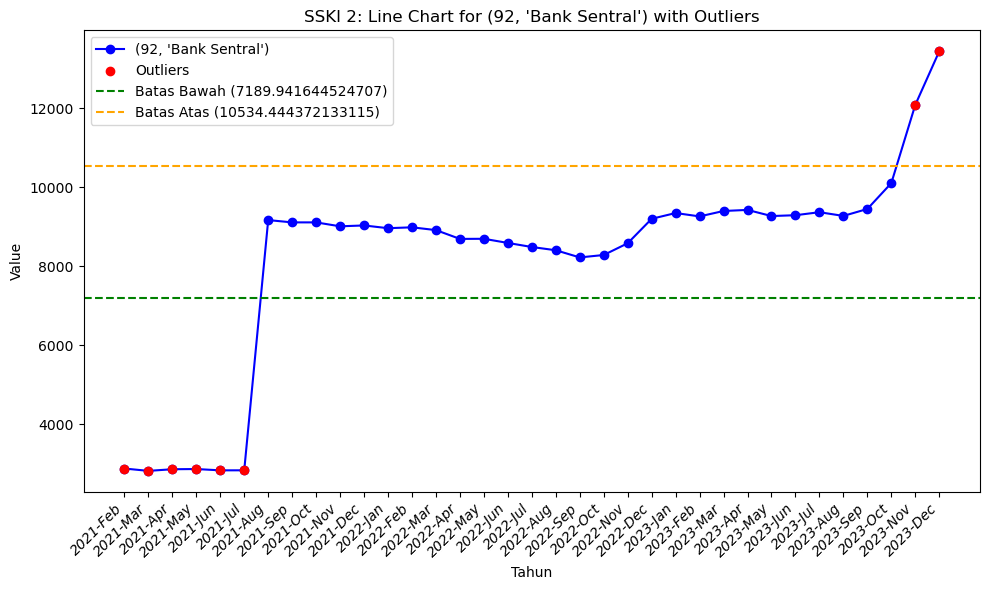

Komponen     Tahun  Nilai Outlier  Batas Bawah    Batas Atas
12  (92, Bank Sentral)  2021-Feb    2882.700038  7189.941645  10534.444372
13  (92, Bank Sentral)  2021-Mar    2823.110121  7189.941645  10534.444372
14  (92, Bank Sentral)  2021-Apr    2864.510176  7189.941645  10534.444372
15  (92, Bank Sentral)  2021-May    2869.641274  7189.941645  10534.444372
16  (92, Bank Sentral)  2021-Jun    2836.328886  7189.941645  10534.444372
17  (92, Bank Sentral)  2021-Jul    2837.658282  7189.941645  10534.444372
18  (92, Bank Sentral)  2023-Nov   12079.872382  7189.941645  10534.444372
19  (92, Bank Sentral)  2023-Dec   13434.425373  7189.941645  10534.444372

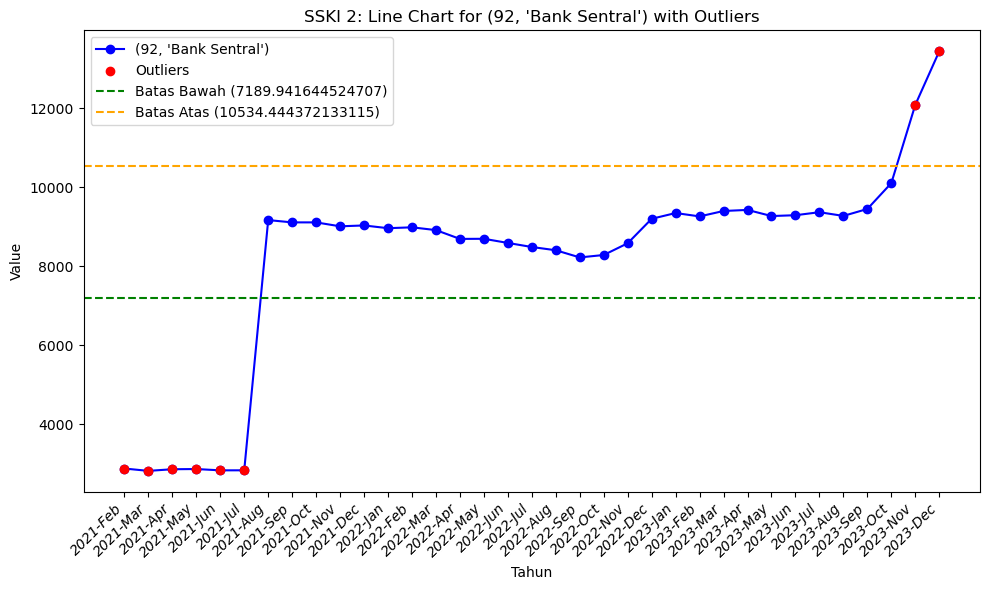

Komponen     Tahun  Nilai Outlier  Batas Bawah    Batas Atas
12  (92, Bank Sentral)  2021-Feb    2882.700038  7189.941645  10534.444372
13  (92, Bank Sentral)  2021-Mar    2823.110121  7189.941645  10534.444372
14  (92, Bank Sentral)  2021-Apr    2864.510176  7189.941645  10534.444372
15  (92, Bank Sentral)  2021-May    2869.641274  7189.941645  10534.444372
16  (92, Bank Sentral)  2021-Jun    2836.328886  7189.941645  10534.444372
17  (92, Bank Sentral)  2021-Jul    2837.658282  7189.941645  10534.444372
18  (92, Bank Sentral)  2023-Nov   12079.872382  7189.941645  10534.444372
19  (92, Bank Sentral)  2023-Dec   13434.425373  7189.941645  10534.444372

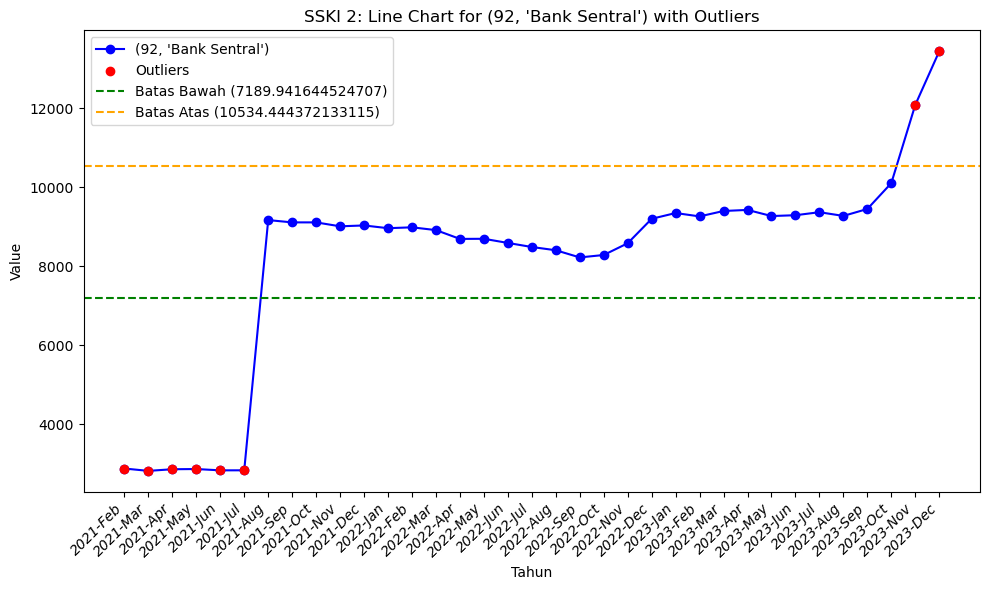

Komponen     Tahun  Nilai Outlier  \
20  (93, Utang Jangka Pendek (≤ 1  Tahun))  2023-Nov    3686.863910   
21  (93, Utang Jangka Pendek (≤ 1  Tahun))  2023-Dec    5115.566467   

    Batas Bawah   Batas Atas  
20 -1388.790906  2355.355538  
21 -1388.790906  2355.355538

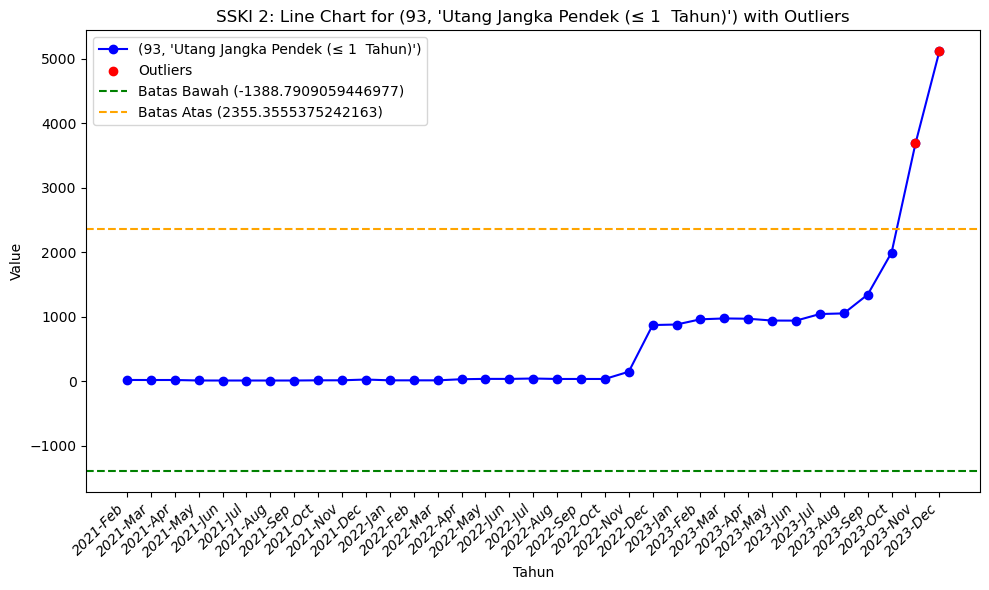

Komponen     Tahun  Nilai Outlier  \
20  (93, Utang Jangka Pendek (≤ 1  Tahun))  2023-Nov    3686.863910   
21  (93, Utang Jangka Pendek (≤ 1  Tahun))  2023-Dec    5115.566467   

    Batas Bawah   Batas Atas  
20 -1388.790906  2355.355538  
21 -1388.790906  2355.355538

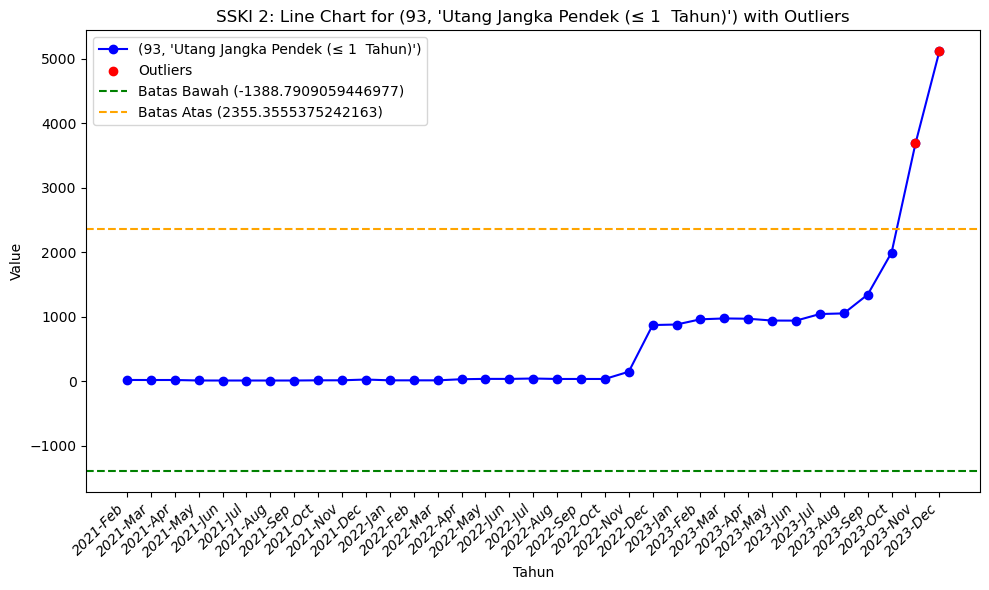

Komponen     Tahun  Nilai Outlier  \
22  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Feb    2862.205977   
23  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Mar    2803.268371   
24  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Apr    2844.520048   
25  (94, Utang Jangka Panjang (> 1  Tahun))  2021-May    2857.195323   
26  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Jun    2824.276656   
27  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Jul    2825.662252   

    Batas Bawah   Batas Atas  
22  7520.522526  9338.327726  
23  7520.522526  9338.327726  
24  7520.522526  9338.327726  
25  7520.522526  9338.327726  
26  7520.522526  9338.327726  
27  7520.522526  9338.327726

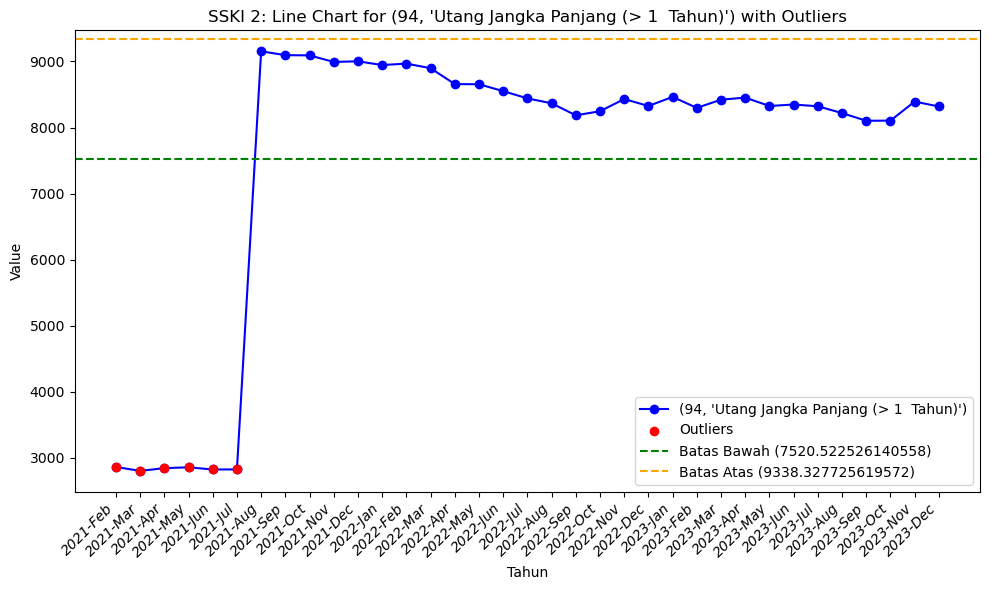

Komponen     Tahun  Nilai Outlier  \
22  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Feb    2862.205977   
23  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Mar    2803.268371   
24  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Apr    2844.520048   
25  (94, Utang Jangka Panjang (> 1  Tahun))  2021-May    2857.195323   
26  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Jun    2824.276656   
27  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Jul    2825.662252   

    Batas Bawah   Batas Atas  
22  7520.522526  9338.327726  
23  7520.522526  9338.327726  
24  7520.522526  9338.327726  
25  7520.522526  9338.327726  
26  7520.522526  9338.327726  
27  7520.522526  9338.327726

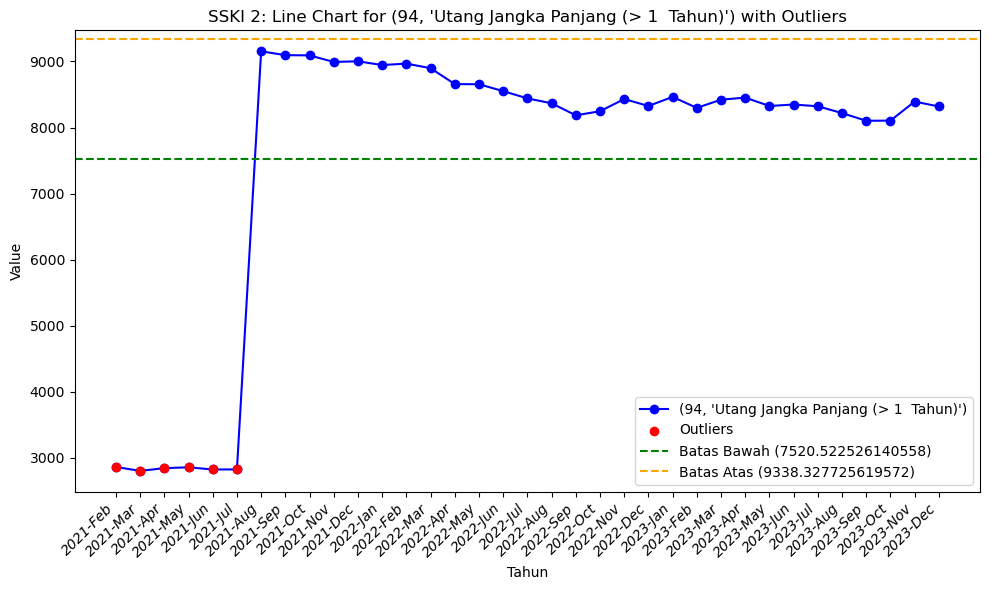

Komponen     Tahun  Nilai Outlier  \
22  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Feb    2862.205977   
23  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Mar    2803.268371   
24  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Apr    2844.520048   
25  (94, Utang Jangka Panjang (> 1  Tahun))  2021-May    2857.195323   
26  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Jun    2824.276656   
27  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Jul    2825.662252   

    Batas Bawah   Batas Atas  
22  7520.522526  9338.327726  
23  7520.522526  9338.327726  
24  7520.522526  9338.327726  
25  7520.522526  9338.327726  
26  7520.522526  9338.327726  
27  7520.522526  9338.327726

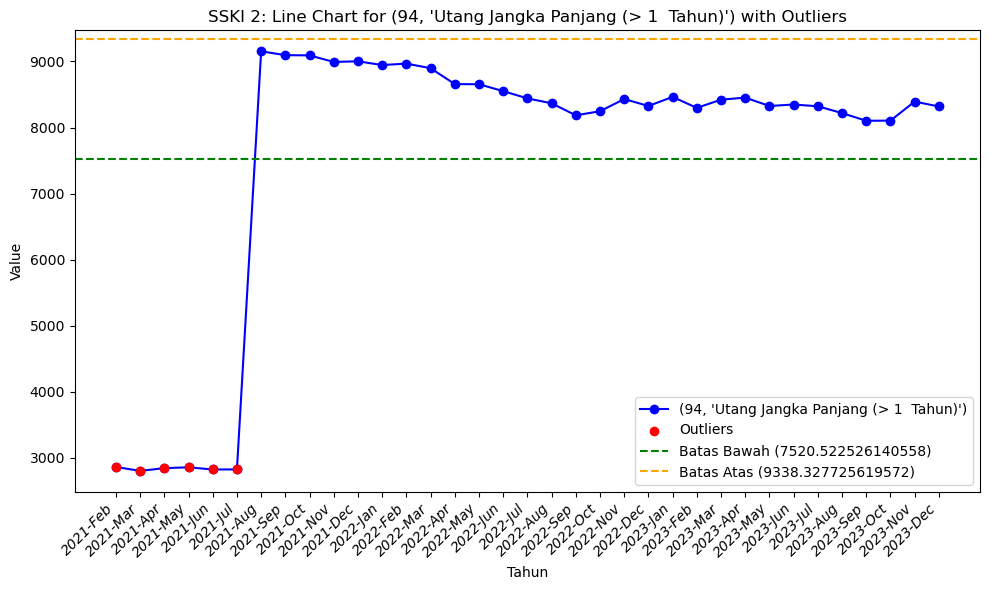

Komponen     Tahun  Nilai Outlier  \
22  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Feb    2862.205977   
23  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Mar    2803.268371   
24  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Apr    2844.520048   
25  (94, Utang Jangka Panjang (> 1  Tahun))  2021-May    2857.195323   
26  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Jun    2824.276656   
27  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Jul    2825.662252   

    Batas Bawah   Batas Atas  
22  7520.522526  9338.327726  
23  7520.522526  9338.327726  
24  7520.522526  9338.327726  
25  7520.522526  9338.327726  
26  7520.522526  9338.327726  
27  7520.522526  9338.327726

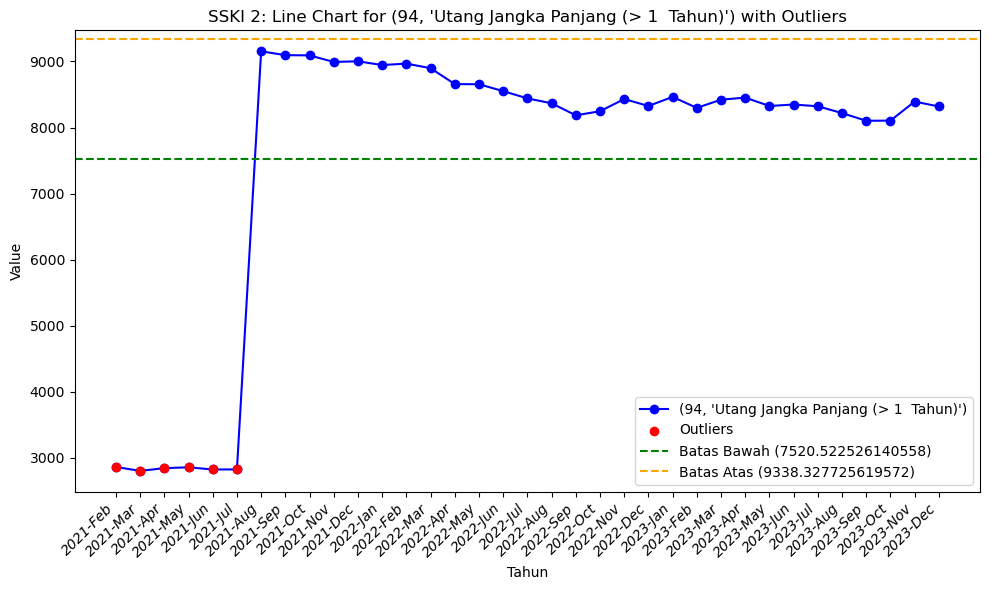

Komponen     Tahun  Nilai Outlier  \
22  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Feb    2862.205977   
23  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Mar    2803.268371   
24  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Apr    2844.520048   
25  (94, Utang Jangka Panjang (> 1  Tahun))  2021-May    2857.195323   
26  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Jun    2824.276656   
27  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Jul    2825.662252   

    Batas Bawah   Batas Atas  
22  7520.522526  9338.327726  
23  7520.522526  9338.327726  
24  7520.522526  9338.327726  
25  7520.522526  9338.327726  
26  7520.522526  9338.327726  
27  7520.522526  9338.327726

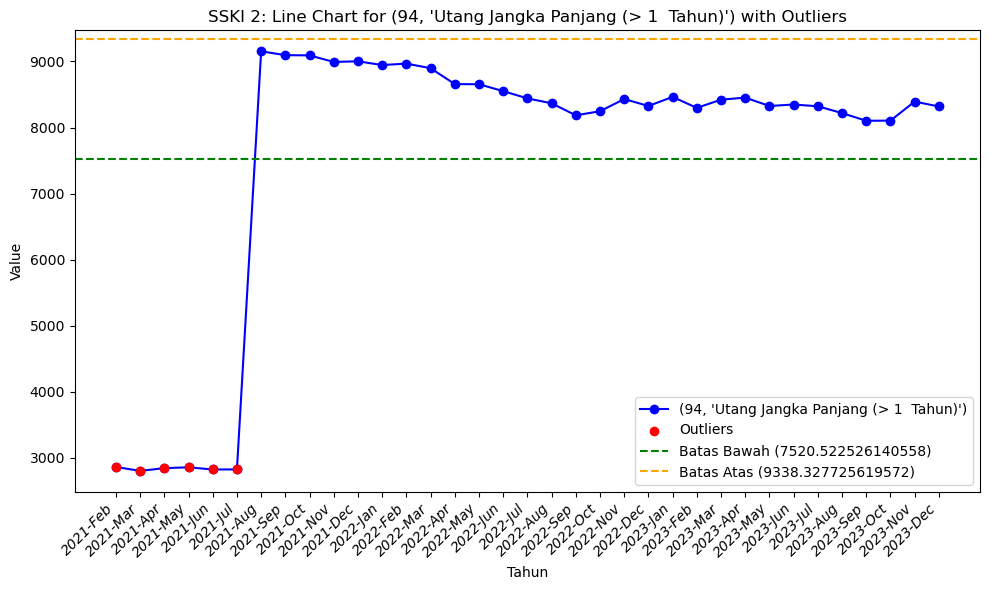

Komponen     Tahun  Nilai Outlier  \
22  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Feb    2862.205977   
23  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Mar    2803.268371   
24  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Apr    2844.520048   
25  (94, Utang Jangka Panjang (> 1  Tahun))  2021-May    2857.195323   
26  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Jun    2824.276656   
27  (94, Utang Jangka Panjang (> 1  Tahun))  2021-Jul    2825.662252   

    Batas Bawah   Batas Atas  
22  7520.522526  9338.327726  
23  7520.522526  9338.327726  
24  7520.522526  9338.327726  
25  7520.522526  9338.327726  
26  7520.522526  9338.327726  
27  7520.522526  9338.327726

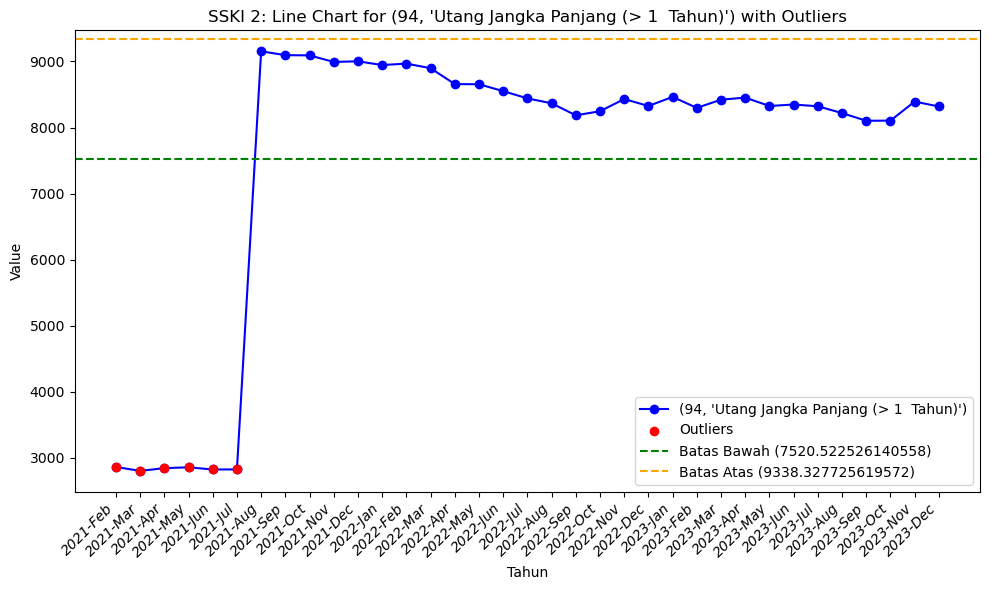

Komponen     Tahun  Nilai Outlier   Batas Bawah    Batas Atas
28  (96, Bank )  2023-Jul   31593.977524  31616.706261  35572.268161

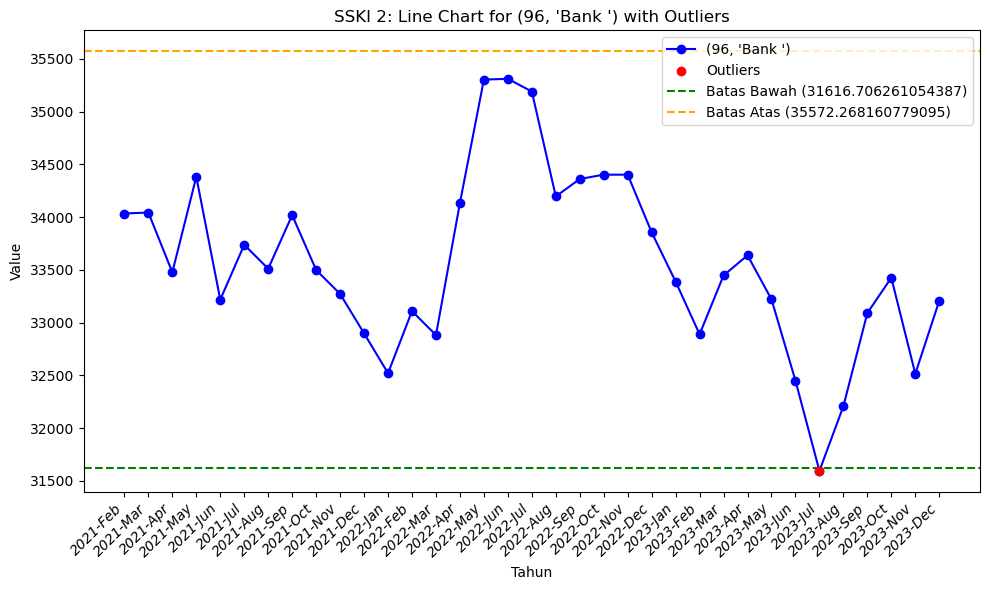

Komponen     Tahun  Nilai Outlier  \
29  (97, Utang Jangka Pendek (≤ 1  Tahun))  2022-May   22533.401262   
30  (97, Utang Jangka Pendek (≤ 1  Tahun))  2022-Jun   22254.682271   
31  (97, Utang Jangka Pendek (≤ 1  Tahun))  2023-Oct   22751.377834   
32  (97, Utang Jangka Pendek (≤ 1  Tahun))  2023-Dec   22554.661491   

     Batas Bawah    Batas Atas  
29  18506.102225  21845.106593  
30  18506.102225  21845.106593  
31  18506.102225  21845.106593  
32  18506.102225  21845.106593

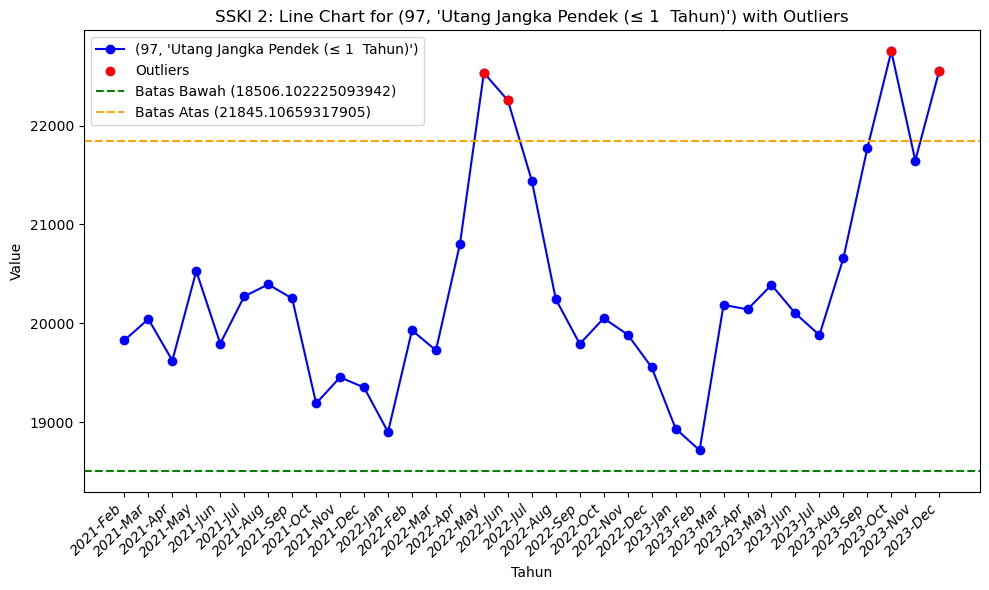

Komponen     Tahun  Nilai Outlier  \
29  (97, Utang Jangka Pendek (≤ 1  Tahun))  2022-May   22533.401262   
30  (97, Utang Jangka Pendek (≤ 1  Tahun))  2022-Jun   22254.682271   
31  (97, Utang Jangka Pendek (≤ 1  Tahun))  2023-Oct   22751.377834   
32  (97, Utang Jangka Pendek (≤ 1  Tahun))  2023-Dec   22554.661491   

     Batas Bawah    Batas Atas  
29  18506.102225  21845.106593  
30  18506.102225  21845.106593  
31  18506.102225  21845.106593  
32  18506.102225  21845.106593

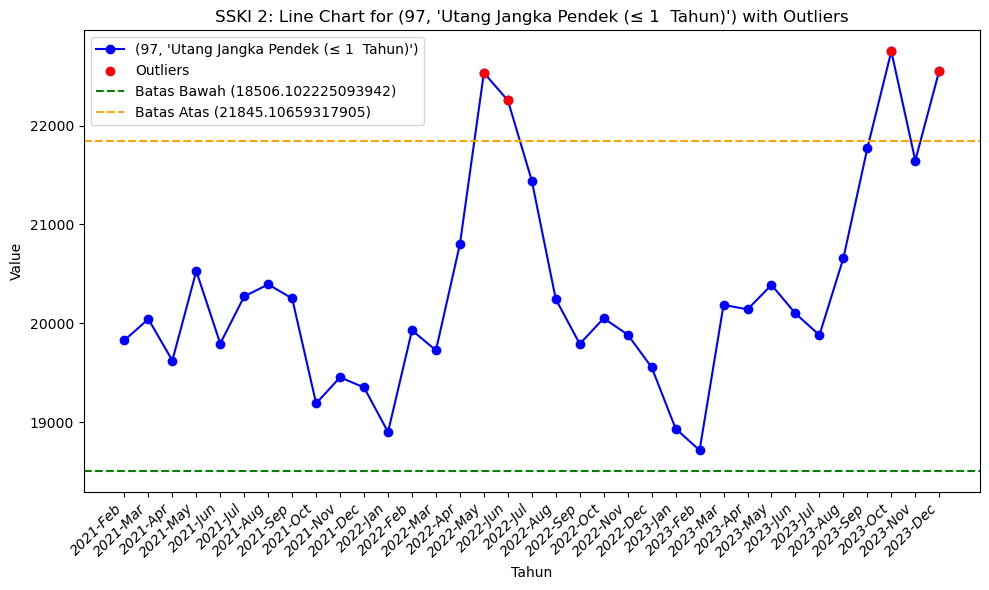

Komponen     Tahun  Nilai Outlier  \
29  (97, Utang Jangka Pendek (≤ 1  Tahun))  2022-May   22533.401262   
30  (97, Utang Jangka Pendek (≤ 1  Tahun))  2022-Jun   22254.682271   
31  (97, Utang Jangka Pendek (≤ 1  Tahun))  2023-Oct   22751.377834   
32  (97, Utang Jangka Pendek (≤ 1  Tahun))  2023-Dec   22554.661491   

     Batas Bawah    Batas Atas  
29  18506.102225  21845.106593  
30  18506.102225  21845.106593  
31  18506.102225  21845.106593  
32  18506.102225  21845.106593

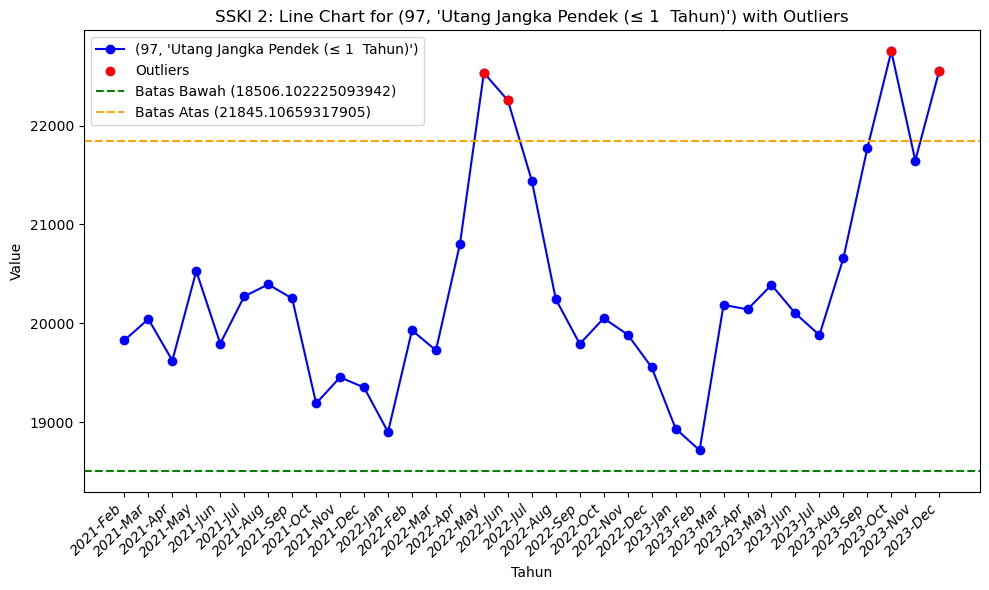

Komponen     Tahun  Nilai Outlier  \
29  (97, Utang Jangka Pendek (≤ 1  Tahun))  2022-May   22533.401262   
30  (97, Utang Jangka Pendek (≤ 1  Tahun))  2022-Jun   22254.682271   
31  (97, Utang Jangka Pendek (≤ 1  Tahun))  2023-Oct   22751.377834   
32  (97, Utang Jangka Pendek (≤ 1  Tahun))  2023-Dec   22554.661491   

     Batas Bawah    Batas Atas  
29  18506.102225  21845.106593  
30  18506.102225  21845.106593  
31  18506.102225  21845.106593  
32  18506.102225  21845.106593

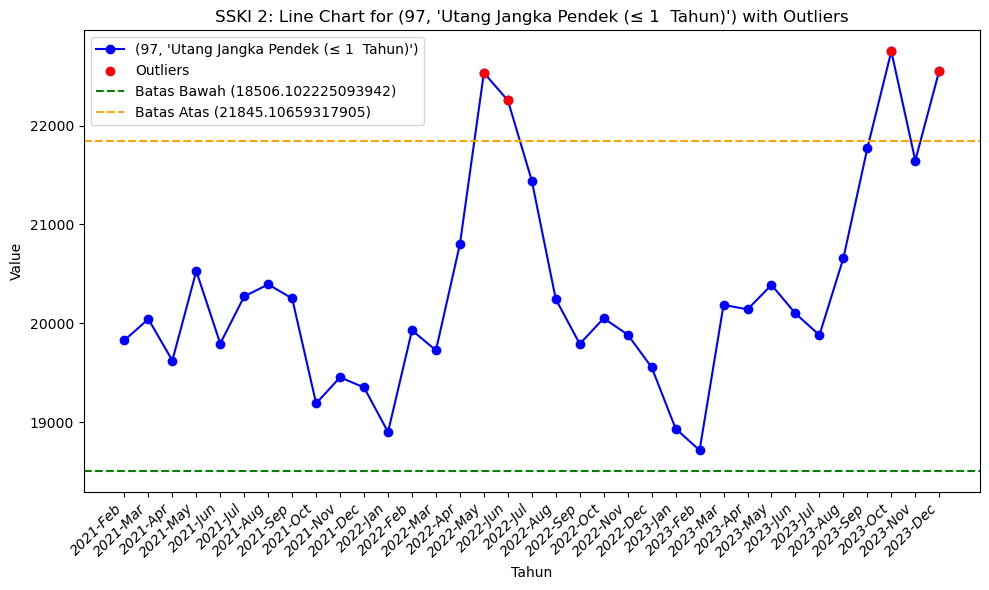

Komponen     Tahun  Nilai Outlier  \
33  (98, Utang Jangka Panjang (> 1  Tahun))  2023-Sep   11319.935352   
34  (98, Utang Jangka Panjang (> 1  Tahun))  2023-Oct   10673.995396   
35  (98, Utang Jangka Panjang (> 1  Tahun))  2023-Nov   10867.771444   
36  (98, Utang Jangka Panjang (> 1  Tahun))  2023-Dec   10651.857242   

     Batas Bawah    Batas Atas  
33  11396.212085  15525.651338  
34  11396.212085  15525.651338  
35  11396.212085  15525.651338  
36  11396.212085  15525.651338

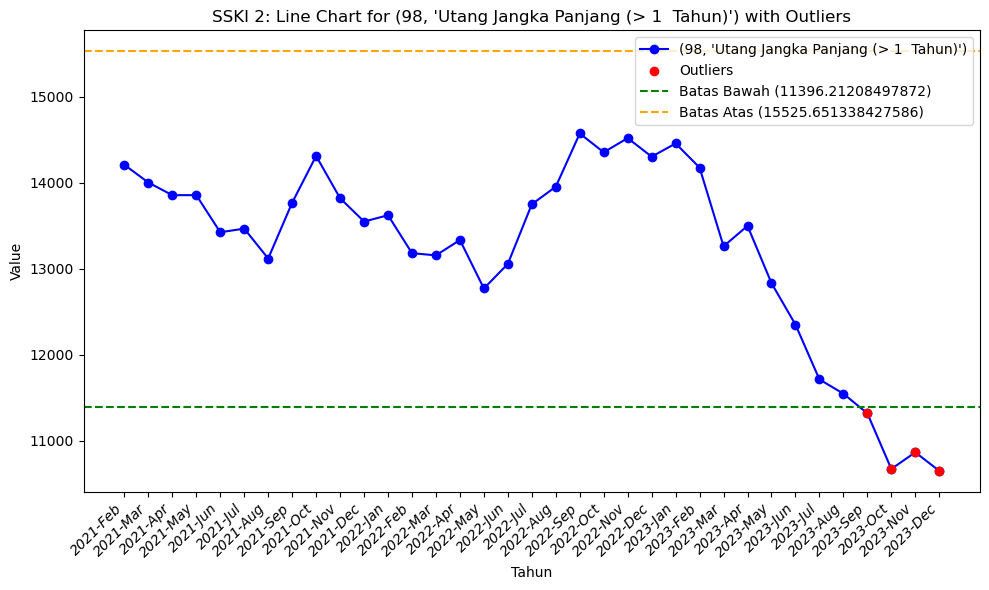

Komponen     Tahun  Nilai Outlier  \
33  (98, Utang Jangka Panjang (> 1  Tahun))  2023-Sep   11319.935352   
34  (98, Utang Jangka Panjang (> 1  Tahun))  2023-Oct   10673.995396   
35  (98, Utang Jangka Panjang (> 1  Tahun))  2023-Nov   10867.771444   
36  (98, Utang Jangka Panjang (> 1  Tahun))  2023-Dec   10651.857242   

     Batas Bawah    Batas Atas  
33  11396.212085  15525.651338  
34  11396.212085  15525.651338  
35  11396.212085  15525.651338  
36  11396.212085  15525.651338

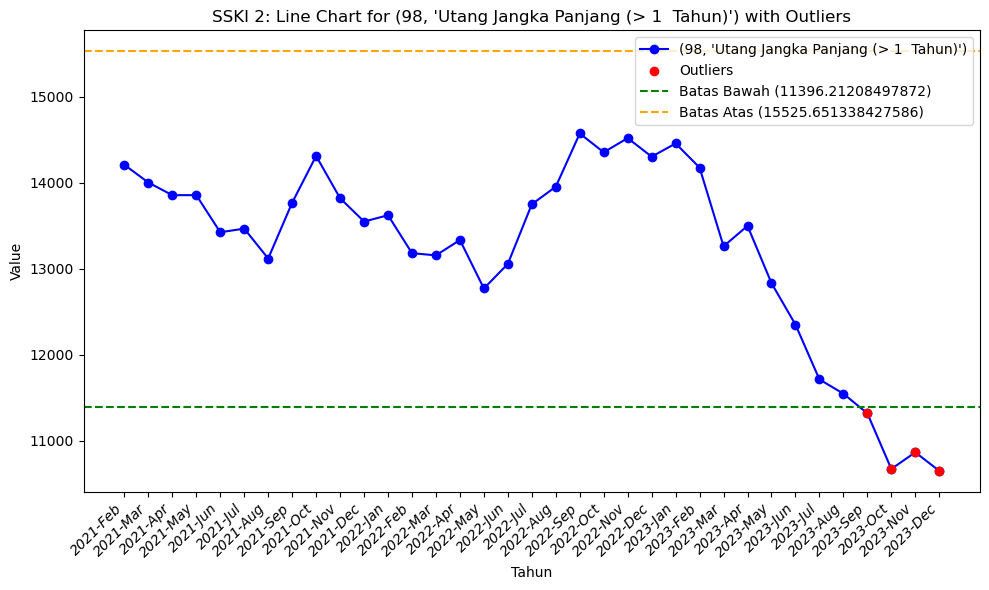

Komponen     Tahun  Nilai Outlier  \
33  (98, Utang Jangka Panjang (> 1  Tahun))  2023-Sep   11319.935352   
34  (98, Utang Jangka Panjang (> 1  Tahun))  2023-Oct   10673.995396   
35  (98, Utang Jangka Panjang (> 1  Tahun))  2023-Nov   10867.771444   
36  (98, Utang Jangka Panjang (> 1  Tahun))  2023-Dec   10651.857242   

     Batas Bawah    Batas Atas  
33  11396.212085  15525.651338  
34  11396.212085  15525.651338  
35  11396.212085  15525.651338  
36  11396.212085  15525.651338

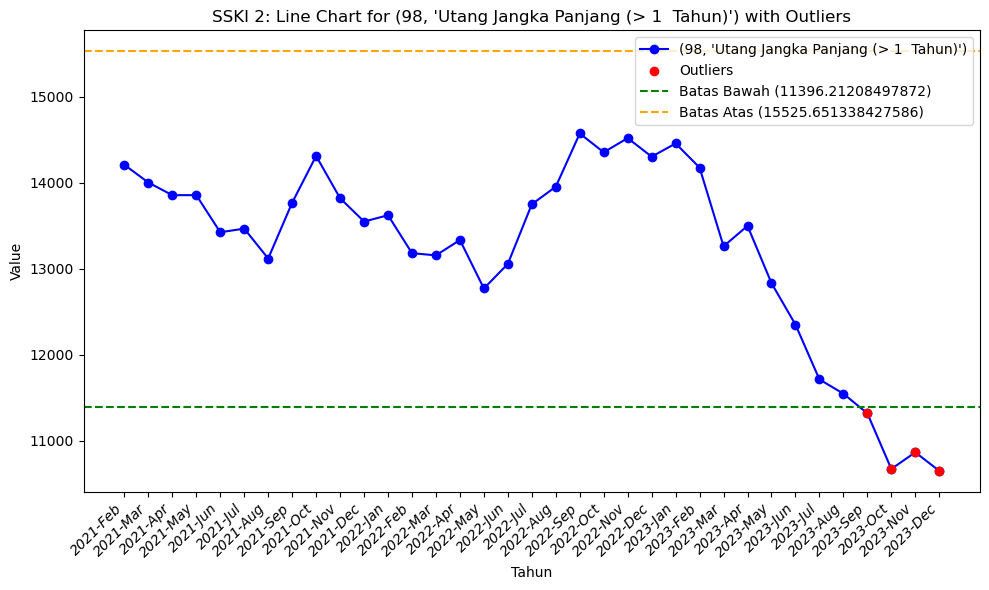

Komponen     Tahun  Nilai Outlier  \
33  (98, Utang Jangka Panjang (> 1  Tahun))  2023-Sep   11319.935352   
34  (98, Utang Jangka Panjang (> 1  Tahun))  2023-Oct   10673.995396   
35  (98, Utang Jangka Panjang (> 1  Tahun))  2023-Nov   10867.771444   
36  (98, Utang Jangka Panjang (> 1  Tahun))  2023-Dec   10651.857242   

     Batas Bawah    Batas Atas  
33  11396.212085  15525.651338  
34  11396.212085  15525.651338  
35  11396.212085  15525.651338  
36  11396.212085  15525.651338

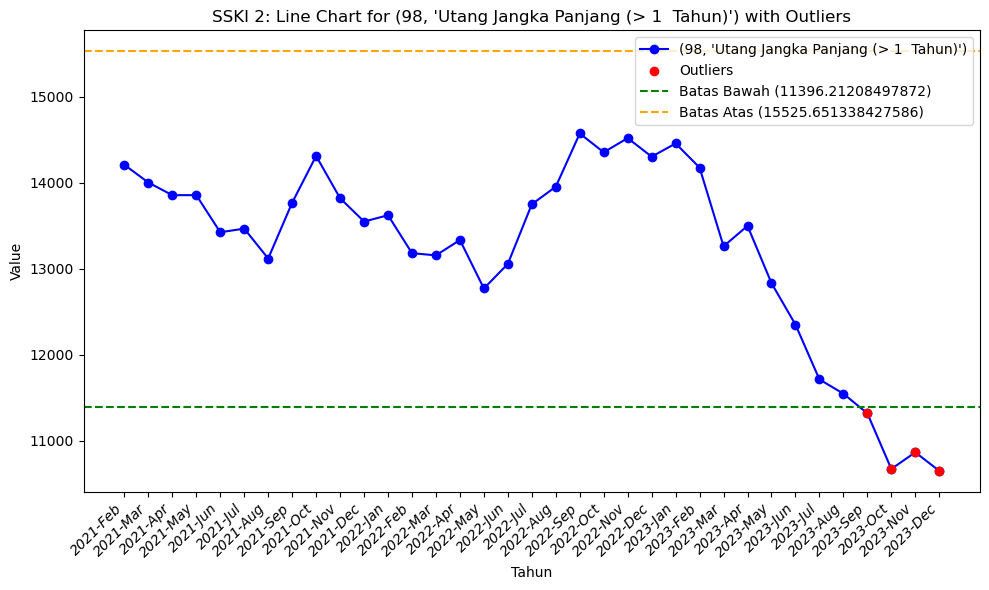

In [30]:
# Daftar nama sheet yang akan diproses
sheet_names = ["1", "2"]  # Ganti dengan nama sheet sebenarnya

# Loop untuk memproses semua sheet
for sheet_name in sheet_names:
    print(f"Processing SSKI {sheet_name}...")

    if sheet_name == "5a":
        raw_df = prepare_dataframe5(sheet_name)
        checked_df = prepare_all(name,raw_df)
        checked_df = checked_df.iloc[1:]
        claims_df, liabilities_df = split5a(checked_df)
        claims_outliers = detect_outliers_iqr(claims_df)
        plot_and_output_outliers(claims_df, claims_outliers, sheet_name)
        liabilities_outliers = detect_outliers_iqr(liabilities_df)
        plot_and_output_outliers(liabilities_df, liabilities_outliers, sheet_name)
    elif sheet_name == "5b" or sheet_name == "5c":
        raw_df = prepare_dataframe5(sheet_name)
        checked_df = prepare_all(name,raw_df)
        checked_df = checked_df.iloc[1:]
        
        # Split the data
        claims_df_total, liabilities_df_total, claims_df_ld, liabilities_df_ld, claims_df_ds, liabilities_df_ds, claims_df_oi, liabilities_df_oi = split5b(checked_df)
        
        # Detect outliers for each group
        claims_df_total_outliers = detect_outliers_iqr(claims_df_total)
        liabilities_df_total_outliers = detect_outliers_iqr(liabilities_df_total)
        claims_df_ld_outliers = detect_outliers_iqr(claims_df_ld)
        liabilities_df_ld_outliers = detect_outliers_iqr(liabilities_df_ld)
        claims_df_ds_outliers = detect_outliers_iqr(claims_df_ds)
        liabilities_df_ds_outliers = detect_outliers_iqr(liabilities_df_ds)
        claims_df_oi_outliers = detect_outliers_iqr(claims_df_oi)
        liabilities_df_oi_outliers = detect_outliers_iqr(liabilities_df_oi)
        
        # Plot and output outliers for each group
        plot_and_output_outliers(claims_df_total, claims_df_total_outliers, sheet_name)
        plot_and_output_outliers(liabilities_df_total, liabilities_df_total_outliers, sheet_name)
        plot_and_output_outliers(claims_df_ld, claims_df_ld_outliers, sheet_name)
        plot_and_output_outliers(liabilities_df_ld, liabilities_df_ld_outliers, sheet_name)
        plot_and_output_outliers(claims_df_ds, claims_df_ds_outliers, sheet_name)
        plot_and_output_outliers(liabilities_df_ds, liabilities_df_ds_outliers, sheet_name)
        plot_and_output_outliers(claims_df_oi, claims_df_oi_outliers, sheet_name)
        plot_and_output_outliers(liabilities_df_oi, liabilities_df_oi_outliers, sheet_name)
    elif sheet_name == "5d":
        raw_df = prepare_dataframe5(sheet_name)
        checked_df = prepare_all(name,raw_df)
        checked_df = checked_df.iloc[1:]
        
        # Split the data
        claims_df_total, liabilities_df_total, claims_df_b, liabilities_df_b, claims_df_nb, liabilities_df_nb = split5d(checked_df)
        
        # Detect outliers for each group
        claims_df_total_outliers = detect_outliers_iqr(claims_df_total)
        liabilities_df_total_outliers = detect_outliers_iqr(liabilities_df_total)
        claims_df_b_outliers = detect_outliers_iqr(claims_df_b)   # Outliers for Banks
        liabilities_df_b_outliers = detect_outliers_iqr(liabilities_df_b)   # Outliers for Banks
        claims_df_nb_outliers = detect_outliers_iqr(claims_df_nb)   # Outliers for Nonbanks
        liabilities_df_nb_outliers = detect_outliers_iqr(liabilities_df_nb)   # Outliers for Nonbanks
        
        # Plot and output outliers for each group
        plot_and_output_outliers(claims_df_total, claims_df_total_outliers, sheet_name)
        plot_and_output_outliers(liabilities_df_total, liabilities_df_total_outliers, sheet_name)
        plot_and_output_outliers(claims_df_b, claims_df_b_outliers, sheet_name)
        plot_and_output_outliers(liabilities_df_b, liabilities_df_b_outliers, sheet_name)
        plot_and_output_outliers(claims_df_nb, claims_df_nb_outliers, sheet_name)
        plot_and_output_outliers(liabilities_df_nb, liabilities_df_nb_outliers, sheet_name)
    elif sheet_name == "5d.1":
        raw_df = prepare_dataframe5(sheet_name)
        checked_df = prepare_all(name,raw_df)
        checked_df = checked_df.iloc[1:]
        
        # Split the data
        claims_df_total, liabilities_df_total, claims_df_r, liabilities_df_r = split5d1(checked_df)
        
        # Detect outliers for each group
        claims_df_total_outliers = detect_outliers_iqr(claims_df_total)
        liabilities_df_total_outliers = detect_outliers_iqr(liabilities_df_total)
        claims_df_r_outliers = detect_outliers_iqr(claims_df_r)   # Outliers for 'r' group
        liabilities_df_r_outliers = detect_outliers_iqr(liabilities_df_r)   # Outliers for 'r' group
        
        # Plot and output outliers for each group
        plot_and_output_outliers(claims_df_total, claims_df_total_outliers, sheet_name)
        plot_and_output_outliers(liabilities_df_total, liabilities_df_total_outliers, sheet_name)
        plot_and_output_outliers(claims_df_r, claims_df_r_outliers, sheet_name)
        plot_and_output_outliers(liabilities_df_r, liabilities_df_r_outliers, sheet_name)
    elif sheet_name == "5.d.2":
        raw_df = prepare_dataframe5(sheet_name)
        checked_df = prepare_all(name,raw_df)
        checked_df = checked_df.iloc[1:]
        # Split the data
        claims_df_total, liabilities_df_total, claims_df_nb, liabilities_df_nb, claims_df_nf, liabilities_df_nf = split5d2(checked_df)
        
        # Detect outliers for each group
        claims_df_total_outliers = detect_outliers_iqr(claims_df_total)
        liabilities_df_total_outliers = detect_outliers_iqr(liabilities_df_total)
        claims_df_nb_outliers = detect_outliers_iqr(claims_df_nb)   # Outliers for Nonbanks
        liabilities_df_nb_outliers = detect_outliers_iqr(liabilities_df_nb)   # Outliers for Nonbanks
        claims_df_nf_outliers = detect_outliers_iqr(claims_df_nf)   # Outliers for Nonfinancials
        liabilities_df_nf_outliers = detect_outliers_iqr(liabilities_df_nf)   # Outliers for Nonfinancials
        
        # Plot and output outliers for each group
        plot_and_output_outliers(claims_df_total, claims_df_total_outliers, sheet_name)
        plot_and_output_outliers(liabilities_df_total, liabilities_df_total_outliers, sheet_name)
        plot_and_output_outliers(claims_df_nb, claims_df_nb_outliers, sheet_name)
        plot_and_output_outliers(liabilities_df_nb, liabilities_df_nb_outliers, sheet_name)
        plot_and_output_outliers(claims_df_nf, claims_df_nf_outliers, sheet_name)
        plot_and_output_outliers(liabilities_df_nf, liabilities_df_nf_outliers, sheet_name)
    else:
        raw_df = prepare_dataframe(sheet_name, 2)
        # checked_df = prepare_qtq(raw_df)
        # checked_df = prepare_mtm(raw_df)
        checked_df = prepare_all(name,raw_df)
        checked_df = checked_df.iloc[1:]
        outliers_df = detect_outliers_iqr(checked_df)
        plot_and_output_outliers(checked_df, outliers_df, sheet_name)